In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sn

import random
from datetime import datetime

from scipy import stats

In [2]:
random.seed(2018)

pd.options.display.max_rows = 50
pd.options.display.max_columns = 100

In [3]:
data_trn = pd.read_csv('train.csv', index_col='Id')
data_tst = pd.read_csv('test.csv', index_col='Id')

In [4]:
# correct some ridiculous mistakes in the data set
# ps: the data preparation work was not good with a lot of misspelling in the csv file and some values don't agree
# with the ones in the description text file.
data_trn['Exterior2nd'].replace(to_replace=['CmentBd','Wd Shng','Brk Cmn'],
                                value=['CemntBd', 'WdShing', 'BrkComm'], 
                                inplace=True)

data_trn['BsmtExposure'].replace(to_replace=['Gd'],
                                 value=['GD'],
                                 inplace=True)

data_tst['Exterior2nd'].replace(to_replace=['CmentBd','Wd Shng','Brk Cmn'],
                                value=['CemntBd', 'WdShing', 'BrkComm'], 
                                inplace=True)

data_tst['BsmtExposure'].replace(to_replace=['Gd'],
                                 value=['GD'],
                                 inplace=True)

In [5]:
# change the unit from $ to 100,000$
Y = data_trn.loc[:,'SalePrice'] / 100000

In [6]:
Y.describe()

count    1460.000000
mean        1.809212
std         0.794425
min         0.349000
25%         1.299750
50%         1.630000
75%         2.140000
max         7.550000
Name: SalePrice, dtype: float64

In [7]:
# deliberately leaving out the first column of the data set because of redundance
X_trn = data_trn.loc[:, 'MSZoning':'SaleCondition']
X_new = data_tst.loc[:, 'MSZoning':'SaleCondition']
X = pd.concat([X_trn, X_new], axis=0)

In [8]:
X.shape

(2919, 78)

In [9]:
null_columns = X.columns[X.isnull().any()]
X[null_columns].isnull().sum()

MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64

In [10]:
# find out all categorical features:
numericalFeatures = []
categoricalFeatures = []

for col in X.columns.values:
    unique = X[col].unique()
    if (type(unique[0]) == str) + (type(unique[1]) == str):
        categoricalFeatures.append(col)
    else:
        numericalFeatures.append(col)

In [11]:
categoricalFeatures

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [12]:
castedFeatures = []

'''
Cast the categorical features with inherent order into scalars
'''

X['BsmtExposure'].replace(to_replace=['GD', 'Av', 'Mn', 'No', 'NA'],
                          value=[7, 5, 3, -1, -1],
                          inplace=True)
X['BsmtExposure'].fillna(0, inplace=True)

castedFeatures.append('BsmtExposure')

# create dictionary for quality ranking
'''
       10	Very Excellent
       9	Excellent          Ex	Excellent
       8	Very Good
       7	Good               Gd	Good
       6	Above Average
       5	Average            TA	Average/Typical
       4	Below Average
       3	Fair               Fa	Fair
       2	Poor               Po	Poor
       1	Very Poor       
'''
qualDict1 = {'Ex' : 9, 'Gd' : 7, 'TA' : 5, 'Fa' : 3, 'Po' : 2, 'NA' : 0}

# replace quality expressions by quality notings
for col in categoricalFeatures:
    if ('TA' in pd.unique(X[col])) + ('Fa' in pd.unique(X[col])) + ('Gd' in pd.unique(X[col])):
        castedFeatures.append(col)
        X[col].fillna(0, inplace=True)
        X[col].replace(to_replace=list(qualDict1.keys()), 
                       value=list(qualDict1.values()),
                       inplace=True)
        

# create dictionary for another quality ranking
'''
       7   GLQ	Good Living Quarters
       5   ALQ	Average Living Quarters
       4   BLQ	Below Average Living Quarters
       3   Rec	Average Rec Room
       2   LwQ	Low Quality
       0.5   Unf	Unfinshed
       0   NA	No Basement
'''
qualDict2 = {'GLQ' : 7, 'ALQ' : 5, 'BLQ' : 4, 'Rec' : 3, 'LwQ' : 2, 'Unf' : 0.5, 'NA' : 0}

# replace quality expressions by quality notings
X['BsmtFinType1'].fillna(0, inplace=True)
X['BsmtFinType2'].fillna(0, inplace=True)

X['BsmtFinType1'].replace(to_replace=list(qualDict2.keys()), 
                          value=list(qualDict2.values()),
                          inplace=True)
X['BsmtFinType2'].replace(to_replace=list(qualDict2.keys()), 
                          value=list(qualDict2.values()),
                          inplace=True)


castedFeatures.append('BsmtFinType1')
castedFeatures.append('BsmtFinType2')

# replace Y/N answers by boolean values
'''
     1    Y
     0.5  P
     0    N
'''
boolDict = {'Y' : 1, 'P' : 0.5, 'N' : 0}

# replace Y/N answers by boolean values
X['PavedDrive'].replace(to_replace=list(boolDict.keys()), 
                        value=list(boolDict.values()),
                        inplace=True)
X['CentralAir'].replace(to_replace=list(boolDict.keys()), 
                        value=list(boolDict.values()),
                        inplace=True)

castedFeatures.append('PavedDrive')
castedFeatures.append('CentralAir')

/Users/siyunwang/Desktop/Python_for_Data_Science/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [13]:
for casted in castedFeatures:
    categoricalFeatures.remove(casted)
    numericalFeatures.append(casted)

In [14]:
print('# of categorical features: %d, \n# of numerical features: %d.' % (len(categoricalFeatures), 
                                                                         len(numericalFeatures)))

# of categorical features: 28, 
# of numerical features: 50.


In [15]:
X.head()

MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour Utilities  \
Id                                                                              
1        RL         65.0     8450   Pave   NaN      Reg         Lvl    AllPub   
2        RL         80.0     9600   Pave   NaN      Reg         Lvl    AllPub   
3        RL         68.0    11250   Pave   NaN      IR1         Lvl    AllPub   
4        RL         60.0     9550   Pave   NaN      IR1         Lvl    AllPub   
5        RL         84.0    14260   Pave   NaN      IR1         Lvl    AllPub   

   LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  \
Id                                                                              
1     Inside       Gtl      CollgCr       Norm       Norm     1Fam     2Story   
2        FR2       Gtl      Veenker      Feedr       Norm     1Fam     1Story   
3     Inside       Gtl      CollgCr       Norm       Norm     1Fam     2Story   
4     Corner       Gtl      Crawfor       Norm       Norm     1Fam     2Story   
5        FR2       Gtl      NoRidge       Norm       Norm     1Fam     2Story   

    OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl  \
Id                                                                         
1             7            5       2003          2003     Gable  CompShg   
2             6            8       1976          1976     Gable  CompShg   
3             7            5       2001          2002     Gable  CompShg   
4             7            5       1915          1970     Gable  CompShg   
5             8            5       2000          2000     Gable  CompShg   

   Exterior1st Exterior2nd MasVnrType  MasVnrArea  ExterQual  ExterCond  \
Id                                                                        
1      VinylSd     VinylSd    BrkFace       196.0          7          5   
2      MetalSd     MetalSd       None         0.0          5          5   
3      VinylSd     VinylSd    BrkFace       162.0          7          5   
4      Wd Sdng     WdShing       None         0.0          5          5   
5      VinylSd     VinylSd    BrkFace       350.0          7          5   

   Foundation  BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinSF1  \
Id                                                                          
1       PConc         7         5          -1.0           7.0       706.0   
2      CBlock         7         5           7.0           5.0       978.0   
3       PConc         7         5           3.0           7.0       486.0   
4      BrkTil         5         7          -1.0           5.0       216.0   
5       PConc         7         5           5.0           7.0       655.0   

    BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating  HeatingQC  \
Id                                                                        
1            0.5         0.0      150.0        856.0    GasA          9   
2            0.5         0.0      284.0       1262.0    GasA          9   
3            0.5         0.0      434.0        920.0    GasA          9   
4            0.5         0.0      540.0        756.0    GasA          7   
5            0.5         0.0      490.0       1145.0    GasA          9   

    CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  \
Id                                                                       
1            1      SBrkr       856       854             0       1710   
2            1      SBrkr      1262         0             0       1262   
3            1      SBrkr       920       866             0       1786   
4            1      SBrkr       961       756             0       1717   
5            1      SBrkr      1145      1053             0       2198   

    BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
Id                                                                 
1            1.0           0.0         2         1             3   
2            0.0   

## Numerical features

In [16]:
numericalFeatures.append('SalePrice')

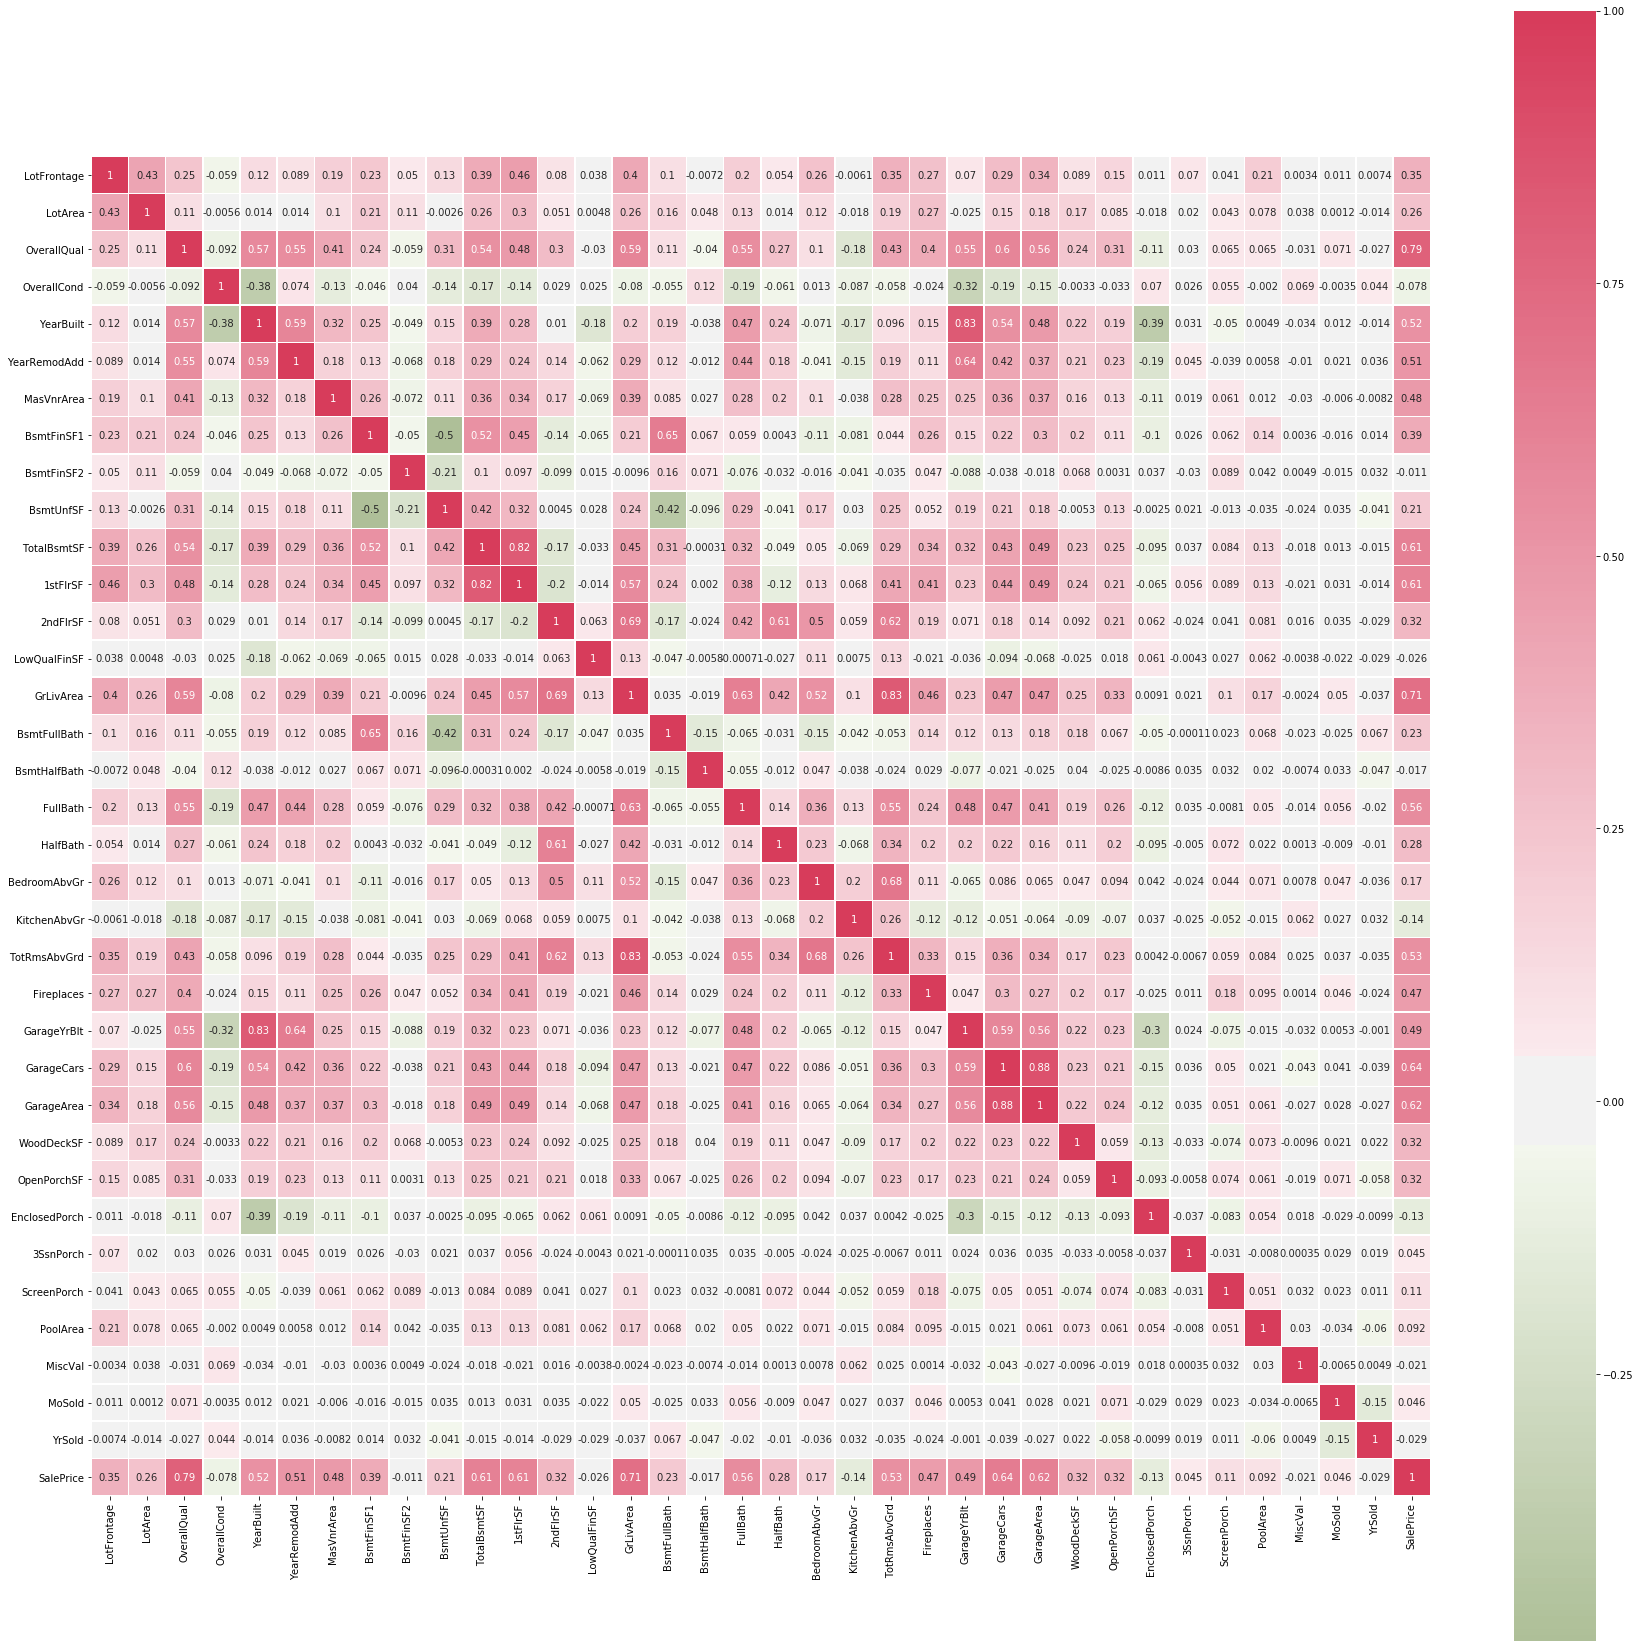

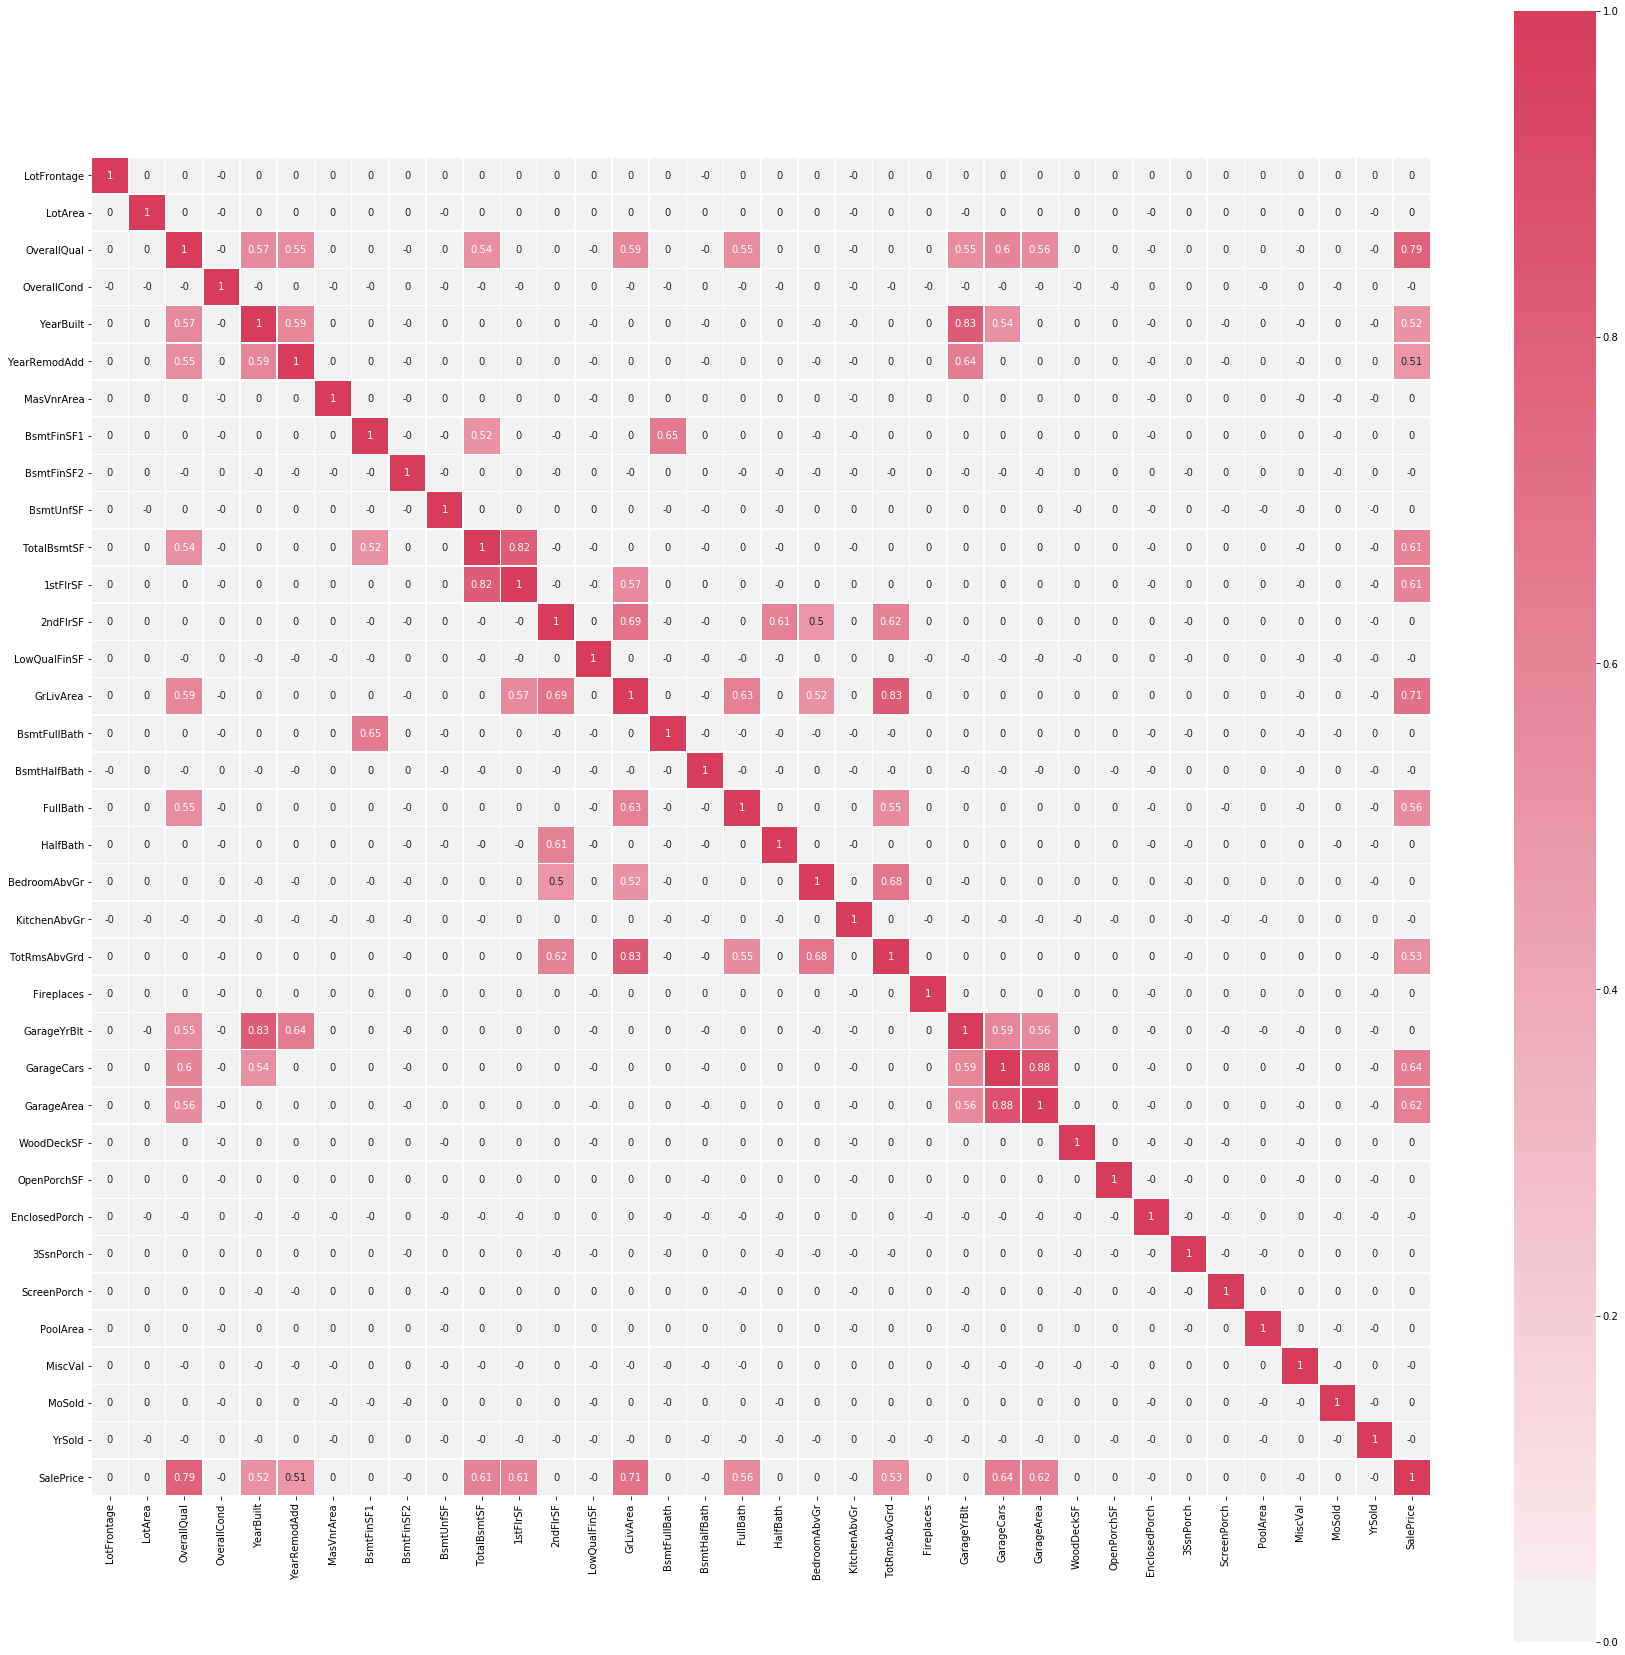

In [17]:
corrMat = data_trn[numericalFeatures].corr()
posCorr = (corrMat>0.5) * corrMat

plt.subplots(figsize=(30, 30))
cmap = sn.diverging_palette(110, 5, as_cmap=True)
sn.heatmap(corrMat, cmap=cmap, vmax=1.0, center=0, square=True, linewidths=0.5, annot=corrMat)
plt.show()

plt.subplots(figsize=(30,30))
cmap = sn.diverging_palette(110, 5, as_cmap=True)
sn.heatmap(posCorr, cmap=cmap, vmax=1.0, center=0, square=True, linewidths=0.5, annot=posCorr)
plt.show()

In [18]:
numericalFeatures.pop(-1)

'SalePrice'

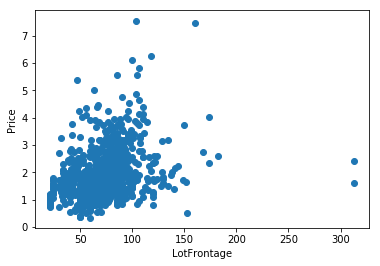

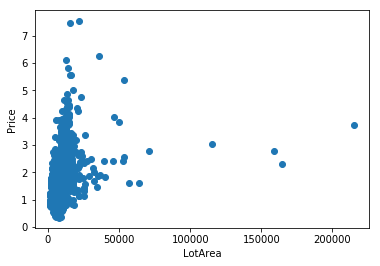

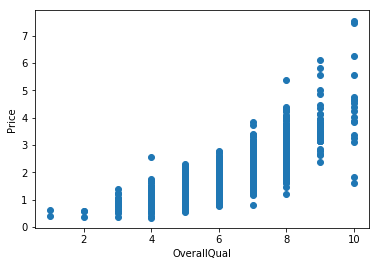

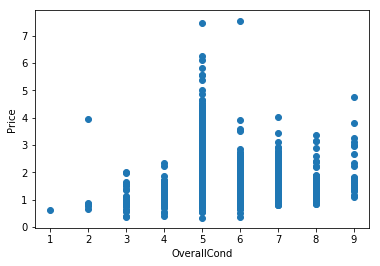

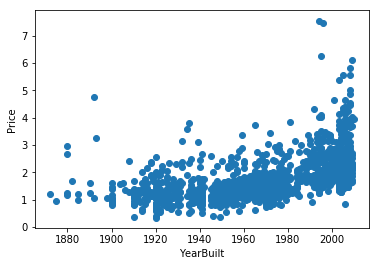

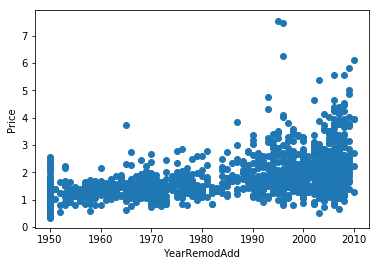

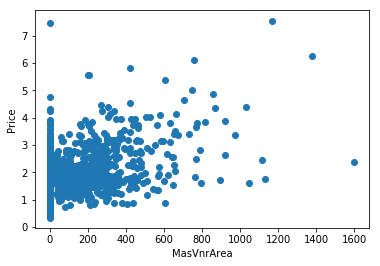

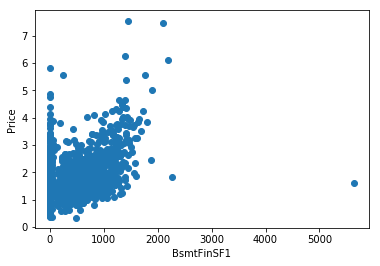

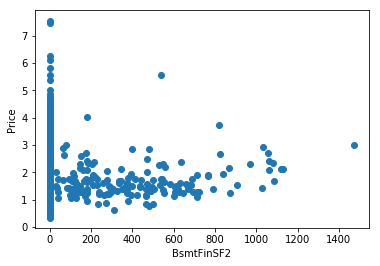

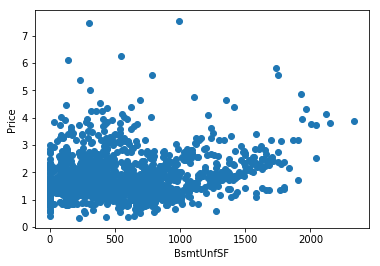

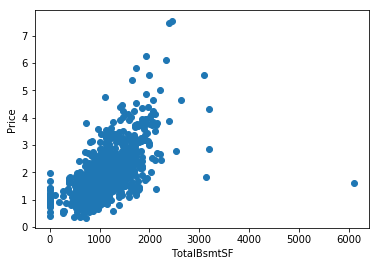

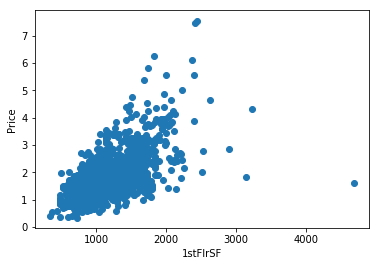

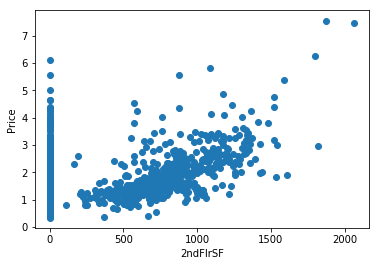

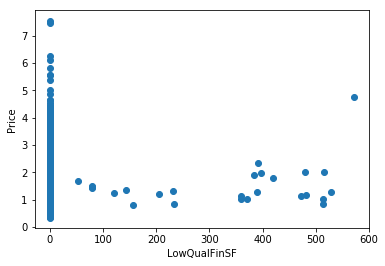

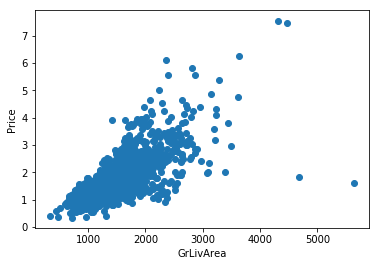

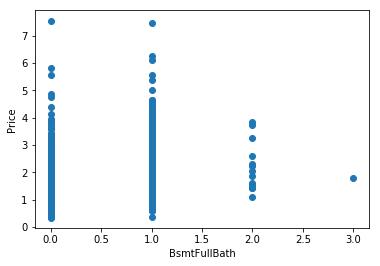

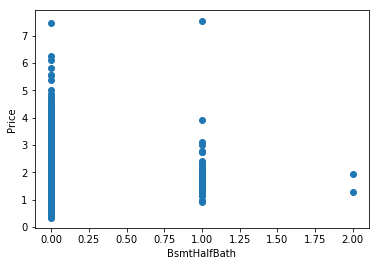

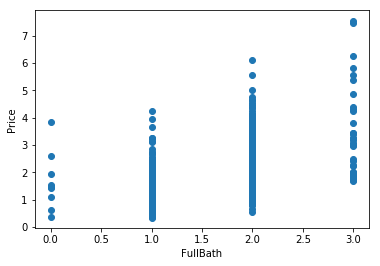

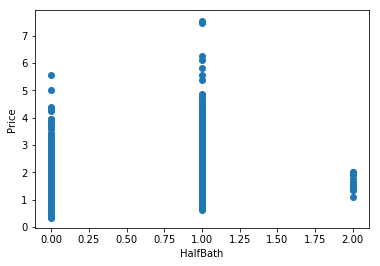

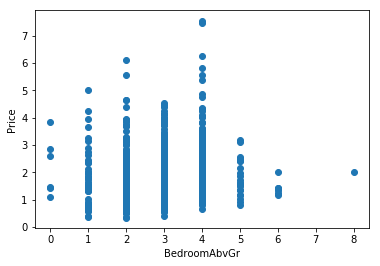

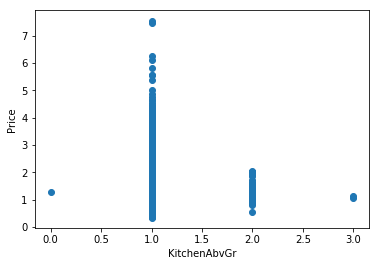

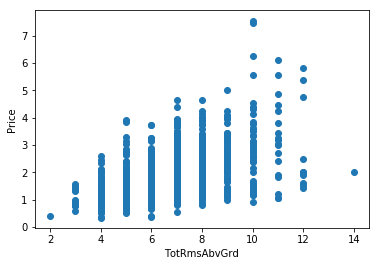

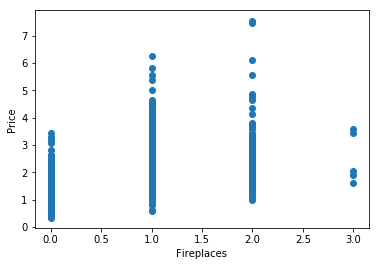

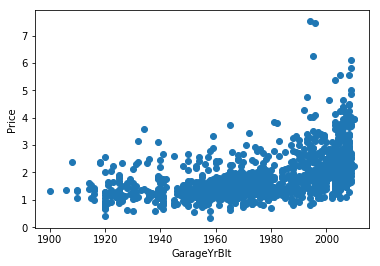

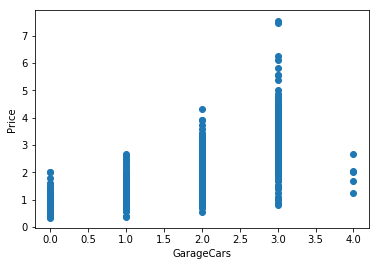

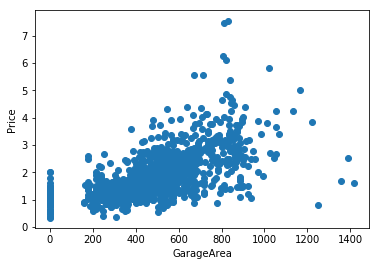

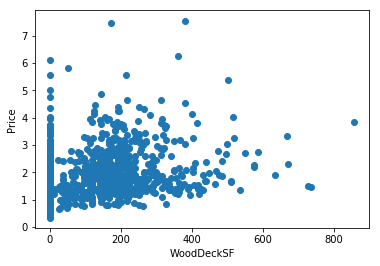

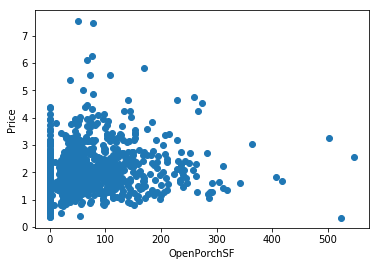

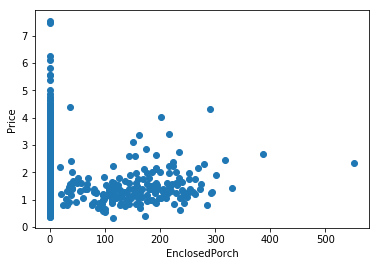

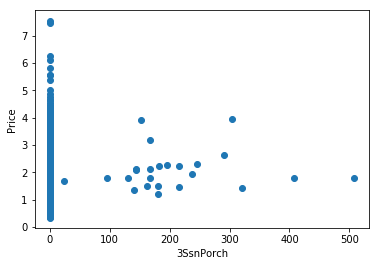

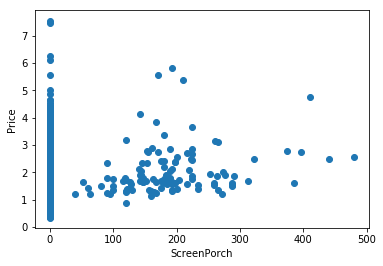

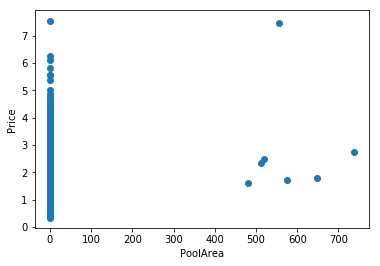

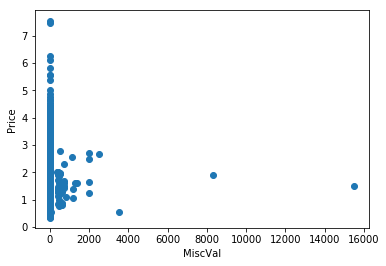

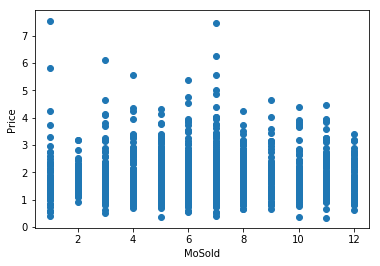

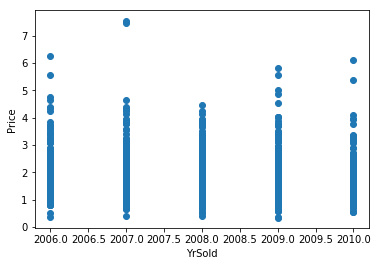

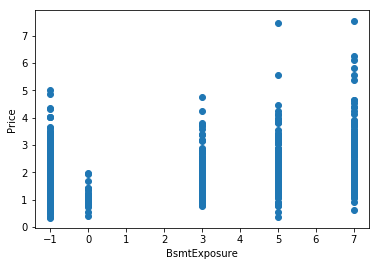

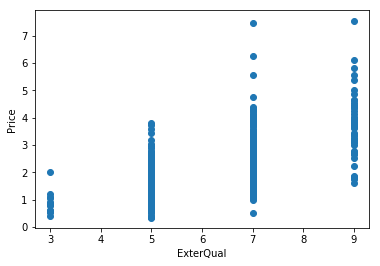

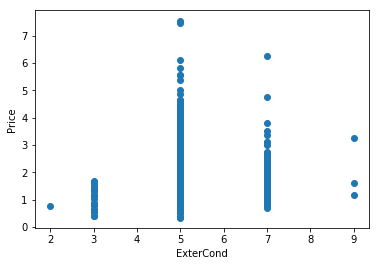

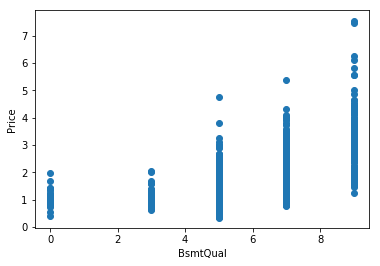

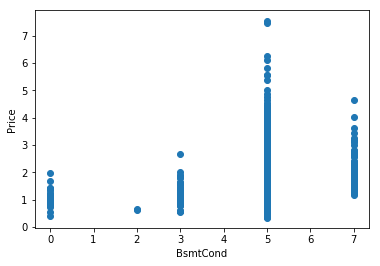

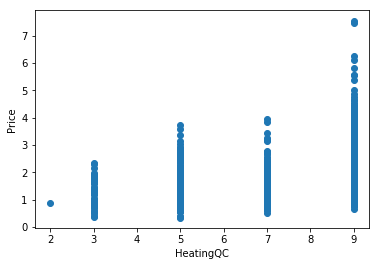

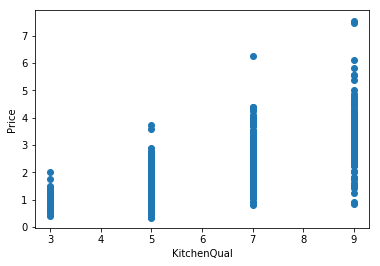

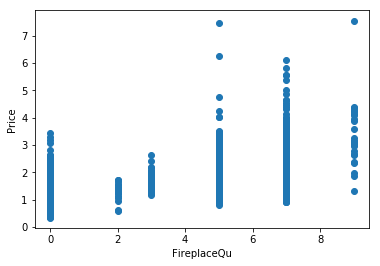

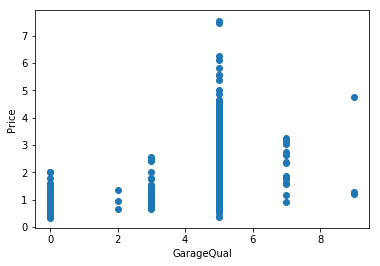

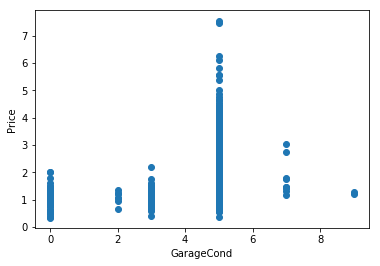

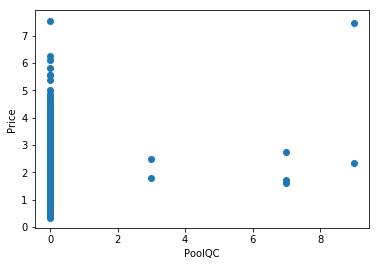

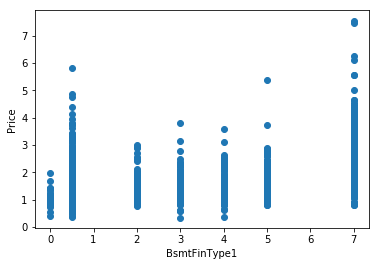

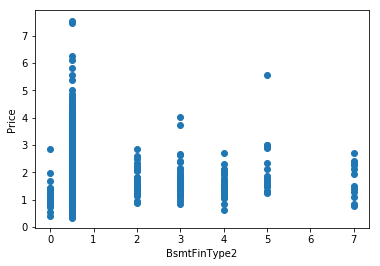

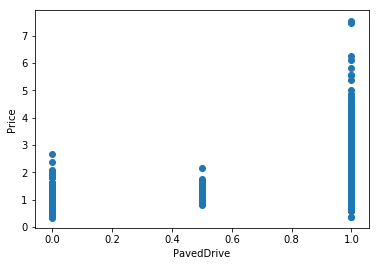

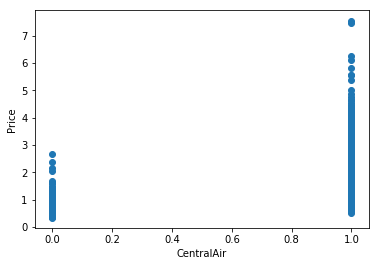

In [19]:
for feature in numericalFeatures:
    plt.scatter(X.iloc[:1460][feature],Y)
    plt.ylabel('Price')
    plt.xlabel(feature)
    plt.show()

In [20]:
suspiciousNumFeatures = ['BsmtFullBath','BsmtHalfBath','HalfBath',
                         'BedroomAbvGr','KitchenAbvGr','Fireplaces',
                         'OpenPorchSF','3SsnPorch','PoolArea','MiscVal','BsmtExposure',
                         'ExterCond','GarageCond','PoolQC','BsmtFinType1',
                         'BsmtFinType2','MoSold', 'YrSold']

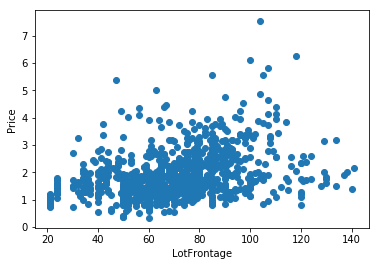

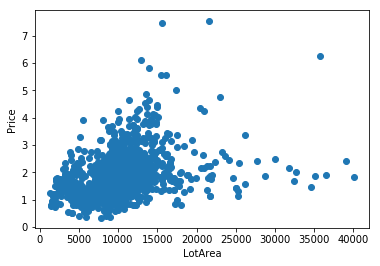

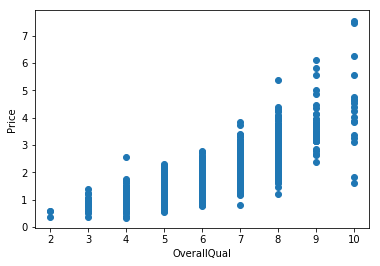

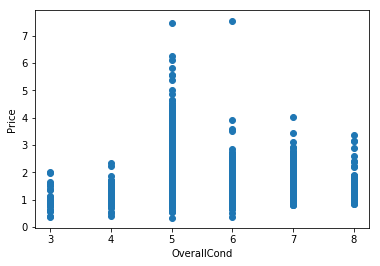

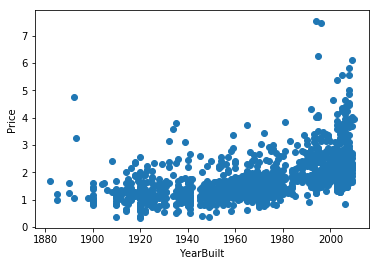

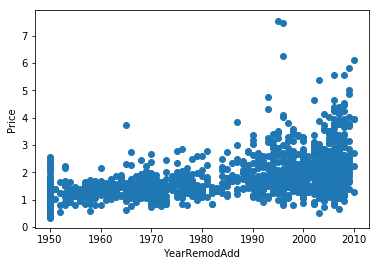

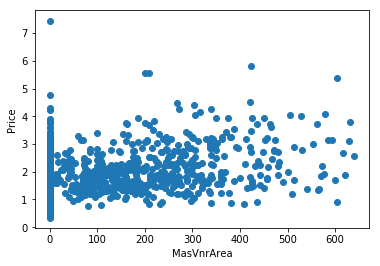

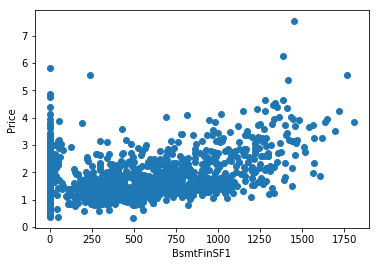

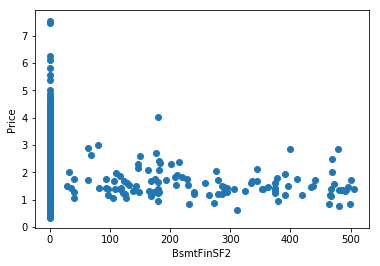

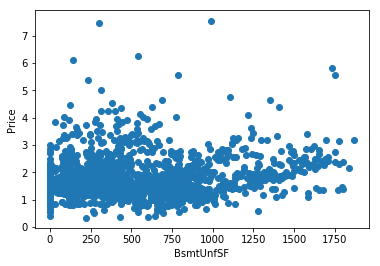

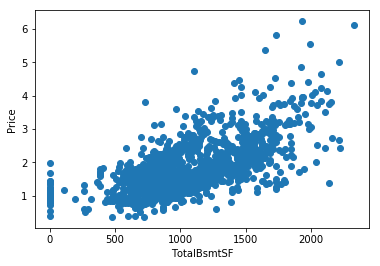

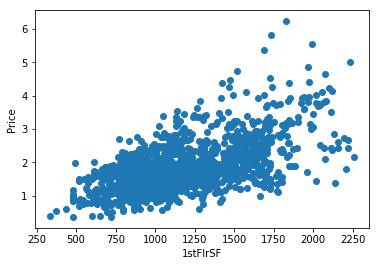

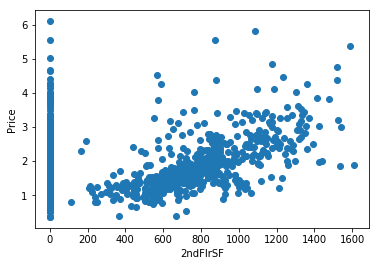

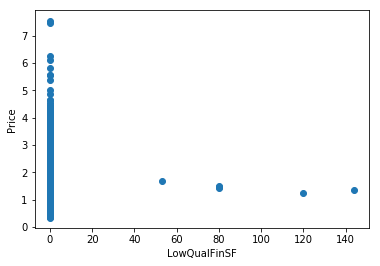

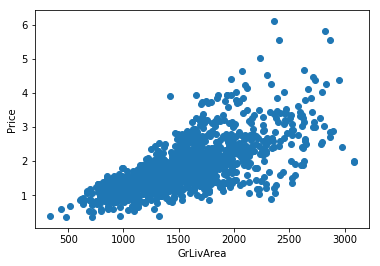

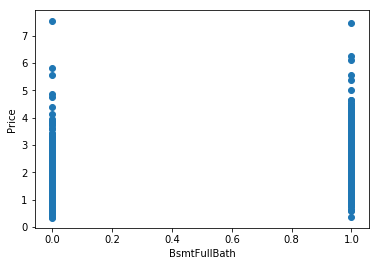

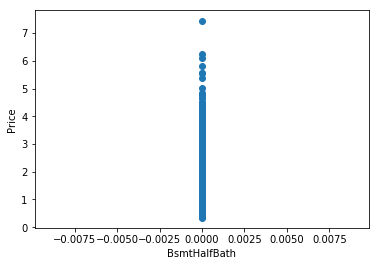

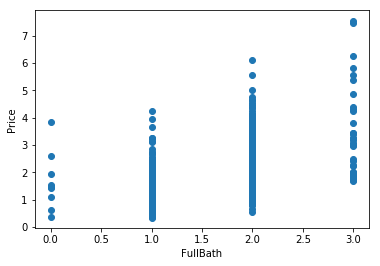

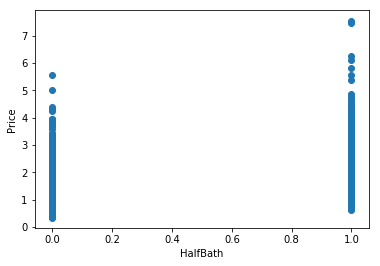

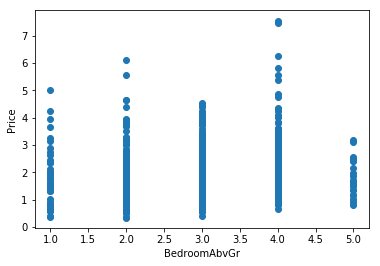

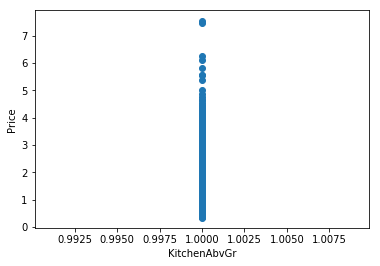

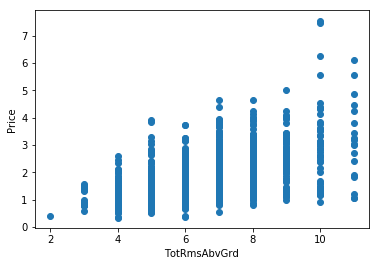

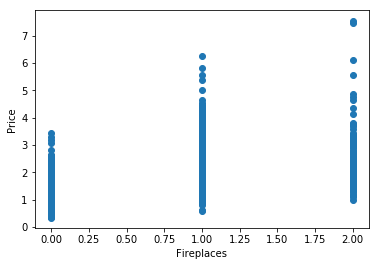

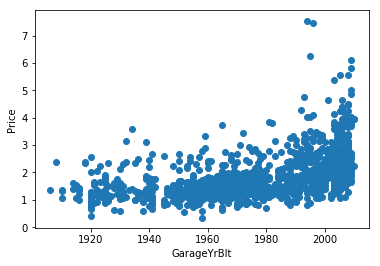

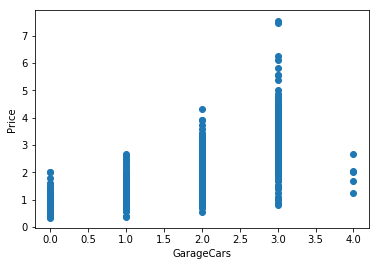

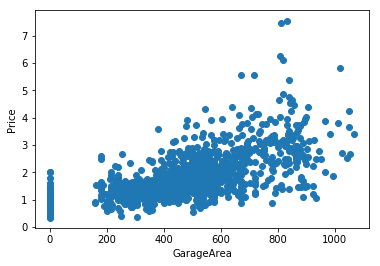

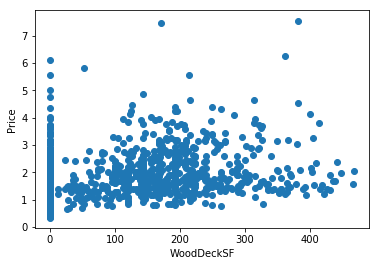

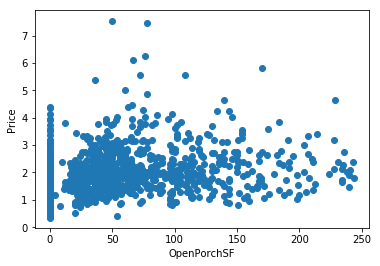

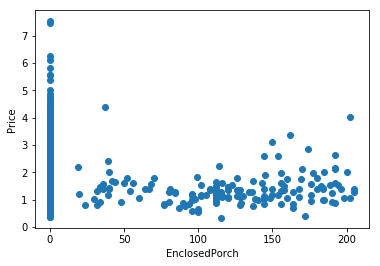

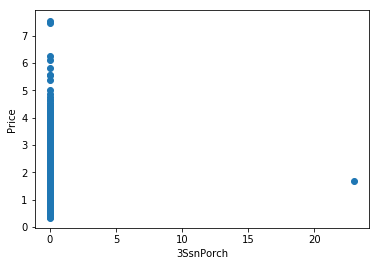

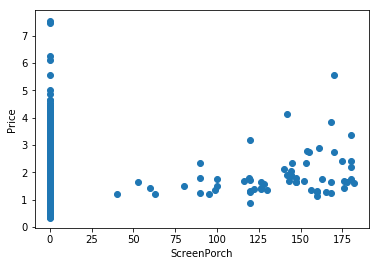

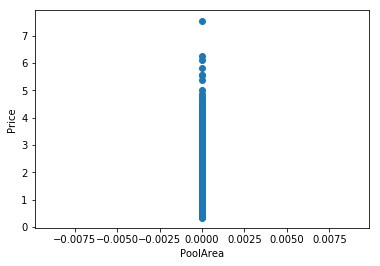

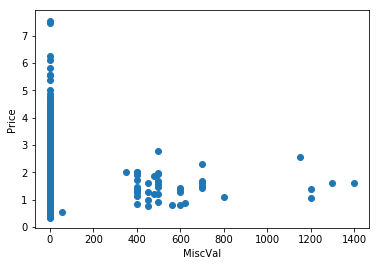

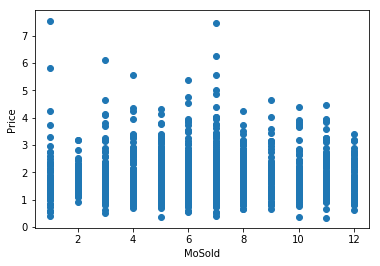

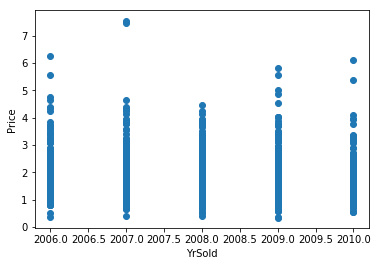

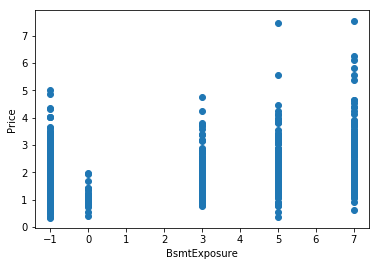

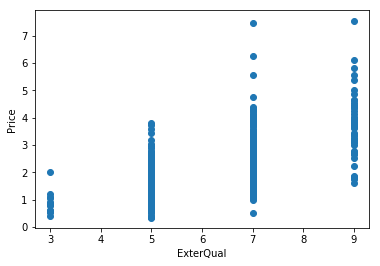

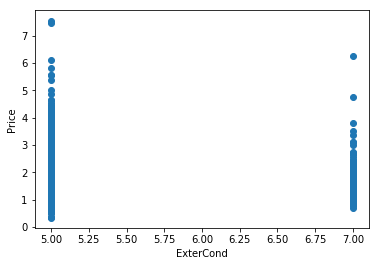

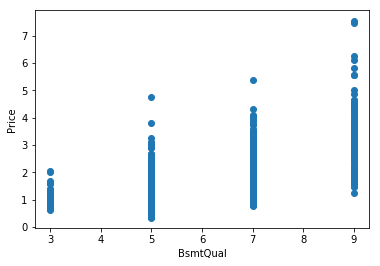

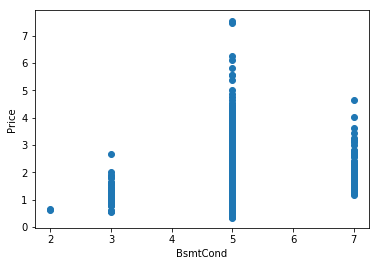

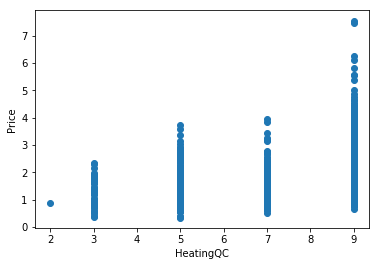

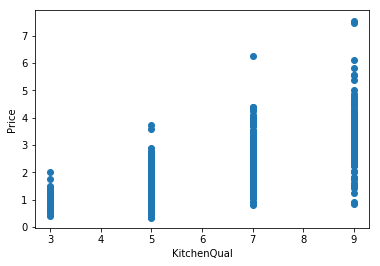

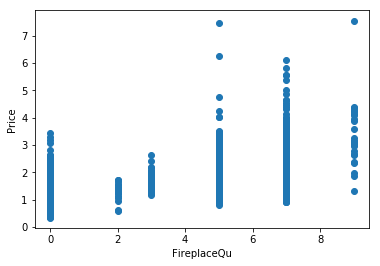

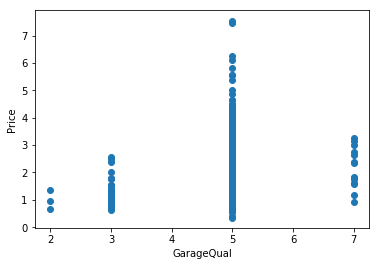

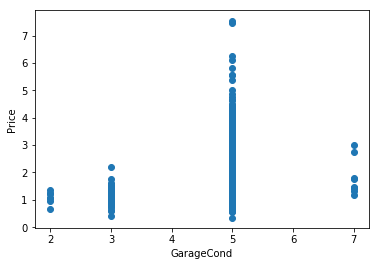

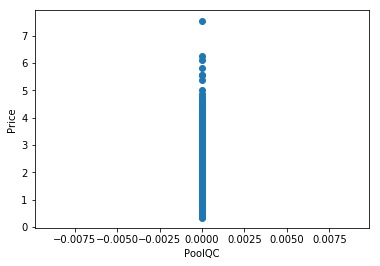

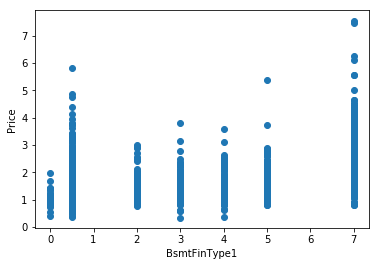

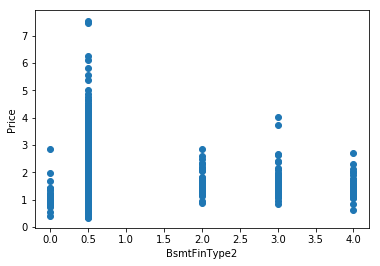

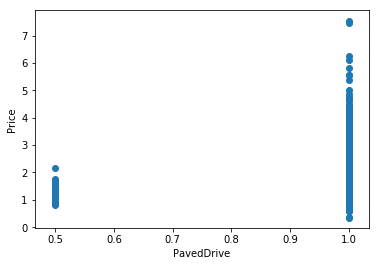

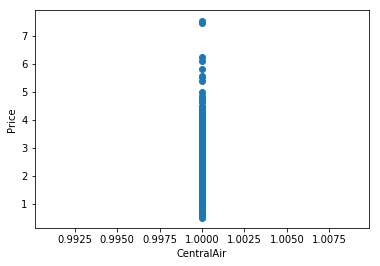

In [21]:
for feature in numericalFeatures:
    outliers_dropped = pd.concat([X.iloc[:1460][feature],Y], axis=1).dropna()
    outliers_dropped = outliers_dropped[abs(stats.zscore(outliers_dropped[feature])) < 3]
    plt.scatter(outliers_dropped[feature],outliers_dropped['SalePrice'])
    plt.ylabel('Price')
    plt.xlabel(feature)
    plt.show()

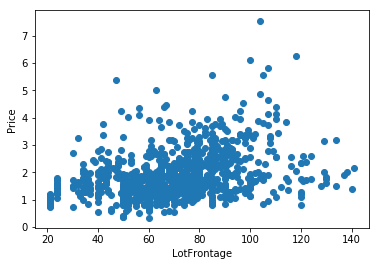

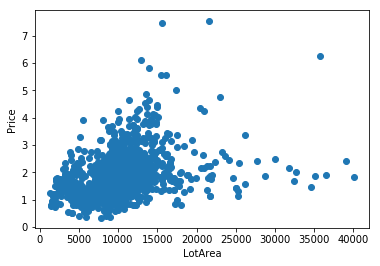

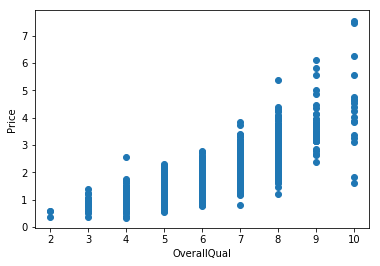

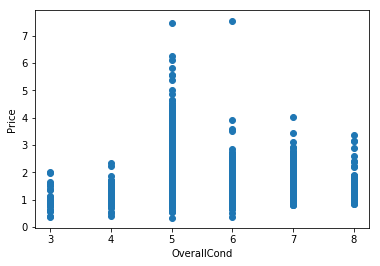

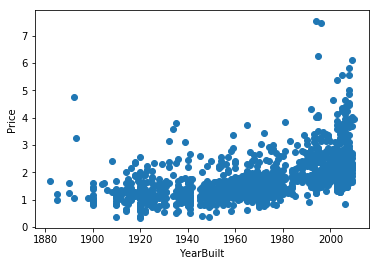

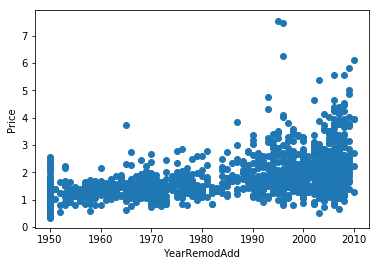

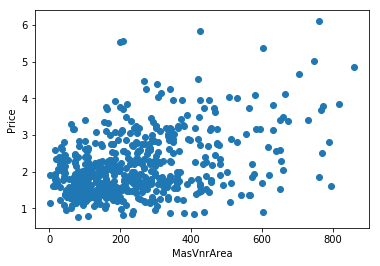

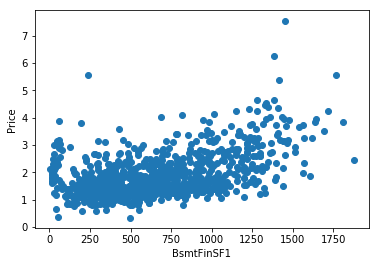

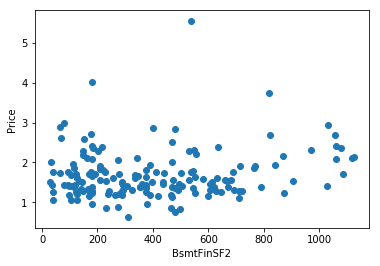

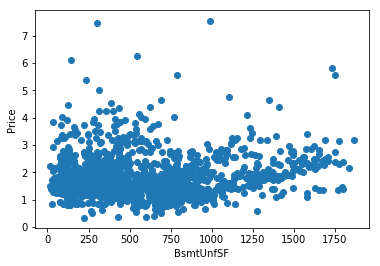

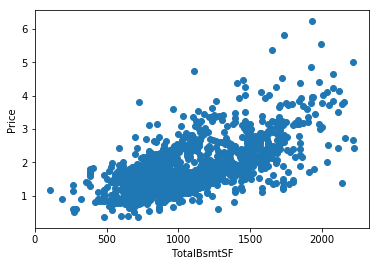

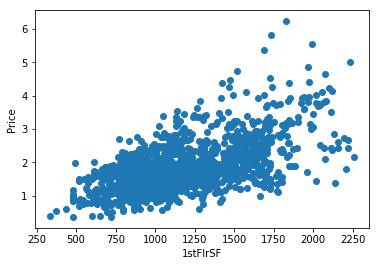

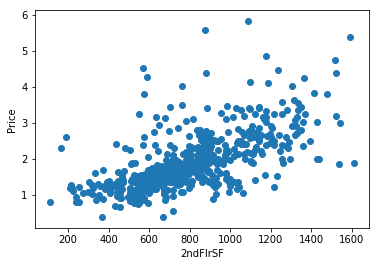

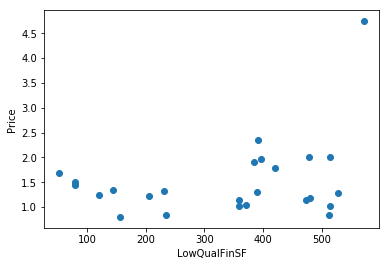

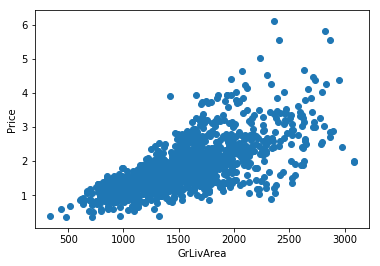

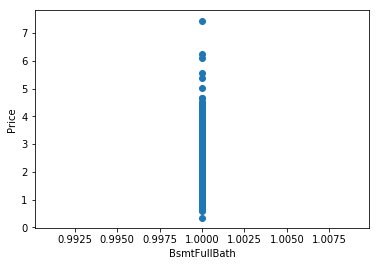

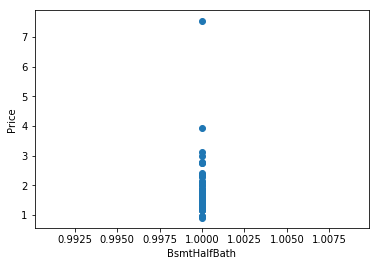

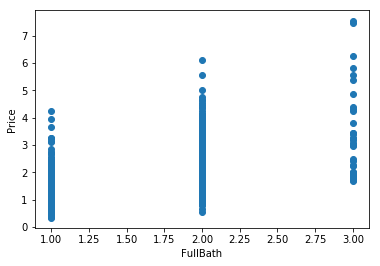

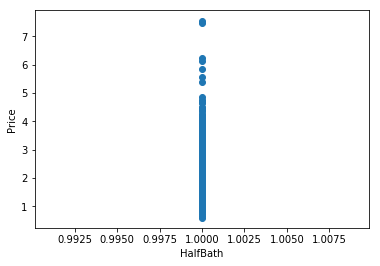

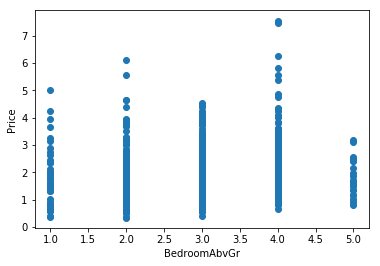

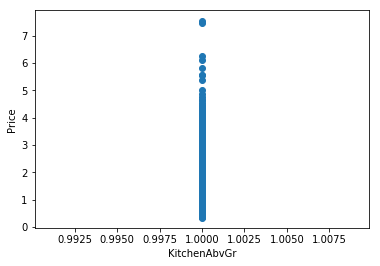

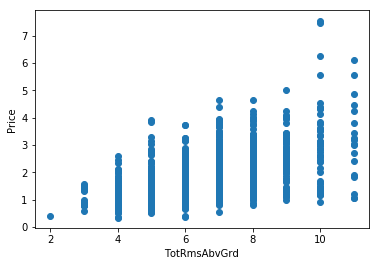

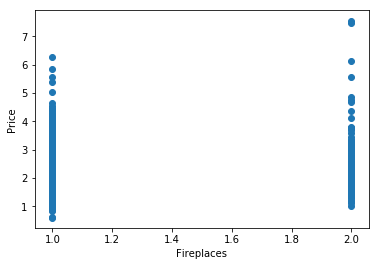

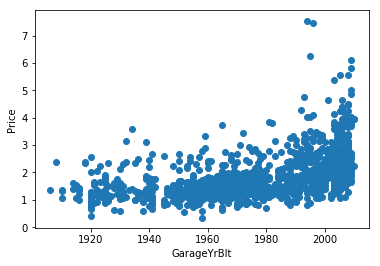

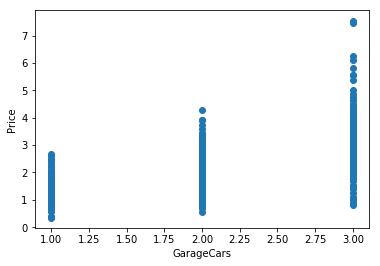

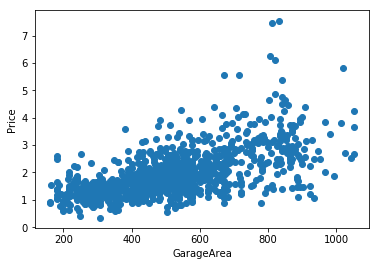

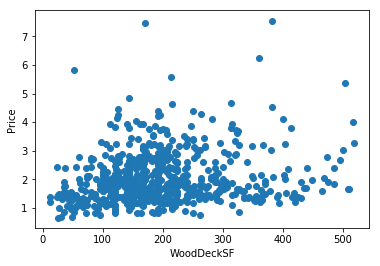

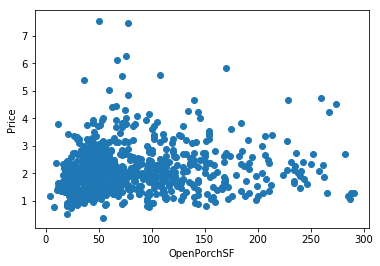

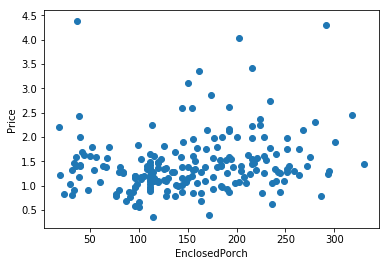

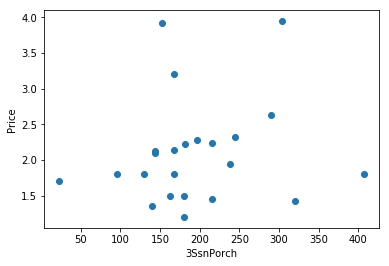

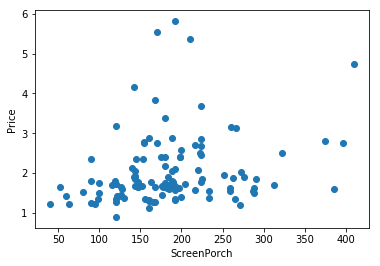

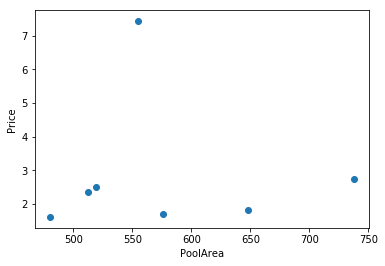

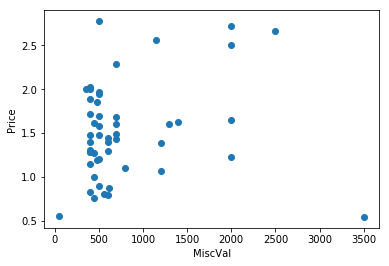

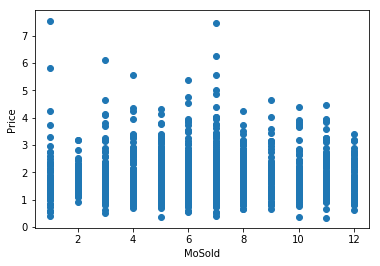

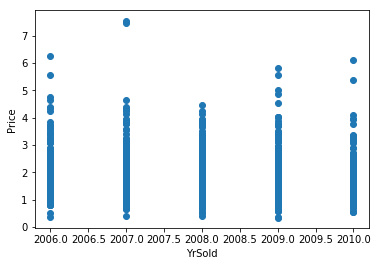

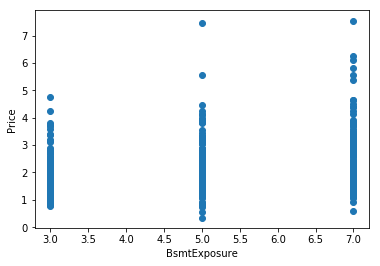

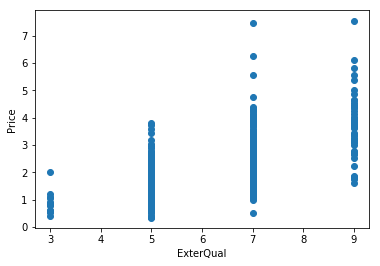

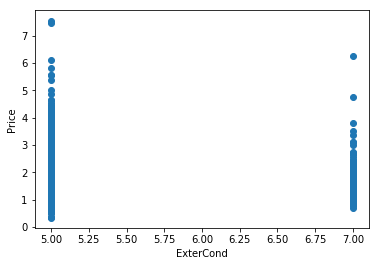

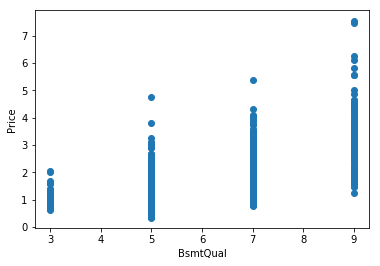

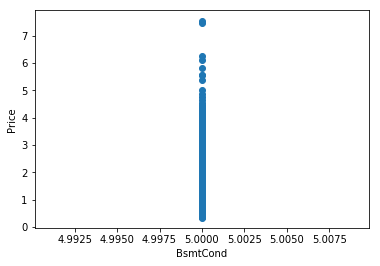

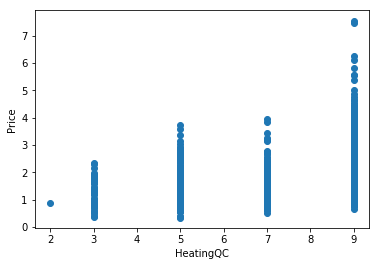

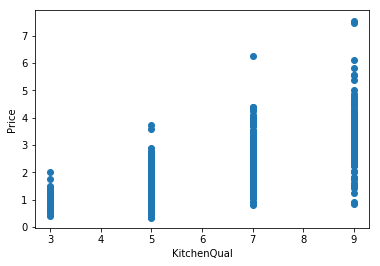

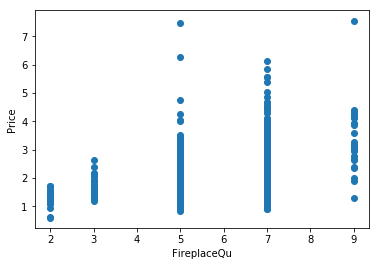

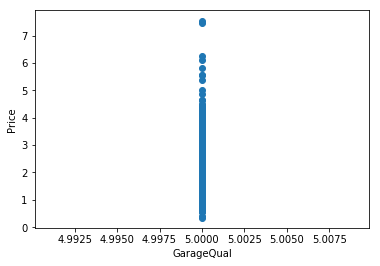

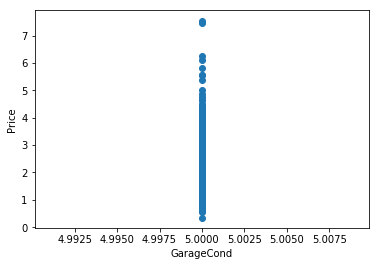

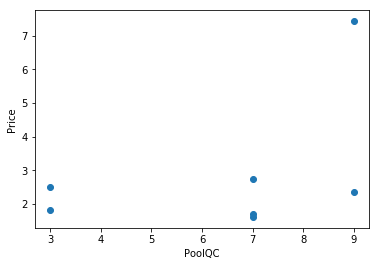

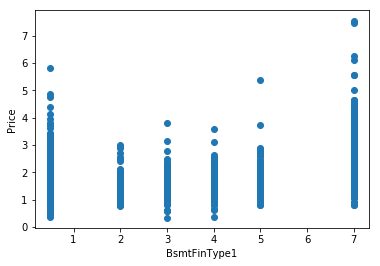

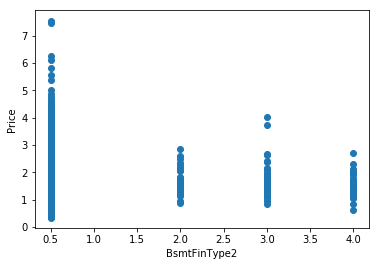

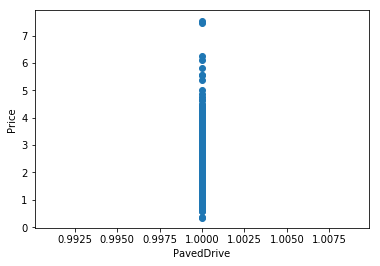

/Users/siyunwang/Desktop/Python_for_Data_Science/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2247: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/Users/siyunwang/Desktop/Python_for_Data_Science/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


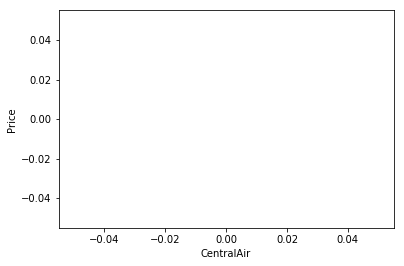

In [22]:
for feature in numericalFeatures:
    outliers_dropped = pd.concat([X.iloc[:1460][feature],Y], axis=1).dropna()
    outliers_dropped = outliers_dropped[outliers_dropped[feature]>0]
    outliers_dropped = outliers_dropped[abs(stats.zscore(outliers_dropped[feature])) < 3]
    plt.scatter(outliers_dropped[feature], outliers_dropped['SalePrice'])
    plt.ylabel('Price')
    plt.xlabel(feature)
    plt.show()

In [23]:
add_flag = ['MasVnrArea','BsmtFinSF1','BsmtFinSF2','2ndFlrSF','LowQualFinSF','GarageArea','WoodDeckSF',
            'OpenPorchSF','EnclosedPorch','ScreenPorch']

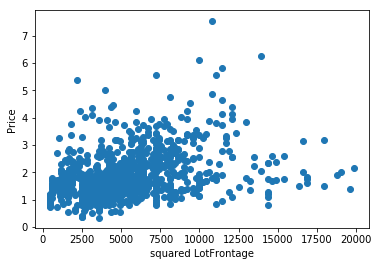

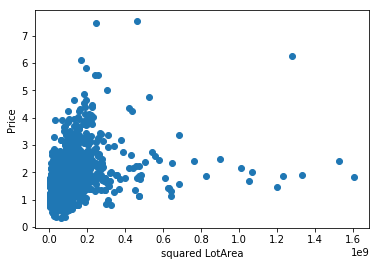

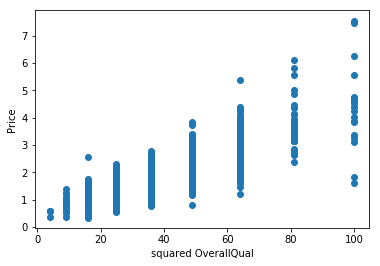

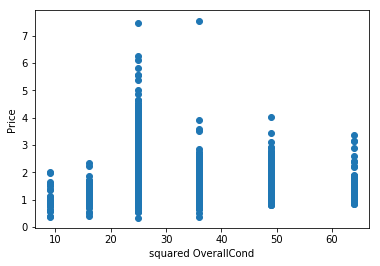

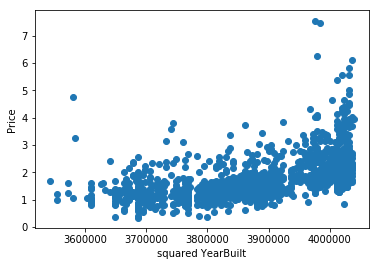

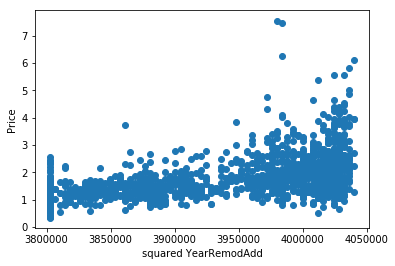

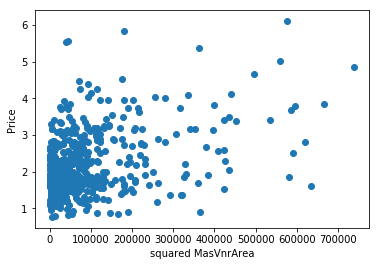

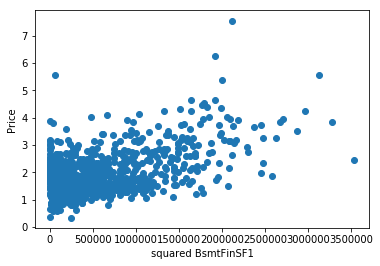

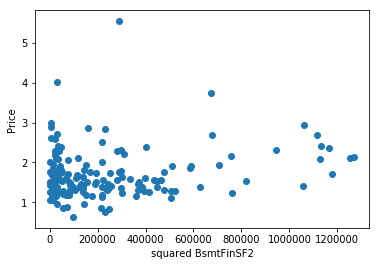

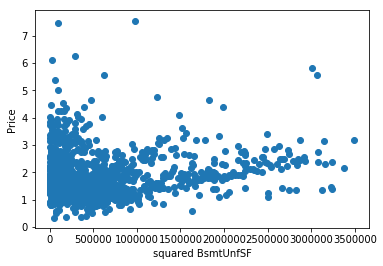

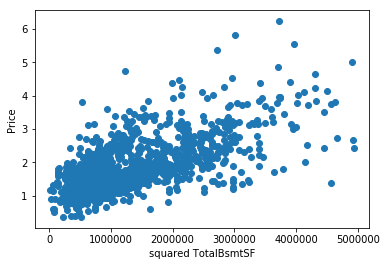

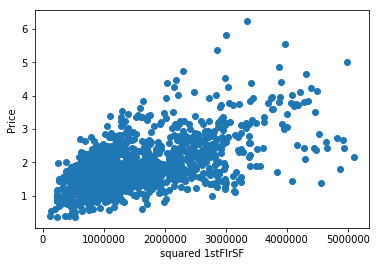

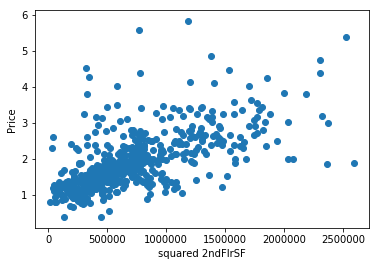

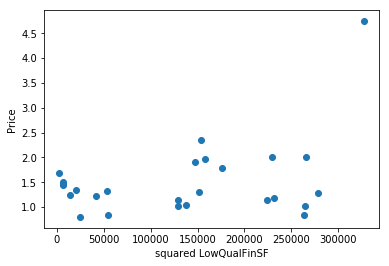

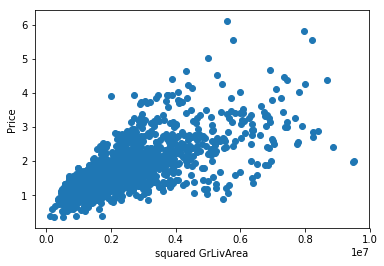

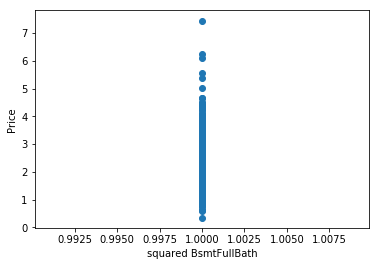

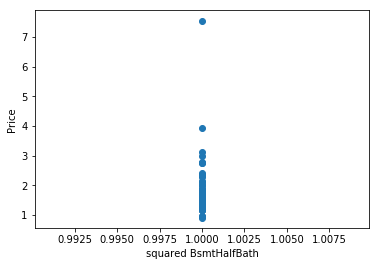

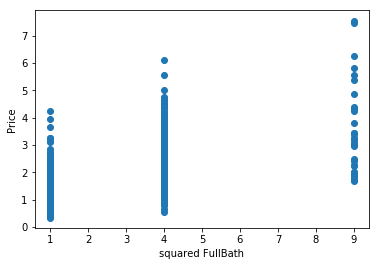

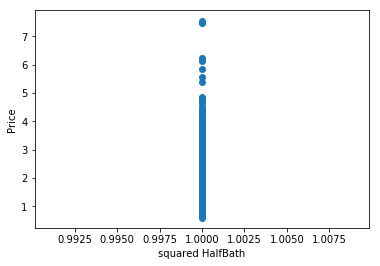

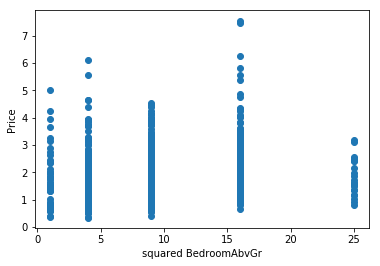

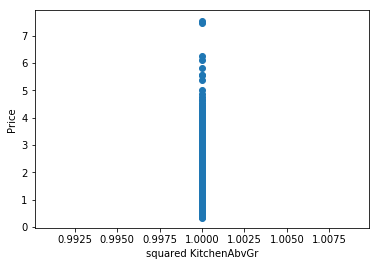

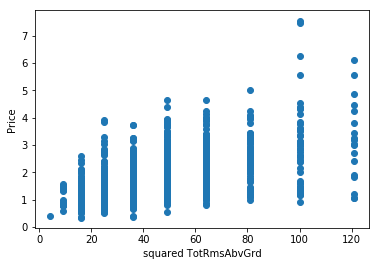

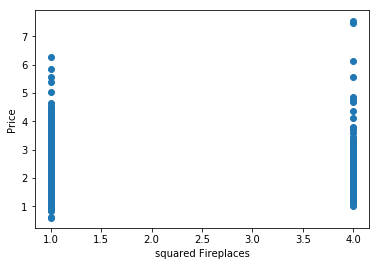

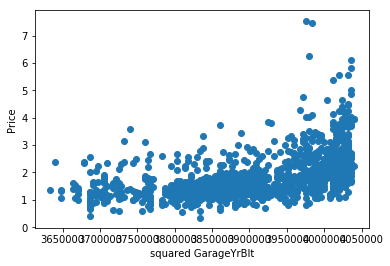

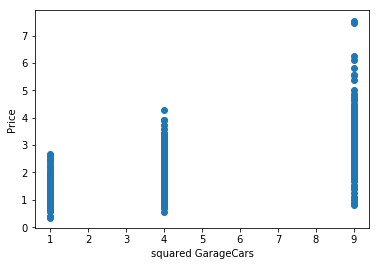

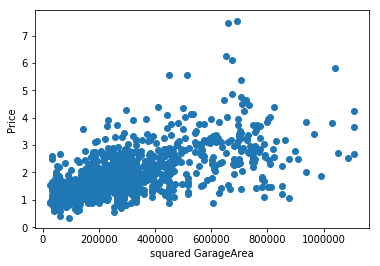

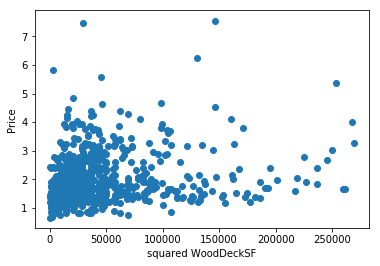

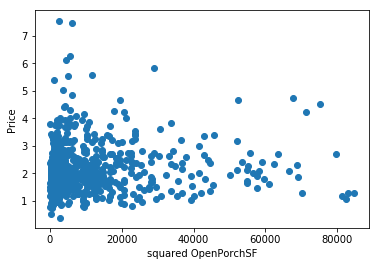

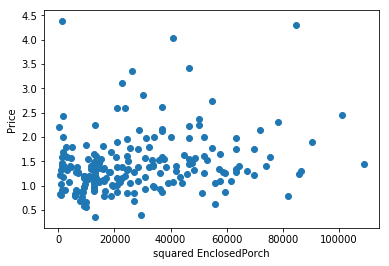

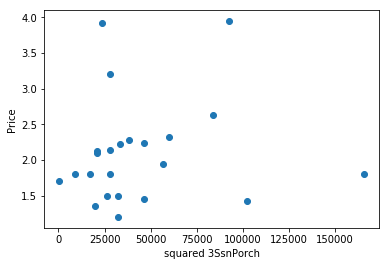

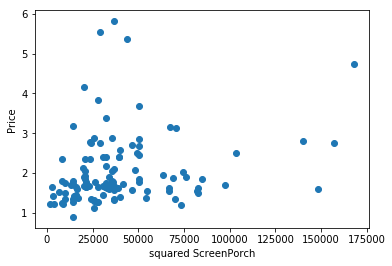

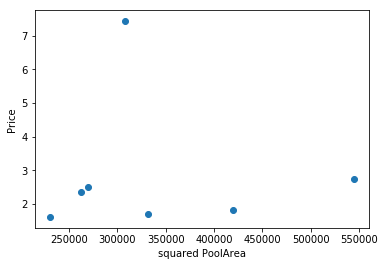

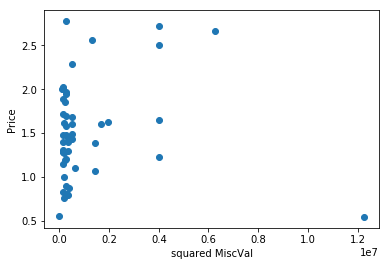

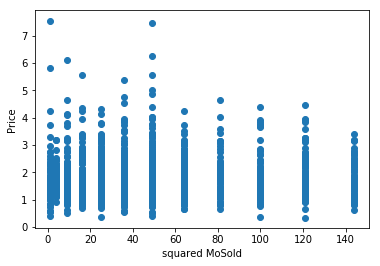

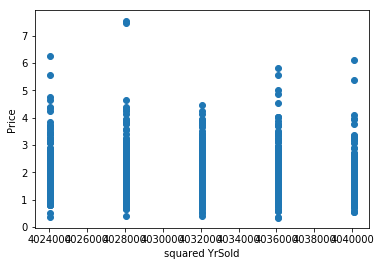

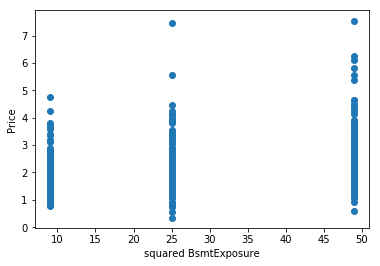

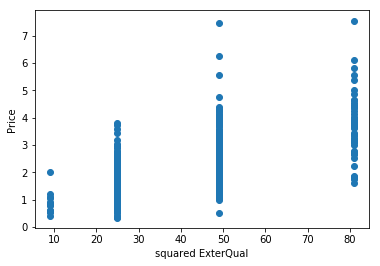

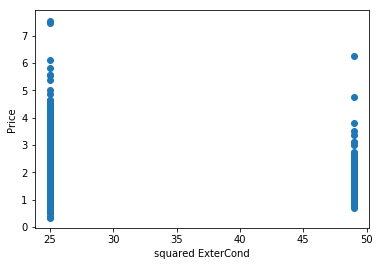

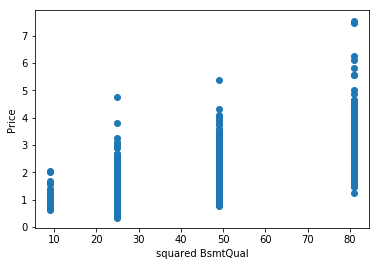

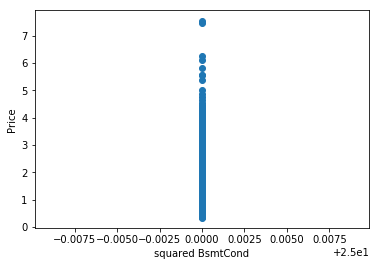

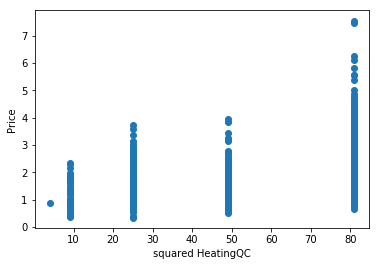

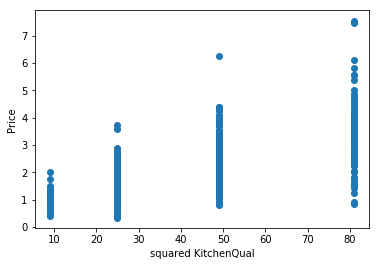

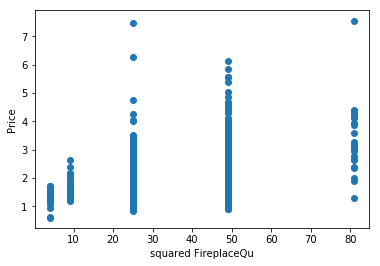

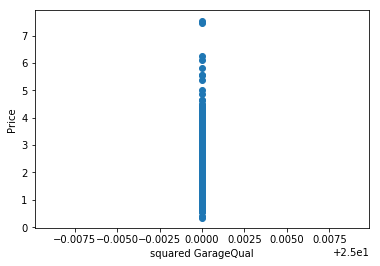

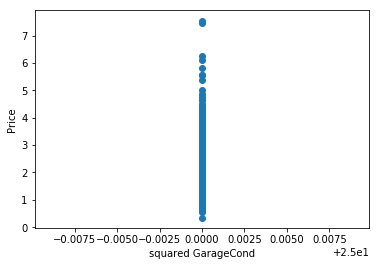

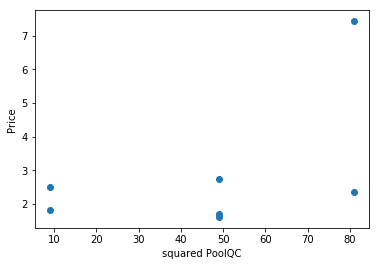

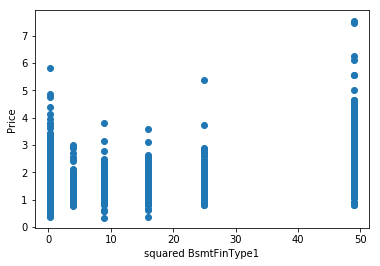

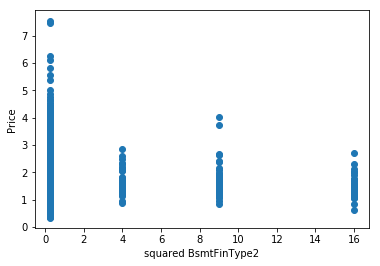

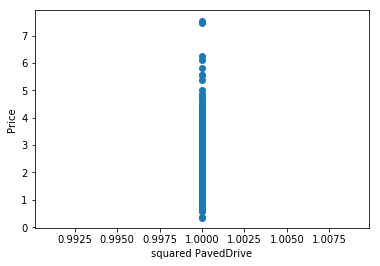

/Users/siyunwang/Desktop/Python_for_Data_Science/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2247: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/Users/siyunwang/Desktop/Python_for_Data_Science/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


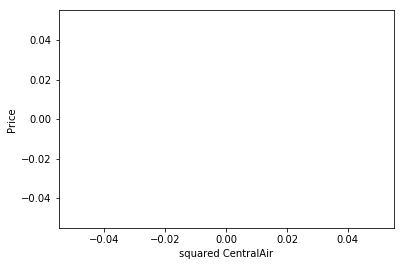

In [24]:
for feature in numericalFeatures:
    outliers_dropped = pd.concat([X.iloc[:1460][feature],Y], axis=1).dropna()
    outliers_dropped = outliers_dropped[outliers_dropped[feature]>0]
    outliers_dropped = outliers_dropped[abs(stats.zscore(outliers_dropped[feature])) < 3]
    plt.scatter((outliers_dropped[feature])**2, outliers_dropped['SalePrice'])
    plt.ylabel('Price')
    plt.xlabel('squared '+ feature)
    plt.show()

In [25]:
X['squaredOverallQual'] = X['OverallQual'] ** 2
numericalFeatures.append('squaredOverallQual')

X['squaredOverallCond'] = X['OverallCond'] ** 2
numericalFeatures.append('squaredOverallCond')

X['squaredBsmtUnfSF'] = X['BsmtUnfSF'] ** 2
numericalFeatures.append('squaredBsmtUnfSF')

X['squaredTotalBsmtSF'] = X['TotalBsmtSF'] ** 2
numericalFeatures.append('squaredTotalBsmtSF')

X['squared1stFlrSF'] = X['1stFlrSF'] ** 2
numericalFeatures.append('squared1stFlrSF')

X['squared2ndFlrSF'] = X['2ndFlrSF'] ** 2
numericalFeatures.append('squared2ndFlrSF')

X['squaredBsmtQual'] = X['BsmtQual'] ** 2
numericalFeatures.append('squaredBsmtQual')

X['squaredGarageArea'] = X['GarageArea'] ** 2
numericalFeatures.append('squaredGarageArea')

In [26]:
to_be_removed = []

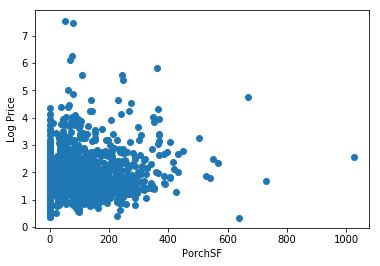

In [27]:
plt.scatter((X.iloc[:1460]['OpenPorchSF'] + X.iloc[:1460]['EnclosedPorch'] + X.iloc[:1460]['3SsnPorch'] + X.iloc[:1460]['ScreenPorch']), Y)
plt.ylabel('Log Price')
plt.xlabel('PorchSF')
plt.show()

In [28]:
to_be_removed.append('OpenPorchSF')
to_be_removed.append('EnclosedPorch')
to_be_removed.append('3SsnPorch')

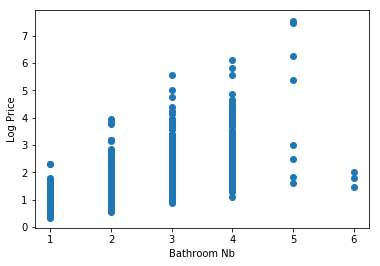

In [29]:
plt.scatter((X.iloc[:1460]['BsmtFullBath'] + X.iloc[:1460]['BsmtHalfBath'] + X.iloc[:1460]['FullBath'] + X.iloc[:1460]['HalfBath']), Y)
plt.ylabel('Log Price')
plt.xlabel('Bathroom Nb')
plt.show()

In [30]:
X['Baths'] = X['BsmtFullBath'] + X['BsmtHalfBath'] + X['FullBath'] + X['HalfBath'] 

to_be_removed.append('BsmtFullBath')
to_be_removed.append('BsmtHalfBath')
to_be_removed.append('HalfBath')

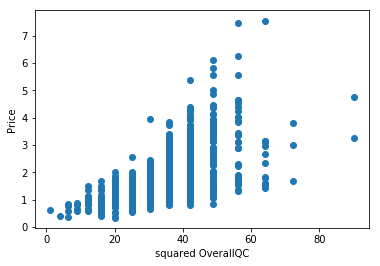

In [31]:
plt.scatter(((X.iloc[:1460]['OverallQual'] + X.iloc[:1460]['OverallCond']) / 2)**2, Y)
plt.ylabel('Price')
plt.xlabel('squared OverallQC')
plt.show()

In [32]:
X['squaredOverallQC'] = ((X['OverallQual'] + X['OverallCond']) / 2)**2

to_be_removed.append('OverallCond')
numericalFeatures.append('squaredOverallQC')

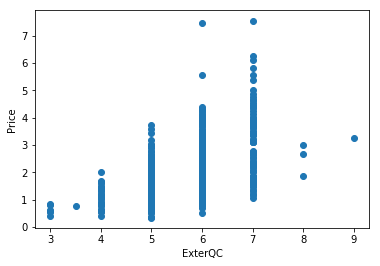

In [33]:
plt.scatter((X.iloc[:1460]['ExterQual'] + X.iloc[:1460]['ExterCond']) / 2, Y)
plt.ylabel('Price')
plt.xlabel('ExterQC')
plt.show()

In [34]:
X['ExterQC'] = (X['ExterQual'] + X['ExterCond']) / 2

to_be_removed.append('ExterCond')

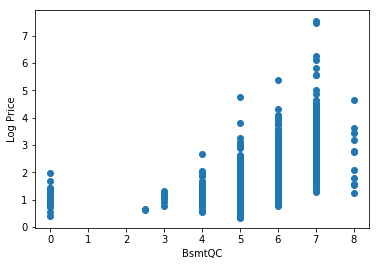

In [35]:
plt.scatter((X.iloc[:1460]['BsmtQual'] + X.iloc[:1460]['BsmtCond']) / 2, Y)
plt.ylabel('Log Price')
plt.xlabel('BsmtQC')
plt.show()

In [36]:
X['BsmtQC'] = (X['BsmtQual'] + X['BsmtCond']) / 2

to_be_removed.append('BsmtQual')
to_be_removed.append('BsmtCond')
add_flag.append('BsmtQC')

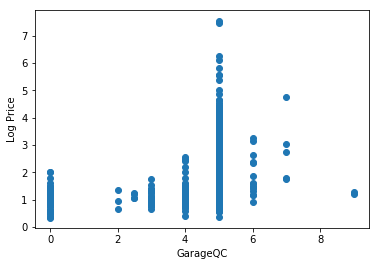

In [37]:
plt.scatter((X.iloc[:1460]['GarageQual'] + X.iloc[:1460]['GarageCond']) / 2, Y)
plt.ylabel('Log Price')
plt.xlabel('GarageQC')
plt.show()

In [38]:
X['GarageQC'] = (X['GarageQual'] + X['GarageCond']) / 2

to_be_removed.append('GarageCond')
to_be_removed.append('GarageQual')

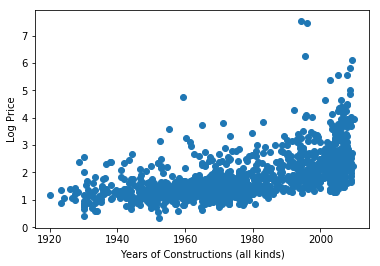

In [39]:
plt.scatter((X.iloc[:1460]['YearBuilt'] + X.iloc[:1460]['YearRemodAdd'] + X.iloc[:1460]['GarageYrBlt']) / 3, Y)
plt.ylabel('Log Price')
plt.xlabel('Years of Constructions (all kinds)')
plt.show()

In [40]:
X['YrConstructions'] = (X['YearBuilt'] + X['YearRemodAdd'] + X['GarageYrBlt']) / 3

to_be_removed.append('YearBuilt')
to_be_removed.append('YearRemodAdd')
to_be_removed.append('GarageYrBlt')
numericalFeatures.append('YrConstructions')

X['YrConstructions'].fillna(0, inplace=True)

In [41]:
rslt1 = X['BsmtFinSF1'] + X['BsmtFinSF2'] + X['BsmtUnfSF'] - X['TotalBsmtSF']
rslt1.describe()

count    2918.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
dtype: float64

In [42]:
to_be_removed.append('BsmtFinSF2')
to_be_removed.append('BsmtUnfSF')

In [43]:
rslt2 = X['1stFlrSF'] + X['2ndFlrSF'] + X['LowQualFinSF'] - X['GrLivArea']
rslt2.describe()

count    2919.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
dtype: float64

In [44]:
to_be_removed.append('2ndFlrSF')
to_be_removed.append('LowQualFinSF')

In [45]:
# Cov(GarageCars, GarageArea) > 0.8
to_be_removed.append('GarageCars')

In [46]:
to_be_removed.append('YrSold')
to_be_removed.append('MoSold')

In [47]:
to_be_removed = list(set(to_be_removed + suspiciousNumFeatures))
X.drop(labels=to_be_removed, axis=1, inplace=True)

In [48]:
X['LotFrontage'].fillna(0, inplace=True)

In [49]:
X['MasVnrArea'].fillna(0, inplace=True)

In [50]:
to_be_removed

['ExterCond',
 'BsmtCond',
 'BsmtFinType2',
 'GarageQual',
 'GarageCond',
 'BsmtUnfSF',
 'HalfBath',
 'BsmtExposure',
 'MiscVal',
 '2ndFlrSF',
 'KitchenAbvGr',
 'BsmtFullBath',
 'OpenPorchSF',
 '3SsnPorch',
 'PoolArea',
 'Fireplaces',
 'YearRemodAdd',
 'MoSold',
 'OverallCond',
 'GarageCars',
 'GarageYrBlt',
 'BsmtQual',
 'YearBuilt',
 'BsmtFinSF2',
 'LowQualFinSF',
 'BedroomAbvGr',
 'PoolQC',
 'EnclosedPorch',
 'BsmtFinType1',
 'BsmtHalfBath',
 'YrSold']

In [51]:
numericalFeatures

['LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'BsmtExposure',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'HeatingQC',
 'KitchenQual',
 'FireplaceQu',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'BsmtFinType1',
 'BsmtFinType2',
 'PavedDrive',
 'CentralAir',
 'squaredOverallQual',
 'squaredOverallCond',
 'squaredBsmtUnfSF',
 'squaredTotalBsmtSF',
 'squared1stFlrSF',
 'squared2ndFlrSF',
 'squaredBsmtQual',
 'squaredGarageArea',
 'squaredOverallQC',
 'YrConstructions']

In [52]:
for feature in list(set(numericalFeatures)^set(to_be_removed)):
    m = X[feature].min(axis=0)
    M = X[feature].max(axis=0)
    X[feature] = 5 * (X[feature] - m) / (M - m)

In [53]:
for feature in (set(add_flag) - set(to_be_removed)):
    X[feature].fillna(0, inplace=True)   
    X[feature + 'Is0'] = (X[feature] == 0)

In [54]:
X.head()

MSZoning  LotFrontage   LotArea Street Alley LotShape LandContour  \
Id                                                                     
1        RL     1.038339  0.167099   Pave   NaN      Reg         Lvl   
2        RL     1.277955  0.193975   Pave   NaN      Reg         Lvl   
3        RL     1.086262  0.232536   Pave   NaN      IR1         Lvl   
4        RL     0.958466  0.192807   Pave   NaN      IR1         Lvl   
5        RL     1.341853  0.302882   Pave   NaN      IR1         Lvl   

   Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType  \
Id                                                                             
1     AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam   
2     AllPub       FR2       Gtl      Veenker      Feedr       Norm     1Fam   
3     AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam   
4     AllPub    Corner       Gtl      Crawfor       Norm       Norm     1Fam   
5     AllPub       FR2       Gtl      NoRidge       Norm       Norm     1Fam   

   HouseStyle  OverallQual RoofStyle RoofMatl Exterior1st Exterior2nd  \
Id                                                                      
1      2Story     3.333333     Gable  CompShg     VinylSd     VinylSd   
2      1Story     2.777778     Gable  CompShg     MetalSd     MetalSd   
3      2Story     3.333333     Gable  CompShg     VinylSd     VinylSd   
4      2Story     3.333333     Gable  CompShg     Wd Sdng     WdShing   
5      2Story     3.888889     Gable  CompShg     VinylSd     VinylSd   

   MasVnrType  MasVnrArea  ExterQual Foundation  BsmtFinSF1  TotalBsmtSF  \
Id                                                                         
1     BrkFace     0.61250   3.333333      PConc    0.625443     0.700491   
2        None     0.00000   1.666667     CBlock    0.866407     1.032733   
3     BrkFace     0.50625   3.333333      PConc    0.430546     0.752864   
4        None     0.00000   1.666667     BrkTil    0.191354     0.618658   
5     BrkFace     1.09375   3.333333      PConc    0.580262     0.936989   

   Heating  HeatingQC  CentralAir Electrical  1stFlrSF  GrLivArea  FullBath  \
Id                                                                            
1     GasA   5.000000         5.0      SBrkr  0.548204   1.296157      2.50   
2     GasA   5.000000         5.0      SBrkr  0.974585   0.874152      2.50   
3     GasA   5.000000         5.0      SBrkr  0.615417   1.367747      2.50   
4     GasA   3.571429         5.0      SBrkr  0.658475   1.302751      1.25   
5     GasA   5.000000         5.0      SBrkr  0.851712   1.755840      2.50   

    KitchenQual  TotRmsAbvGrd Functional  FireplaceQu GarageType GarageFinish  \
Id                                                                              
1      3.888889      2.307692        Typ     0.000000     Attchd          RFn   
2      2.777778      1.538462        Typ     2.777778     Attchd          RFn   
3      3.888889      1.538462        Typ     2.777778     Attchd          RFn   
4      3.888889      1.923077        Typ     3.888889     Detchd          Unf   
5      3.888889      2.692308        Typ     2.777778     Attchd          RFn   

    GarageArea  PavedDrive  WoodDeckSF  ScreenPorch Fence MiscFeature  \
Id                                                                      
1     1.841398         5.0    0.000000          0.0   NaN         NaN   
2     1.545699         5.0    1.046348          0.0   NaN         NaN   
3     2.043011         5.0    0.000000          0.0   NaN         NaN   
4     2.157258         5.0    0.000000          0.0   NaN         NaN   
5     2.809140         5.0    0.674157          0.0   NaN         NaN   

   SaleType SaleCondition  squaredOverallQual  squaredOverallCond  \
Id                                                                  
1        WD        Normal            2.424242              1.5000   
2        WD        Normal            1.767677      

In [55]:
X.describe()

LotFrontage      LotArea  OverallQual   MasVnrArea    ExterQual  \
count  2919.000000  2919.000000  2919.000000  2919.000000  2919.000000   
mean      0.922791     0.207252     2.827262     0.316863     2.327852   
std       0.534850     0.184323     0.783304     0.558921     0.967156   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.686901     0.144383     2.222222     0.000000     1.666667   
50%       1.006390     0.190540     2.777778     0.000000     1.666667   
75%       1.246006     0.240015     3.333333     0.510938     3.333333   
max       5.000000     5.000000     5.000000     5.000000     5.000000   

        BsmtFinSF1  TotalBsmtSF    HeatingQC   CentralAir     1stFlrSF  \
count  2919.000000  2918.000000  2919.000000  2919.000000  2919.000000   
mean      0.390921     0.860702     3.788969     4.664269     0.867026   
std       0.403620     0.360693     1.366277     1.251590     0.412058   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.648936     2.142857     5.000000     0.569208   
50%       0.326010     0.809738     5.000000     5.000000     0.785549   
75%       0.649362     1.065466     5.000000     5.000000     1.106385   
max       5.000000     5.000000     5.000000     5.000000     5.000000   

         GrLivArea     FullBath  KitchenQual  TotRmsAbvGrd  FireplaceQu  \
count  2919.000000  2919.000000  2919.000000   2919.000000  2919.000000   
mean      1.099058     1.960003     3.344372      1.712125     1.687983   
std       0.476687     0.691212     0.738259      0.603607     1.740541   
min       0.000000     0.000000     0.000000      0.000000     0.000000   
25%       0.746044     1.250000     2.777778      1.153846     0.000000   
50%       1.045592     2.500000     2.777778      1.538462     1.111111   
75%       1.327713     2.500000     3.888889      1.923077     3.888889   
max       5.000000     5.000000     5.000000      5.000000     5.000000   

        GarageArea   PavedDrive   WoodDeckSF  ScreenPorch  squaredOverallQual  \
count  2919.000000  2919.000000  2919.000000  2919.000000         2919.000000   
mean      1.588416     4.576910     0.329037     0.139430            1.922427   
std       0.724246     1.343247     0.444265     0.487712            0.898422   
min       0.000000     0.000000     0.000000     0.000000            0.000000   
25%       1.075269     5.000000     0.000000     0.000000            1.212121   
50%       1.612903     5.000000     0.000000     0.000000            1.767677   
75%       1.935484     5.000000     0.589888     0.000000            2.424242   
max       5.000000     5.000000     5.000000     5.000000            5.000000   

       squaredOverallCond  squaredBsmtUnfSF  squaredTotalBsmtSF  \
count         2919.000000       2918.000000         2918.000000   
mean             1.950197          0.465098            0.174172   
std              0.829876          0.652865            0.174543   
min              0.000000          0.000000            0.000000   
25%              1.500000          0.044348            0.084224   
50%              1.500000          0.199829            0.131135   
75%              2.187500          0.594506            0.227044   
max              5.000000          5.000000            5.000000   

       squared1stFlrSF  squared2ndFlrSF  squaredBsmtQual  squaredGarageArea  \
count      2919.000000      2919.000000      2919.000000        2918.000000   
mean          0.268299         0.348180         2.389750           0.609692   
std           0.233060         0.559664         1.159539           0.516796   
min           0.000000         0.000000         0.000000           0.000000   
25%           0.126863         0.000000         1.543210           0.231241   
50%           0.204888         0.000000         3.024691           0.520291   
75%           0.350827         0.581133         3.024691           0.749220   
max           5.000000         

In [56]:
X.shape

(2919, 67)

## Categorical features

In [57]:
neighborhood_related = []

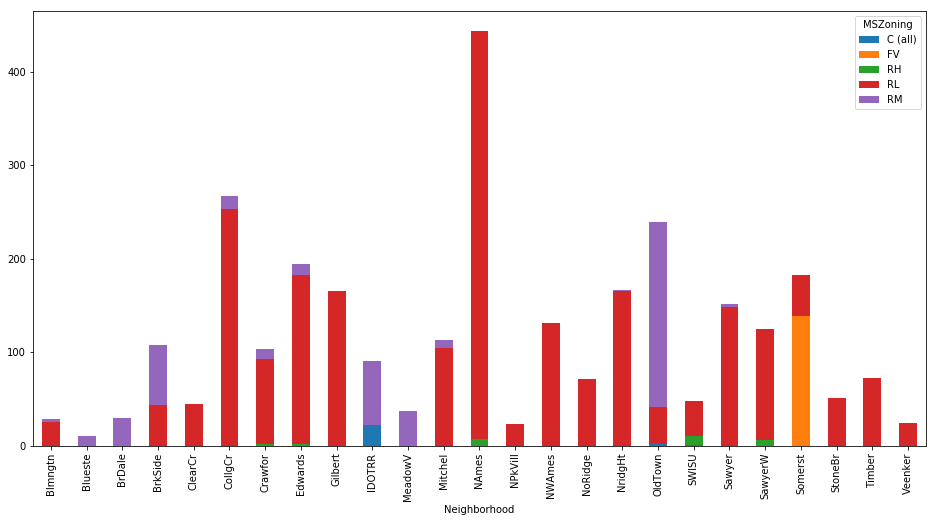

Feature: MSZoning: Chi2 value: 5011.0907, p value: 0.0000.


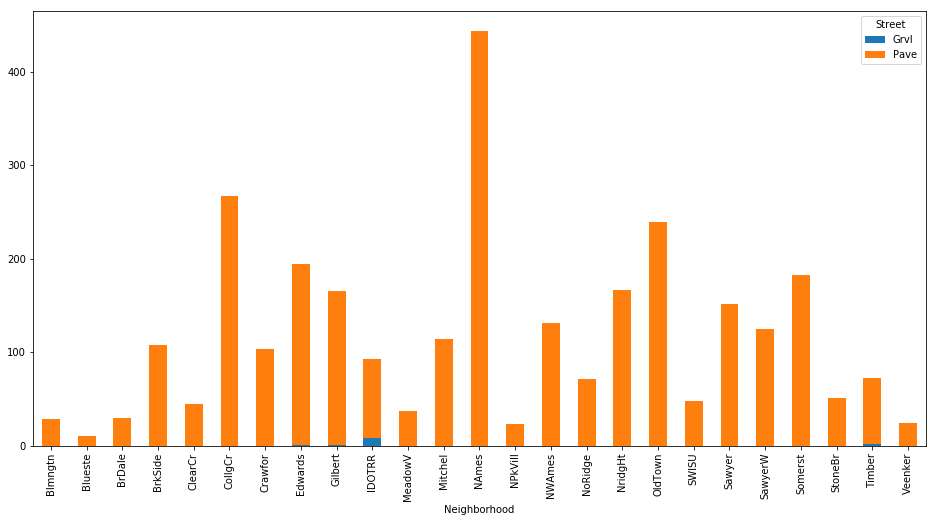

Feature: Street: Chi2 value: 172.3484, p value: 0.0000.


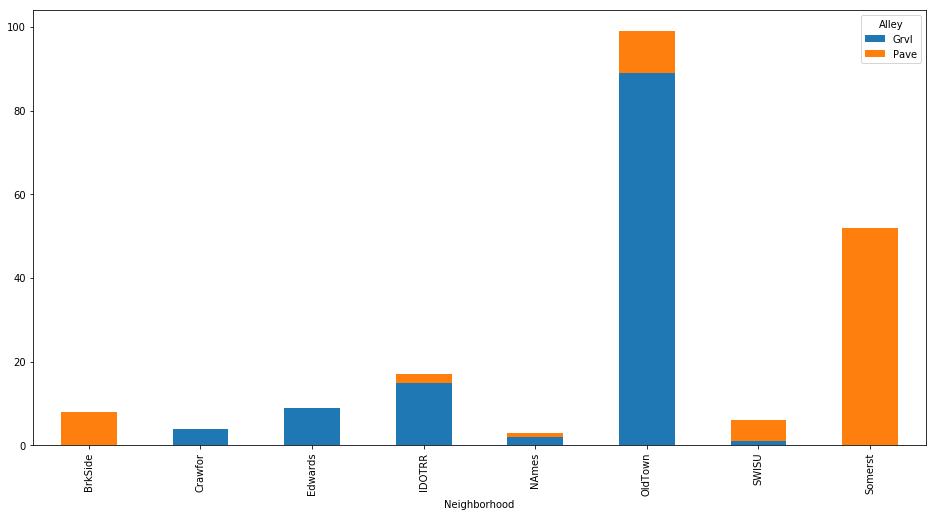

Feature: Alley: Chi2 value: 146.6721, p value: 0.0000.


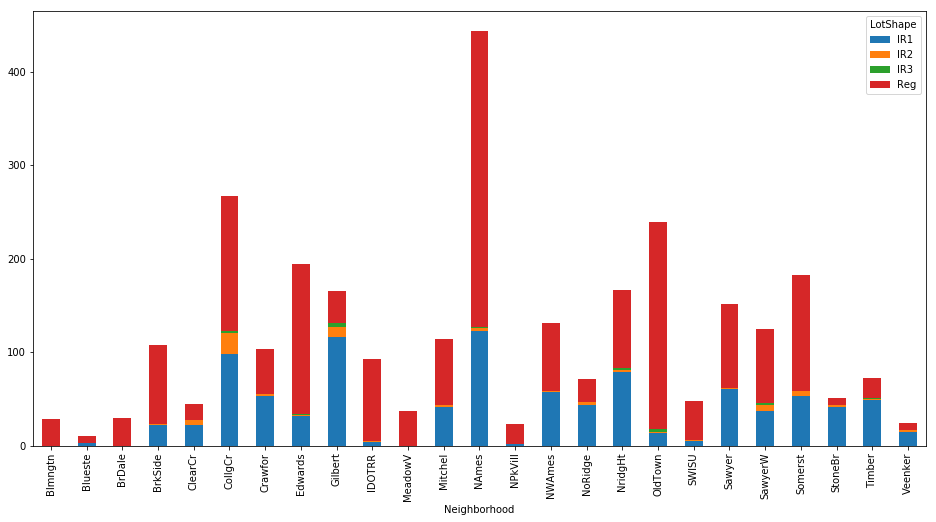

Feature: LotShape: Chi2 value: 655.7366, p value: 0.0000.


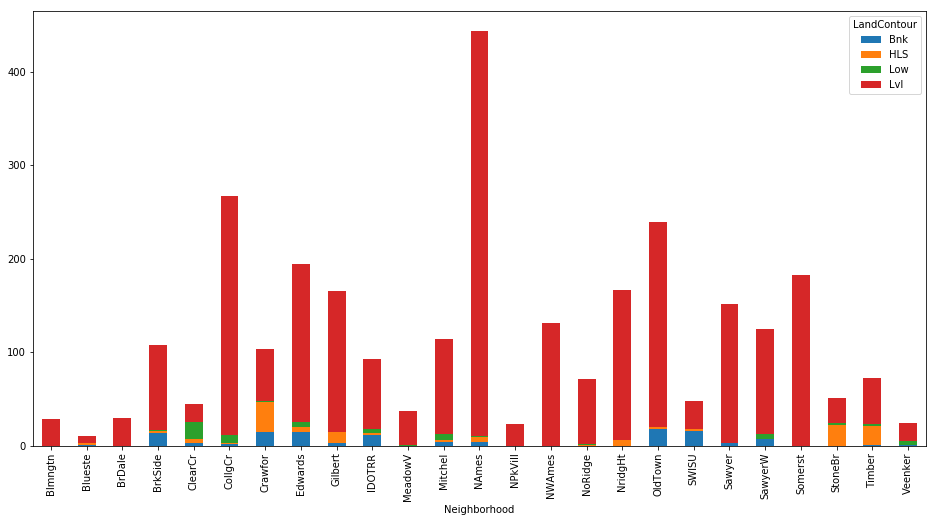

Feature: LandContour: Chi2 value: 1223.3228, p value: 0.0000.


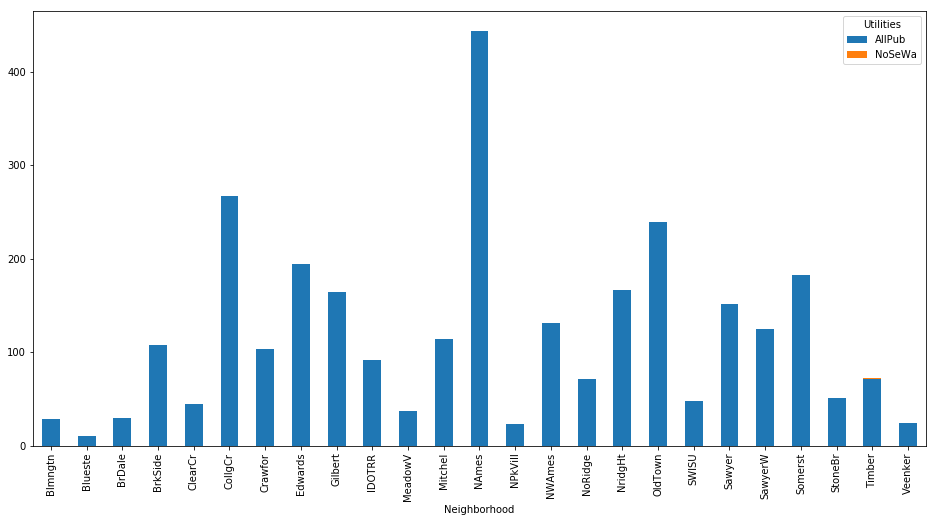

Feature: Utilities: Chi2 value: 39.5274, p value: 0.0240.


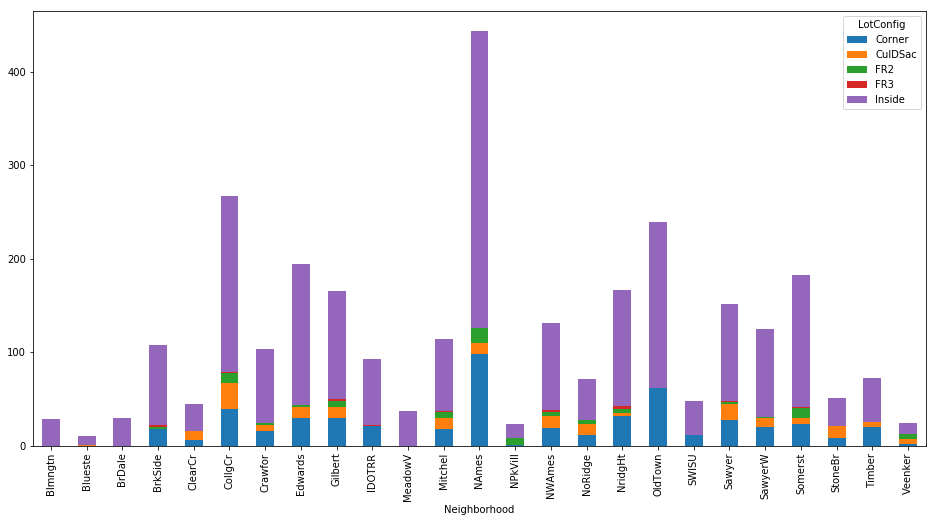

Feature: LotConfig: Chi2 value: 364.0788, p value: 0.0000.


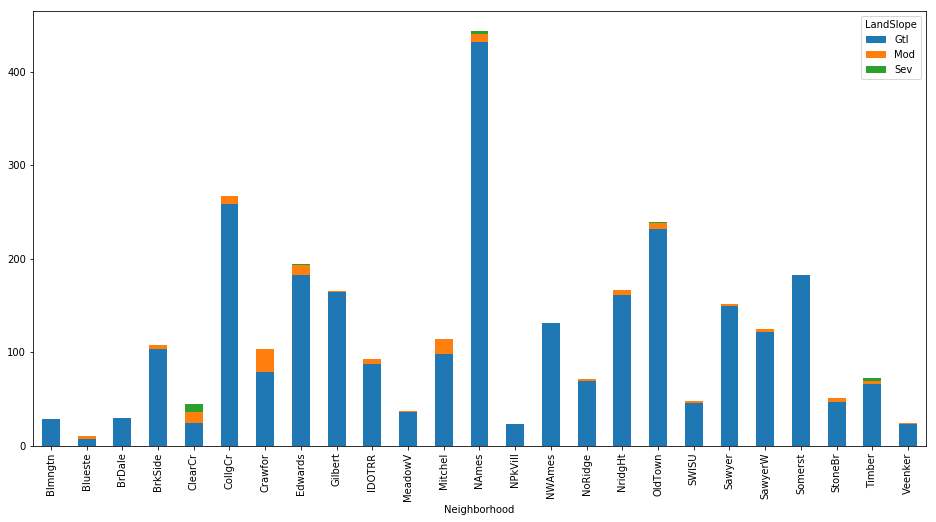

Feature: LandSlope: Chi2 value: 513.6408, p value: 0.0000.


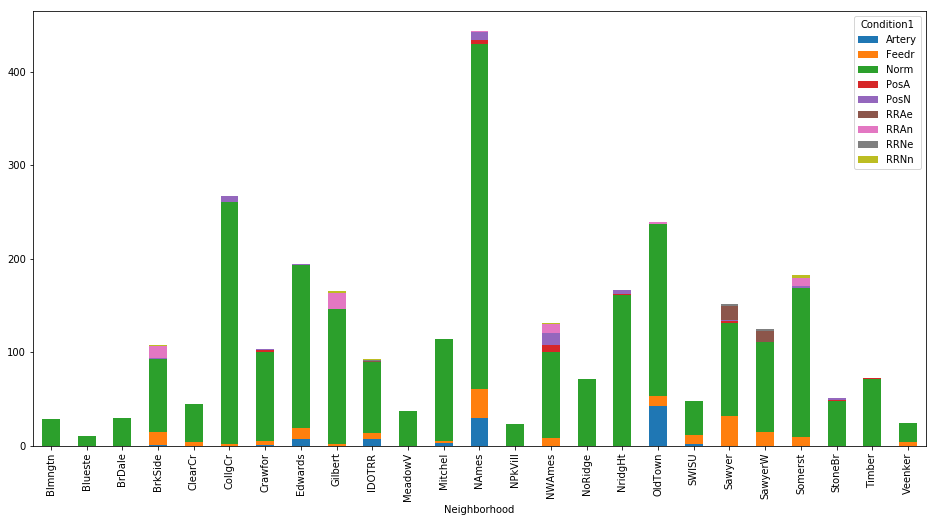

Feature: Condition1: Chi2 value: 1098.1813, p value: 0.0000.


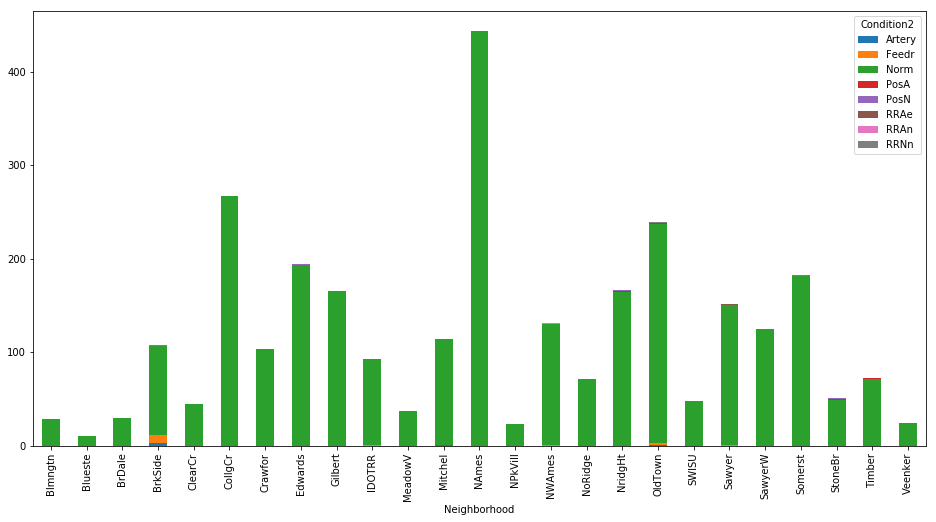

Feature: Condition2: Chi2 value: 289.5980, p value: 0.0000.


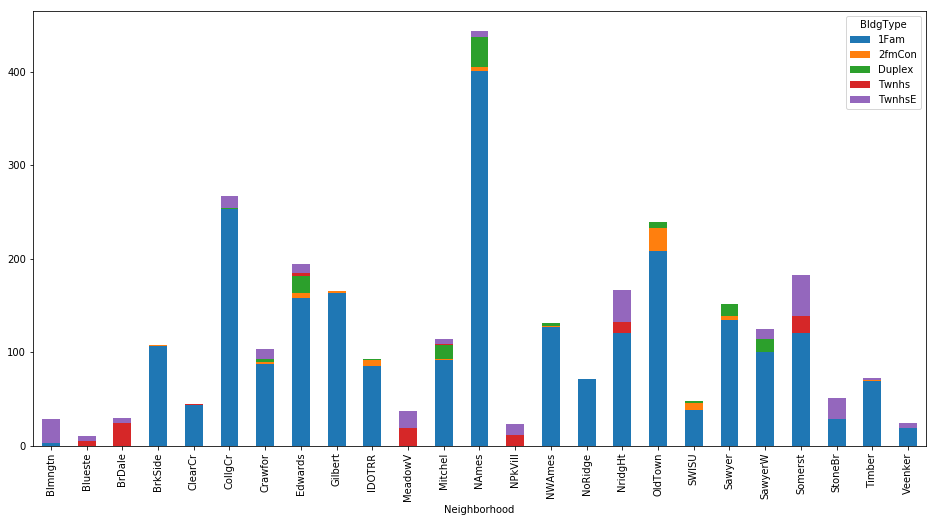

Feature: BldgType: Chi2 value: 2250.2767, p value: 0.0000.


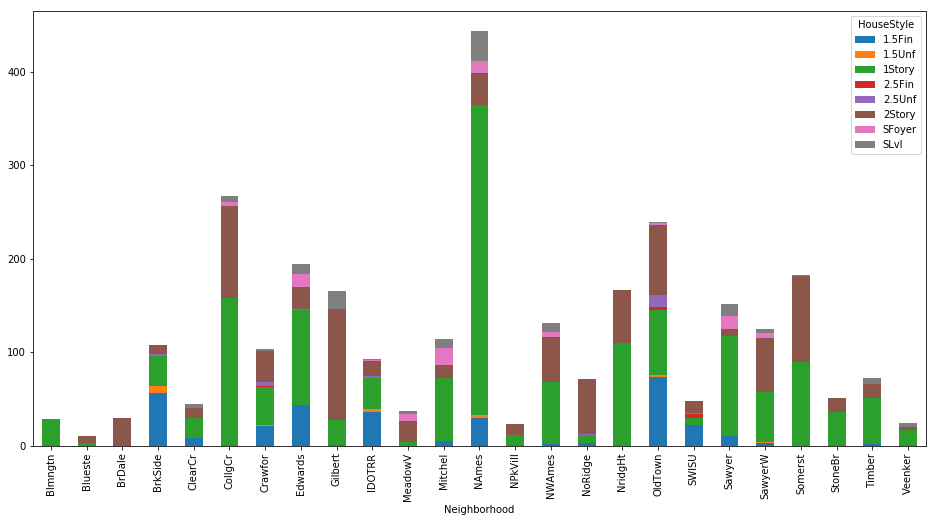

Feature: HouseStyle: Chi2 value: 1851.3600, p value: 0.0000.


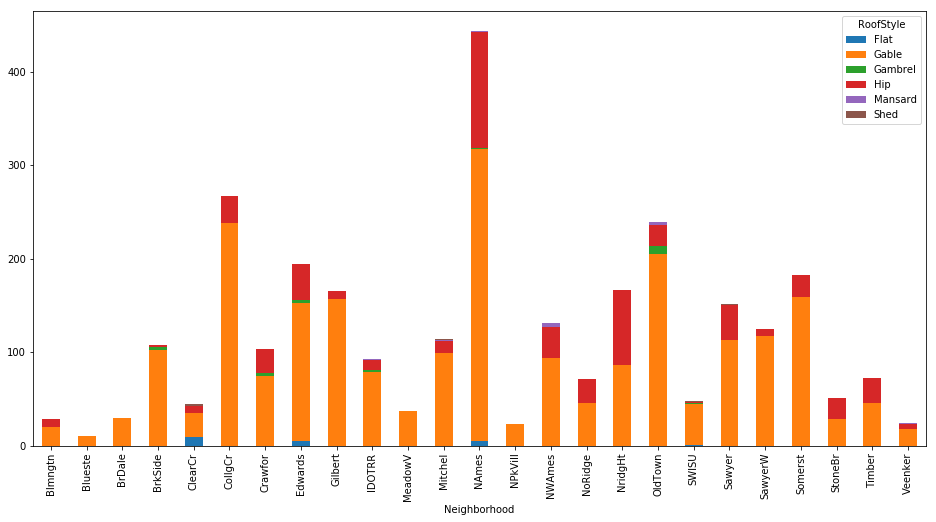

Feature: RoofStyle: Chi2 value: 754.0037, p value: 0.0000.


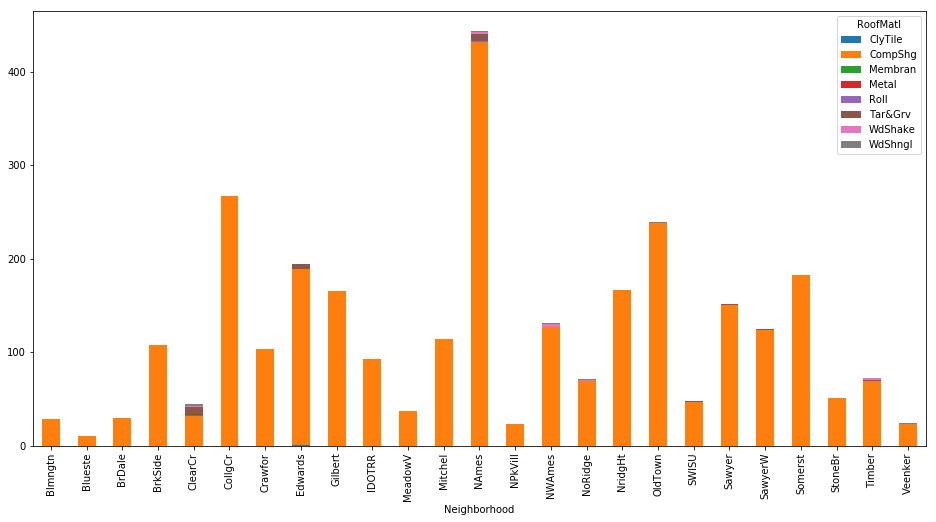

Feature: RoofMatl: Chi2 value: 415.0376, p value: 0.0000.


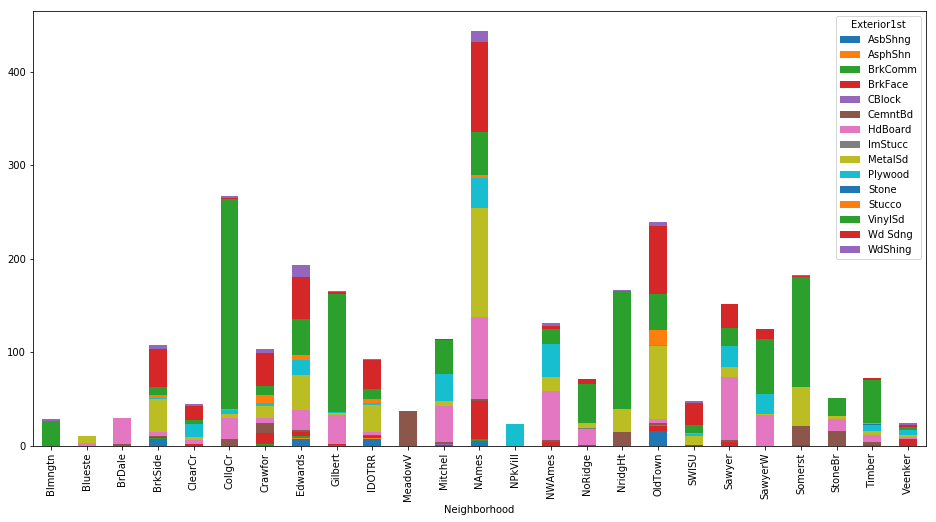

Feature: Exterior1st: Chi2 value: 3906.5735, p value: 0.0000.


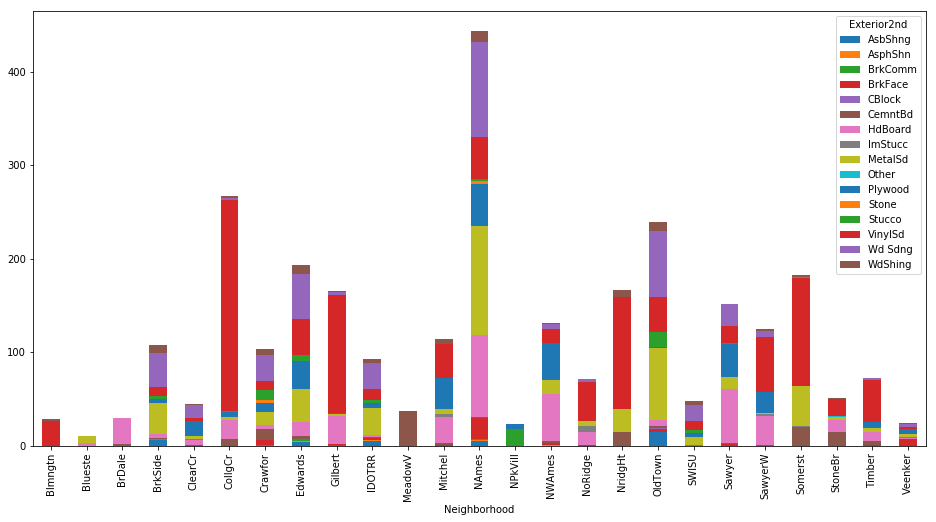

Feature: Exterior2nd: Chi2 value: 5585.1873, p value: 0.0000.


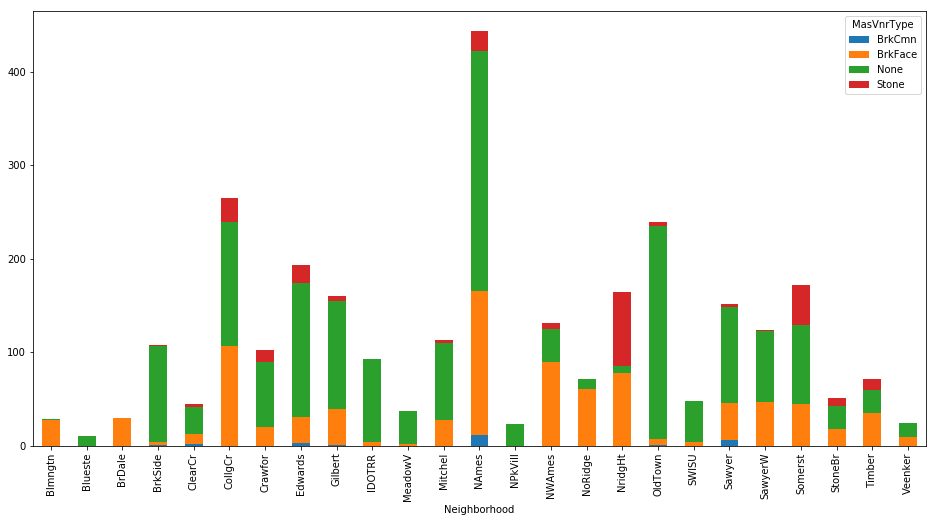

Feature: MasVnrType: Chi2 value: 1234.7502, p value: 0.0000.


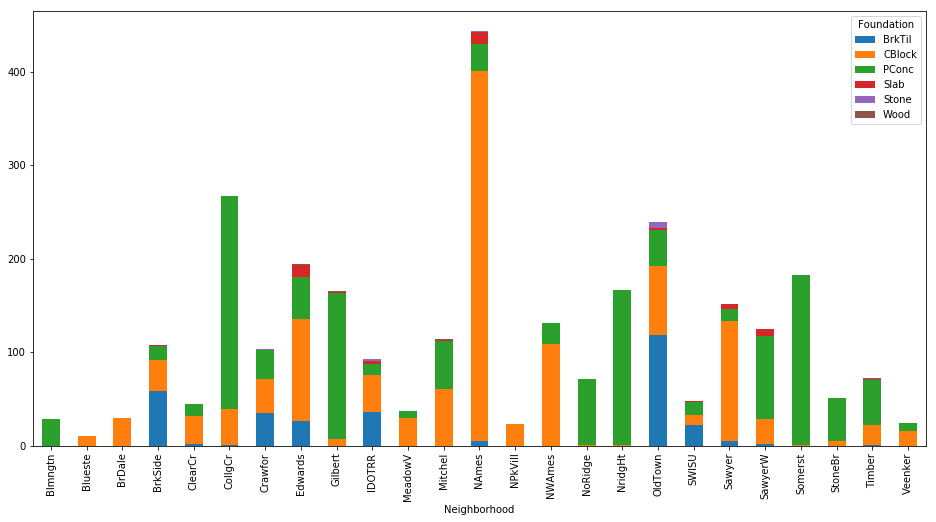

Feature: Foundation: Chi2 value: 2746.6180, p value: 0.0000.


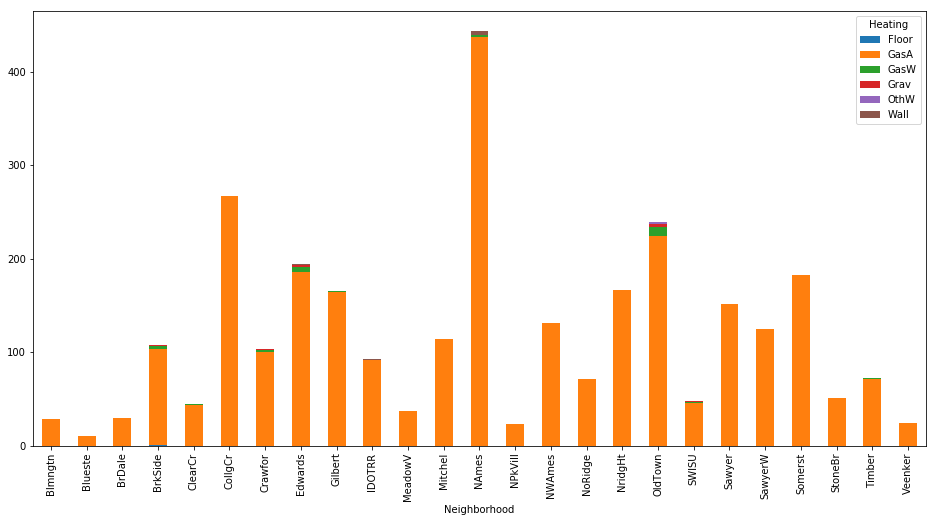

Feature: Heating: Chi2 value: 155.2307, p value: 0.0168.


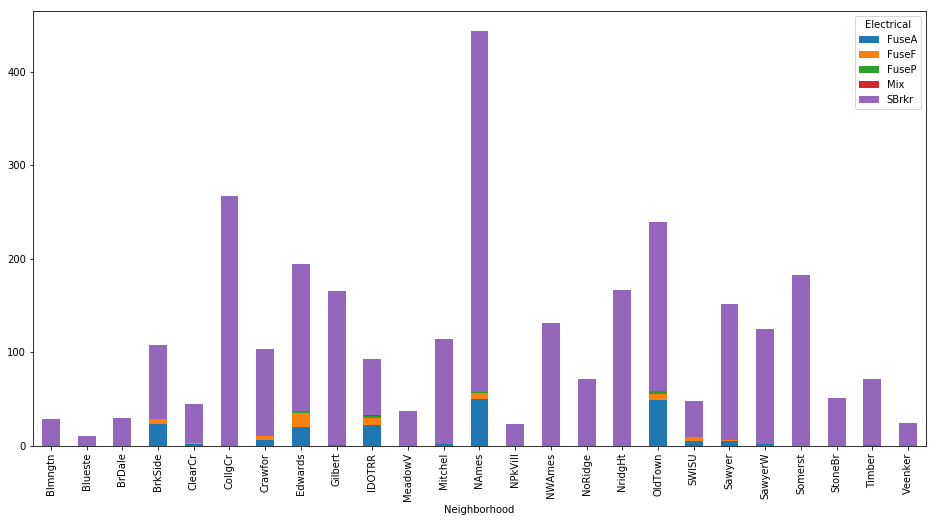

Feature: Electrical: Chi2 value: 470.8973, p value: 0.0000.


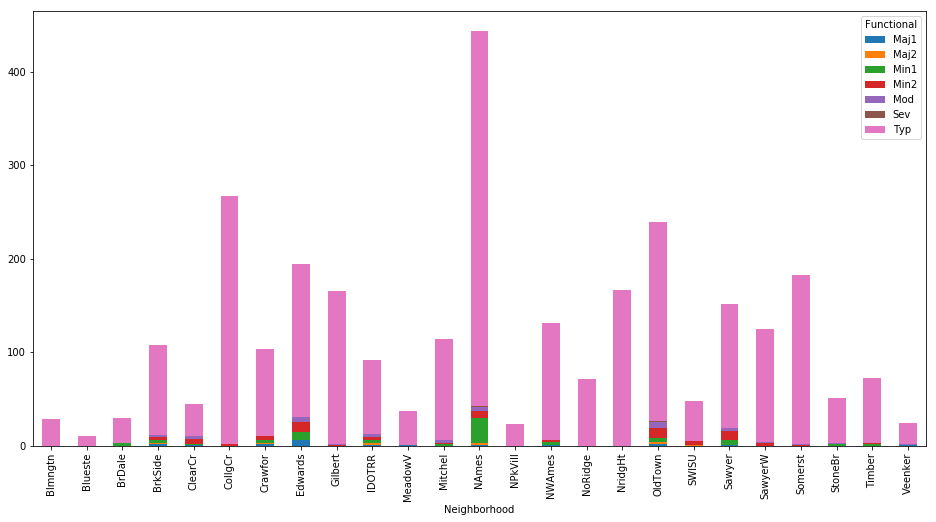

Feature: Functional: Chi2 value: 262.2919, p value: 0.0000.


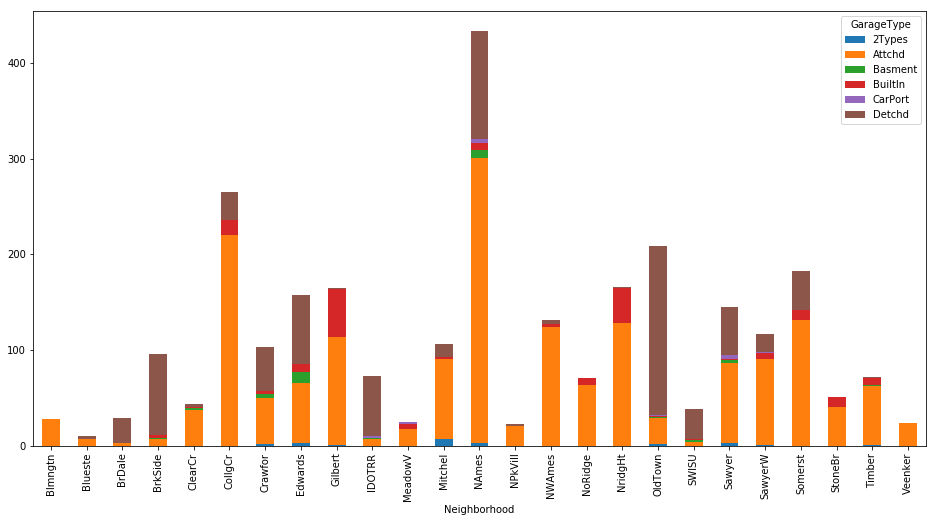

Feature: GarageType: Chi2 value: 1593.0331, p value: 0.0000.


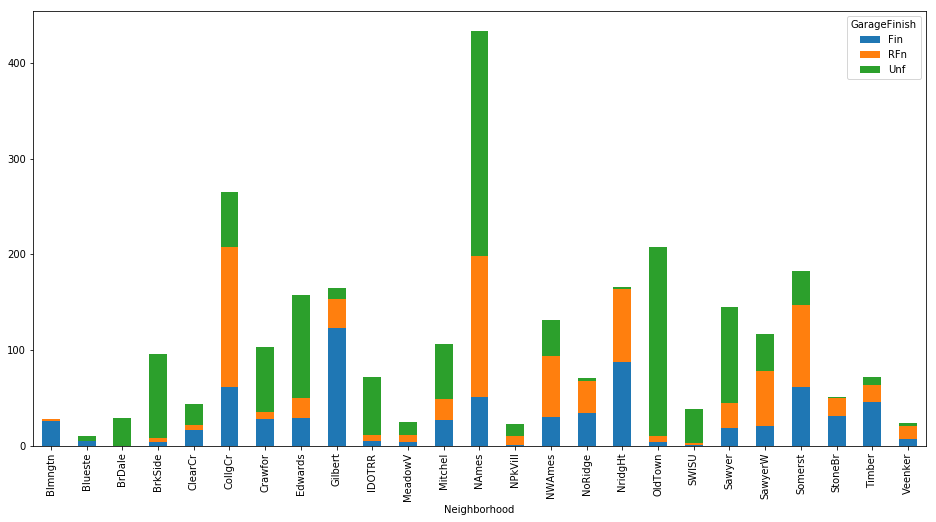

Feature: GarageFinish: Chi2 value: 1344.1754, p value: 0.0000.


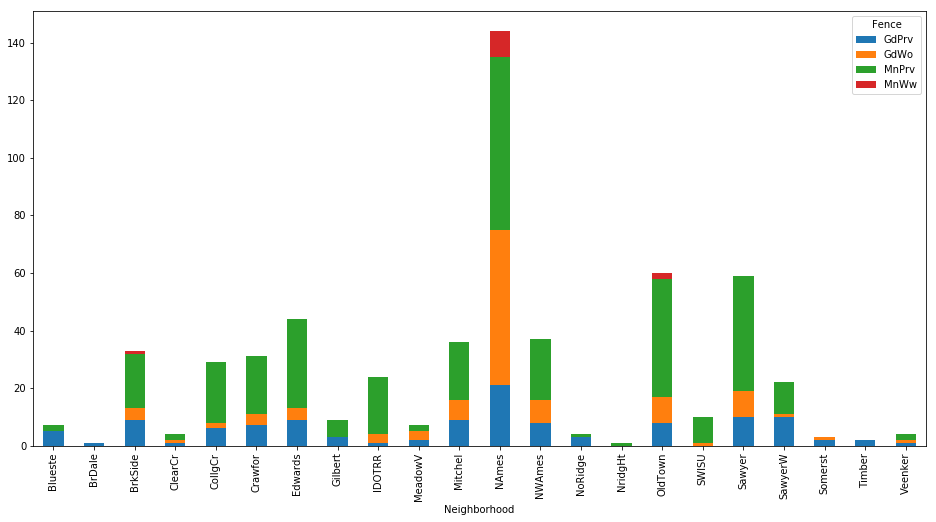

Feature: Fence: Chi2 value: 129.4414, p value: 0.0000.


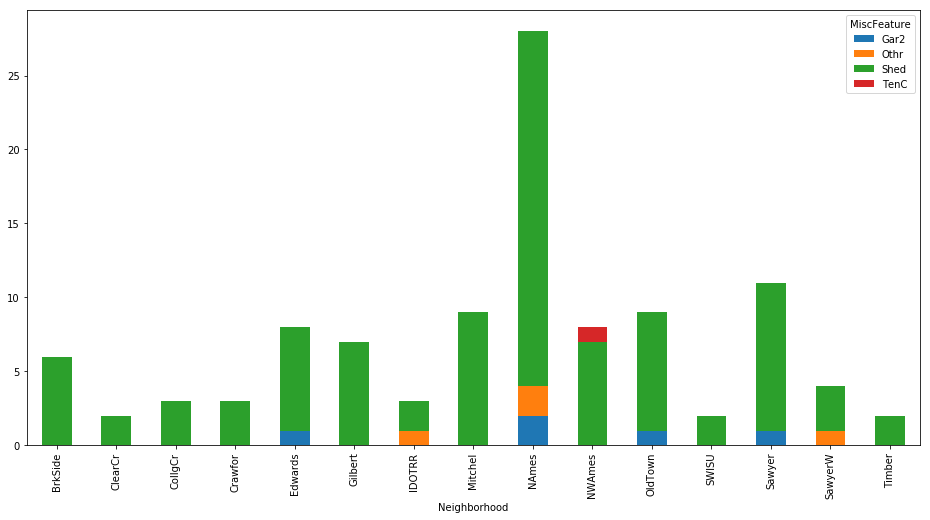

Feature: MiscFeature: Chi2 value: 32.7782, p value: 0.8454.


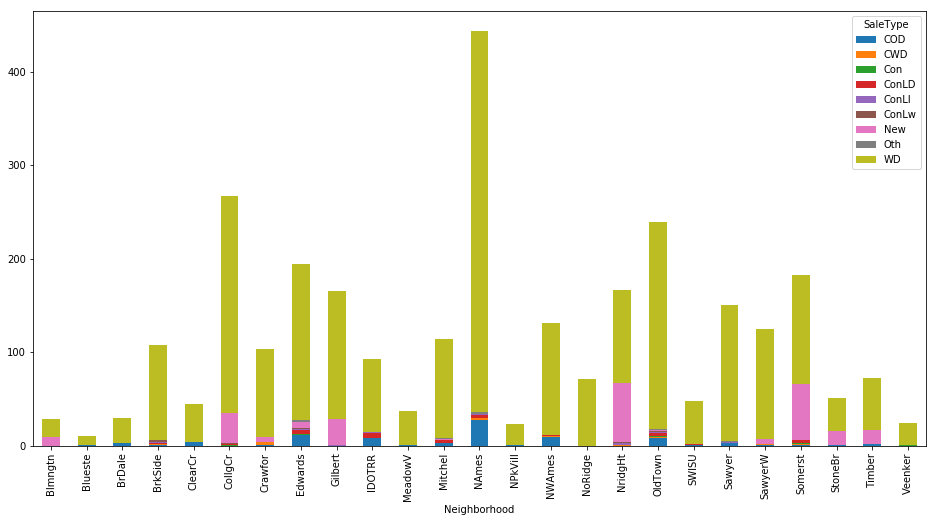

Feature: SaleType: Chi2 value: 794.5085, p value: 0.0000.


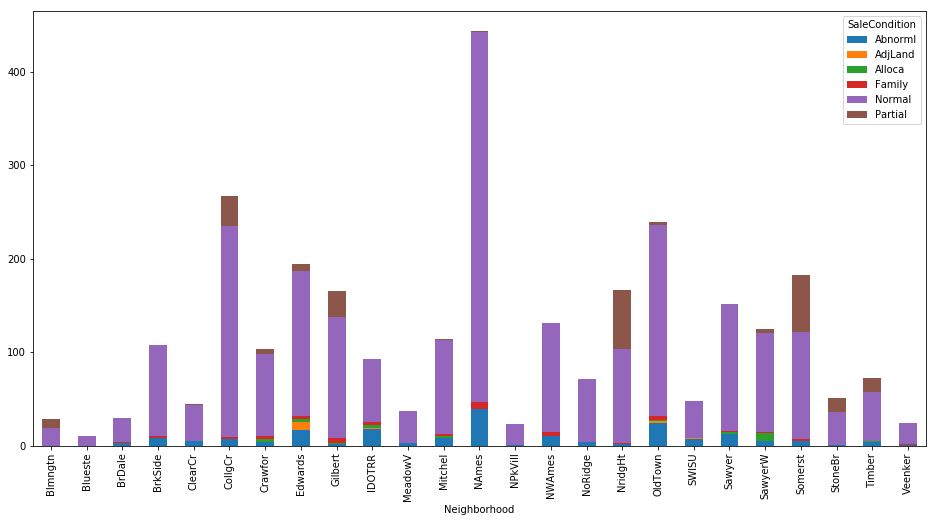

Feature: SaleCondition: Chi2 value: 794.7577, p value: 0.0000.


In [58]:
for feature in categoricalFeatures:
    if feature != 'Neighborhood':    
        obs = pd.crosstab(index=X['Neighborhood'], columns=X[feature])
        chi_val, p_val, _, _ = stats.chi2_contingency(observed=obs)
        
        obs.plot(kind="bar", 
                 figsize=(16,8),
                 stacked=True)
        plt.show()
        print('Feature: %s: Chi2 value: %.4f, p value: %.4f.' % (feature, chi_val, p_val))
        # H0 = the 2 variables are independent; Ha = the 2 variables are dependent
        # alpha = 5%
        # a feature dependends on neighborhood if p_val < alpha 
        if p_val < 0.05:
            neighborhood_related.append(feature)

In [59]:
suspiciousCatFeatures = []

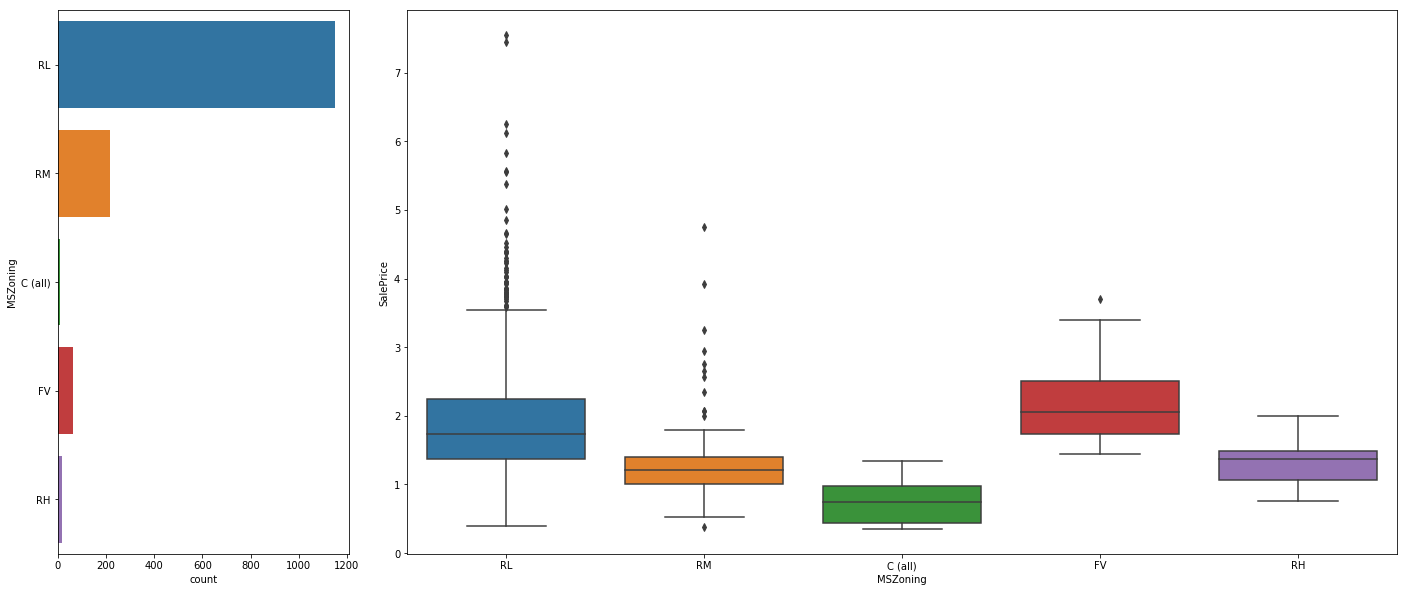

F_value: 43.8403; p_value: 0.0000


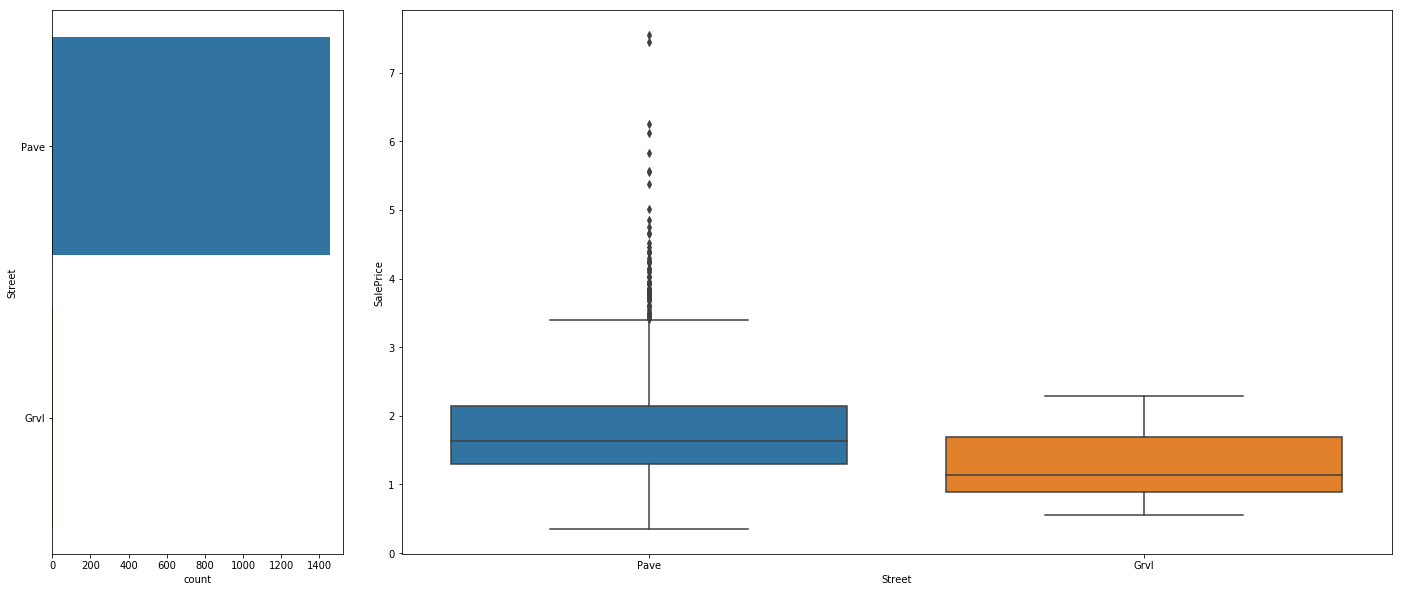

F_value: 2.4593; p_value: 0.1170


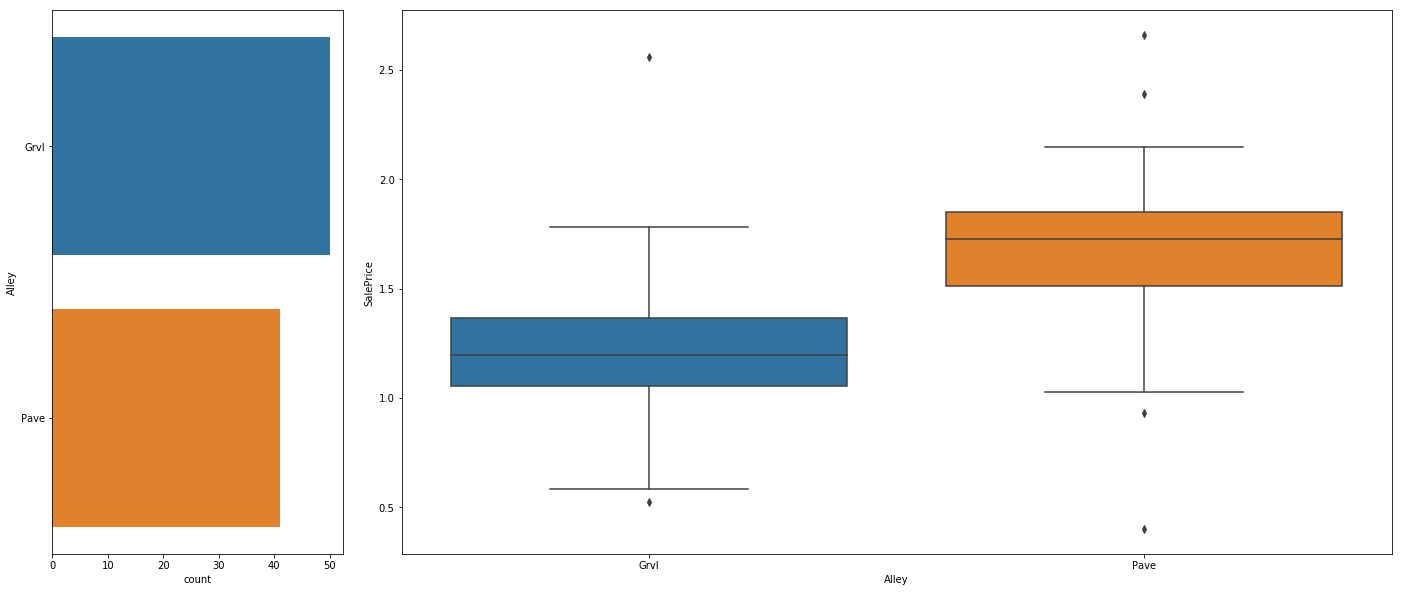

F_value: 35.5621; p_value: 0.0000


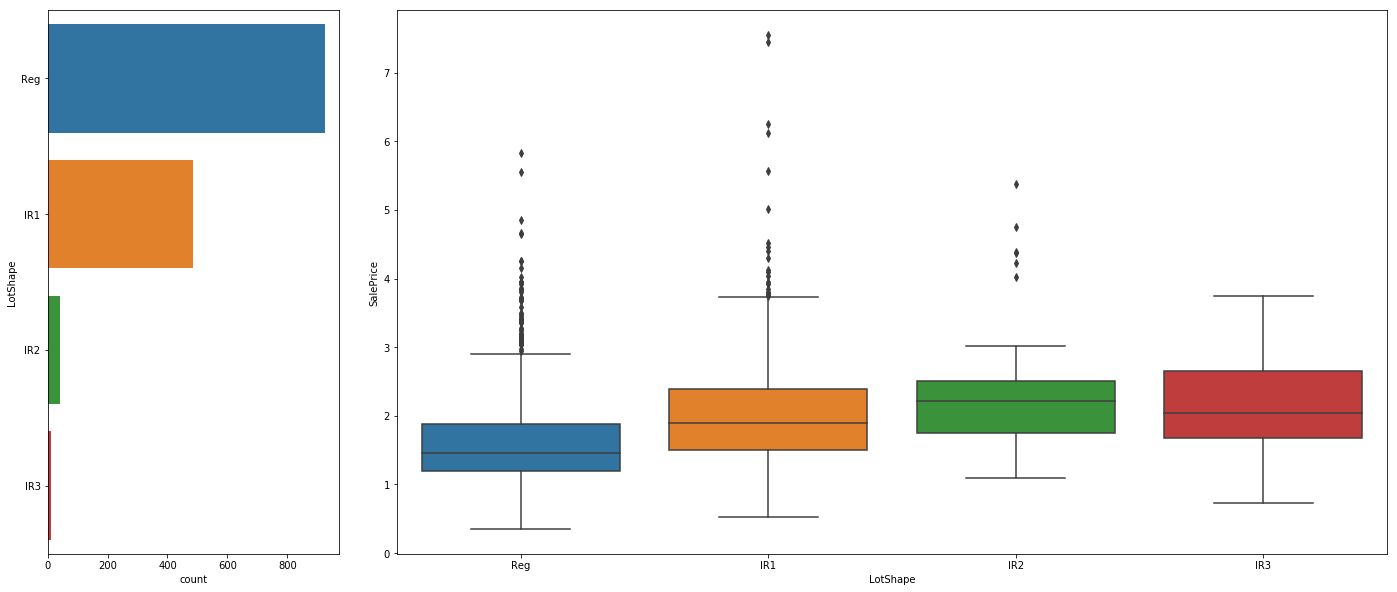

F_value: 40.1329; p_value: 0.0000


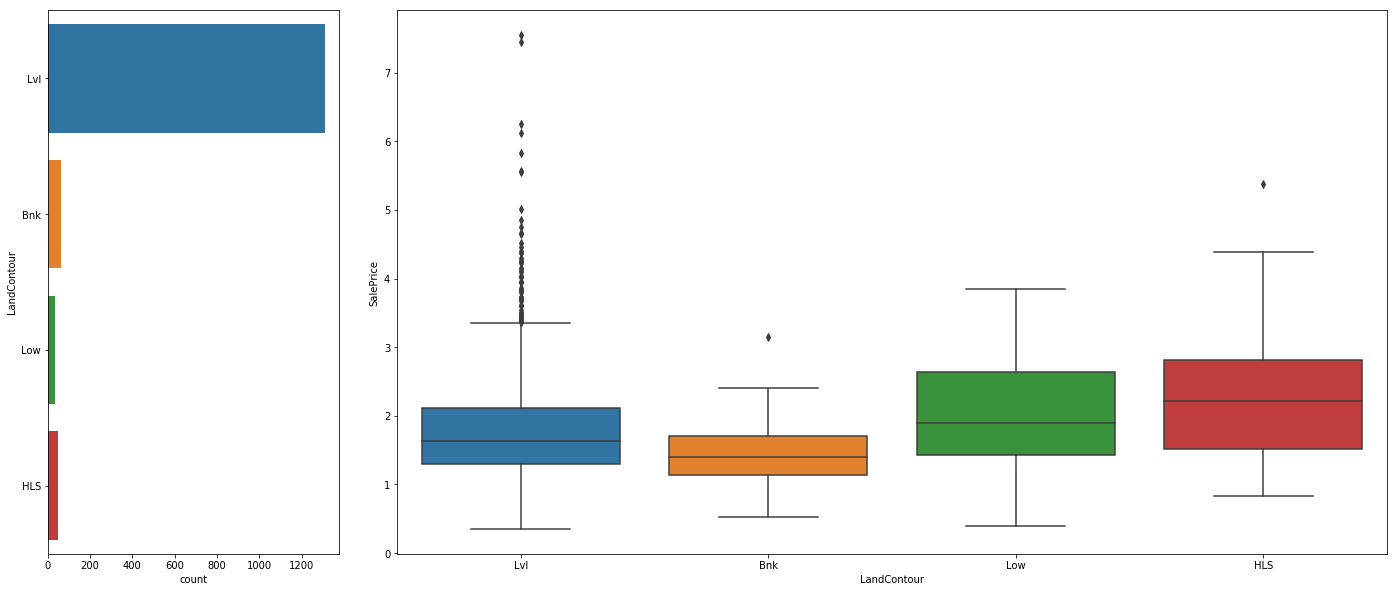

F_value: 12.8502; p_value: 0.0000


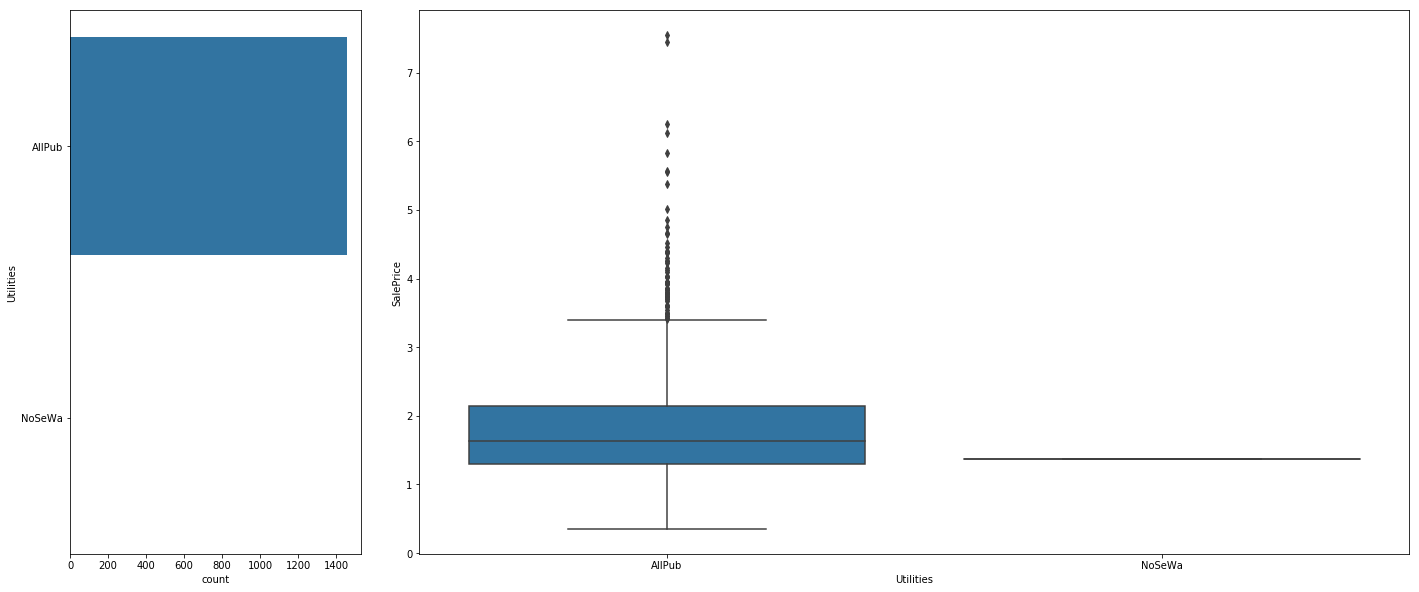

F_value: 0.2988; p_value: 0.5847


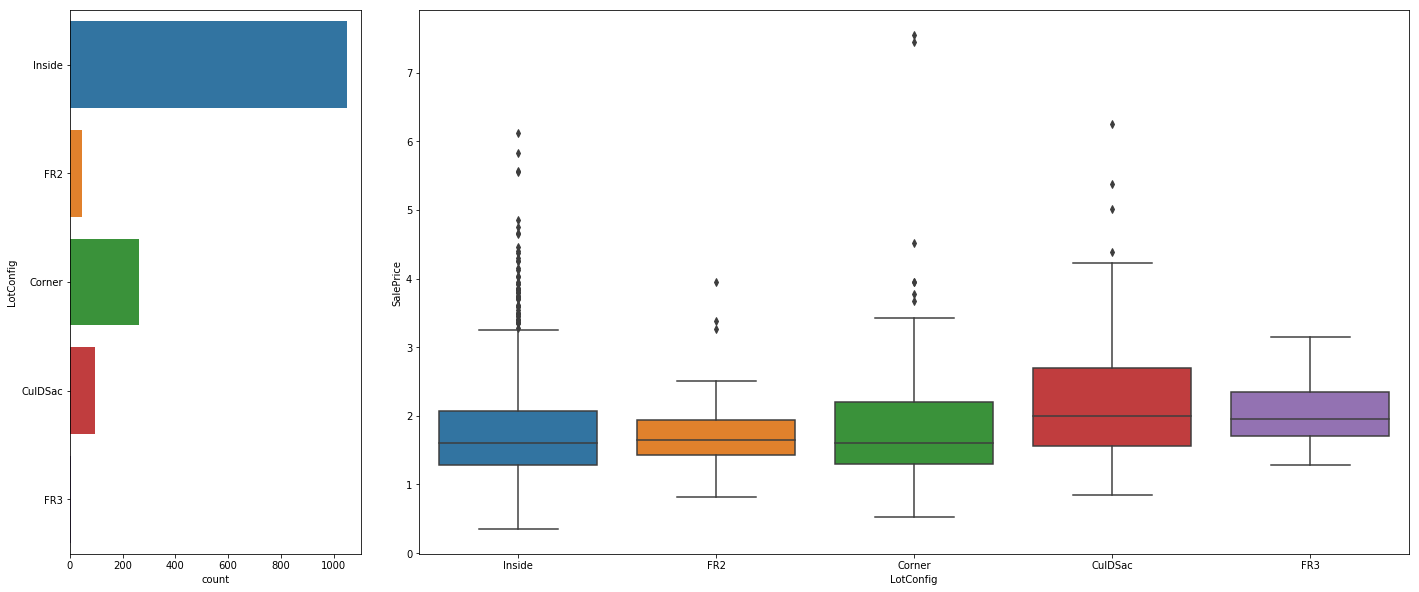

F_value: 7.8100; p_value: 0.0000


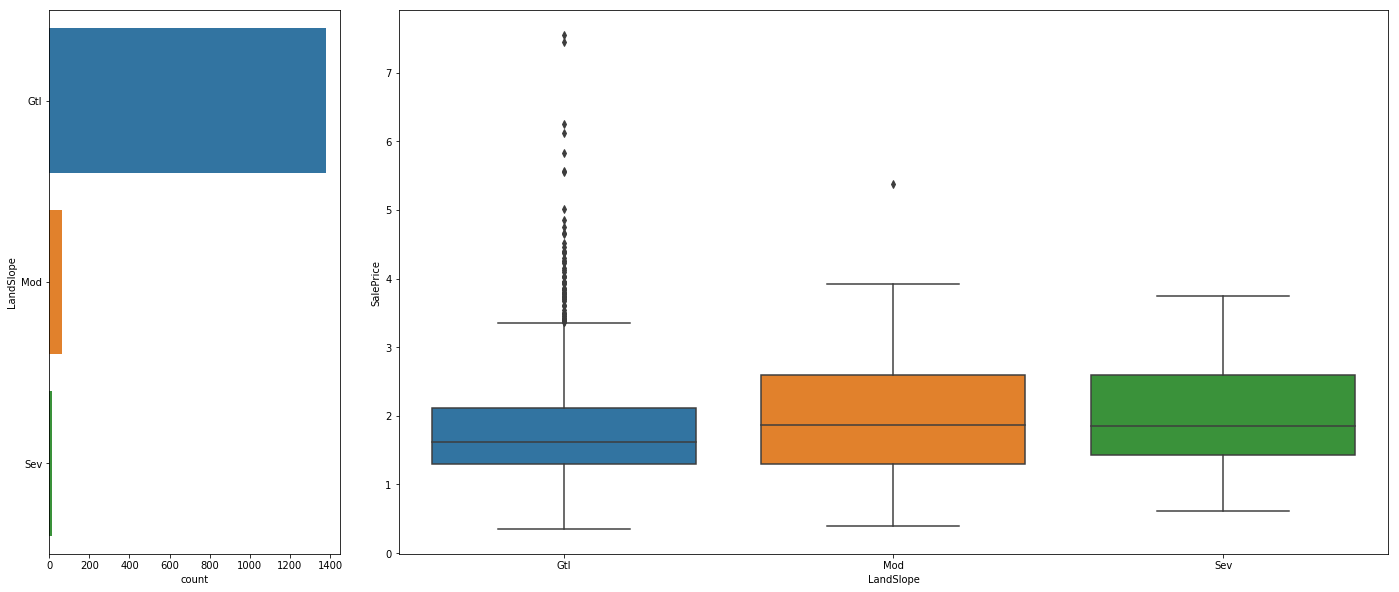

F_value: 1.9588; p_value: 0.1414


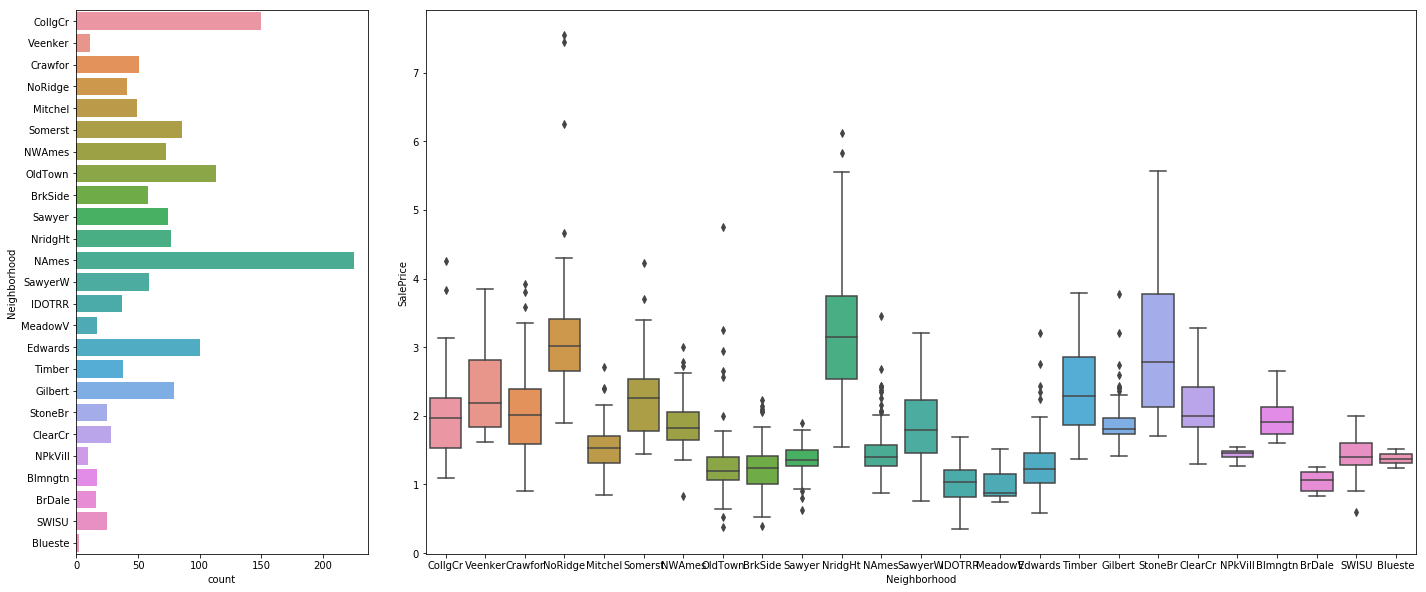

F_value: 71.7849; p_value: 0.0000


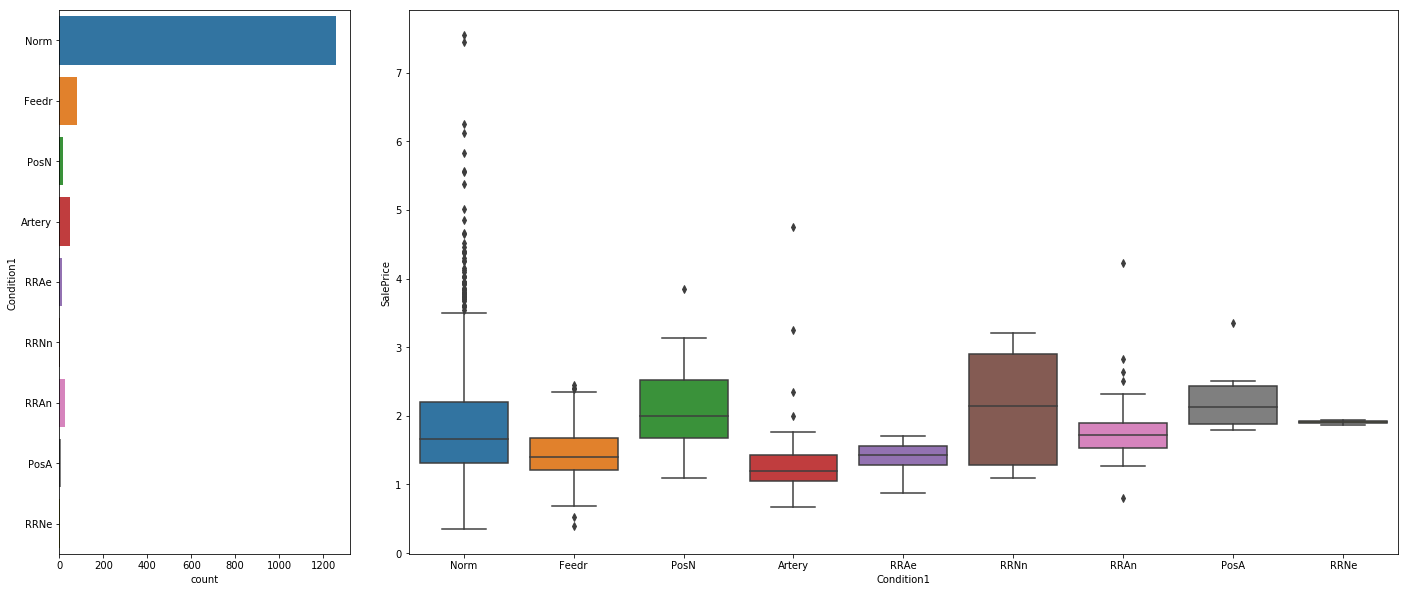

F_value: 6.1180; p_value: 0.0000


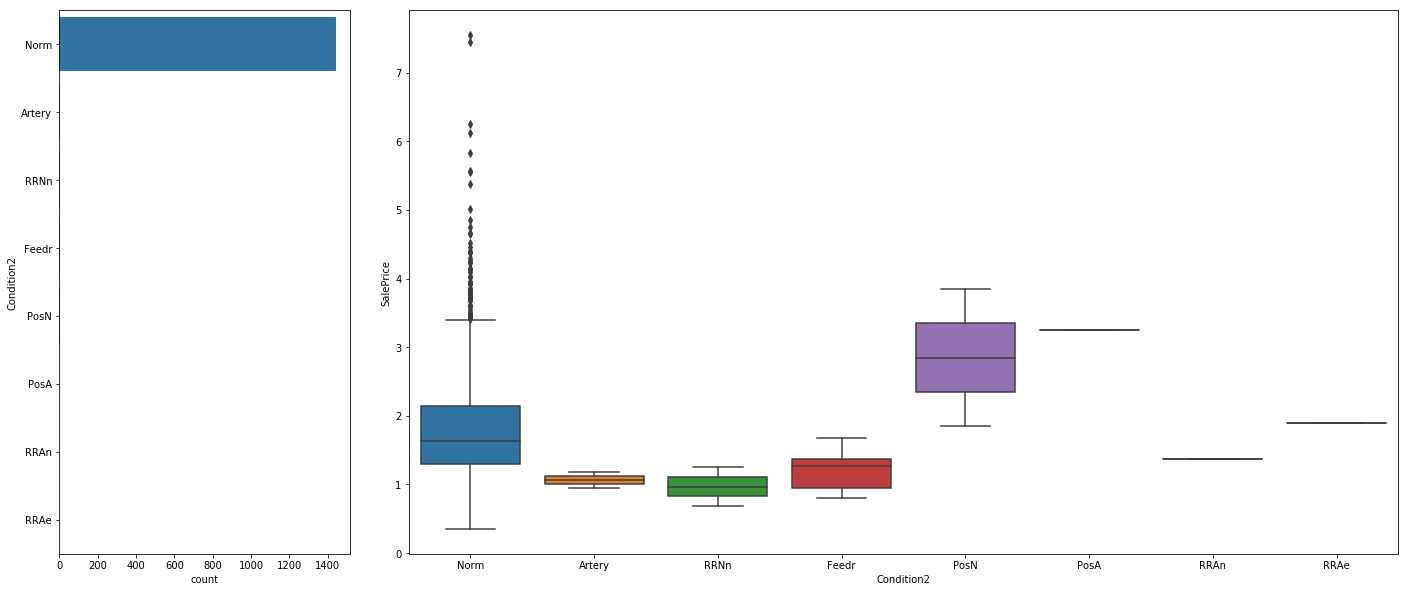

F_value: 2.0739; p_value: 0.0434


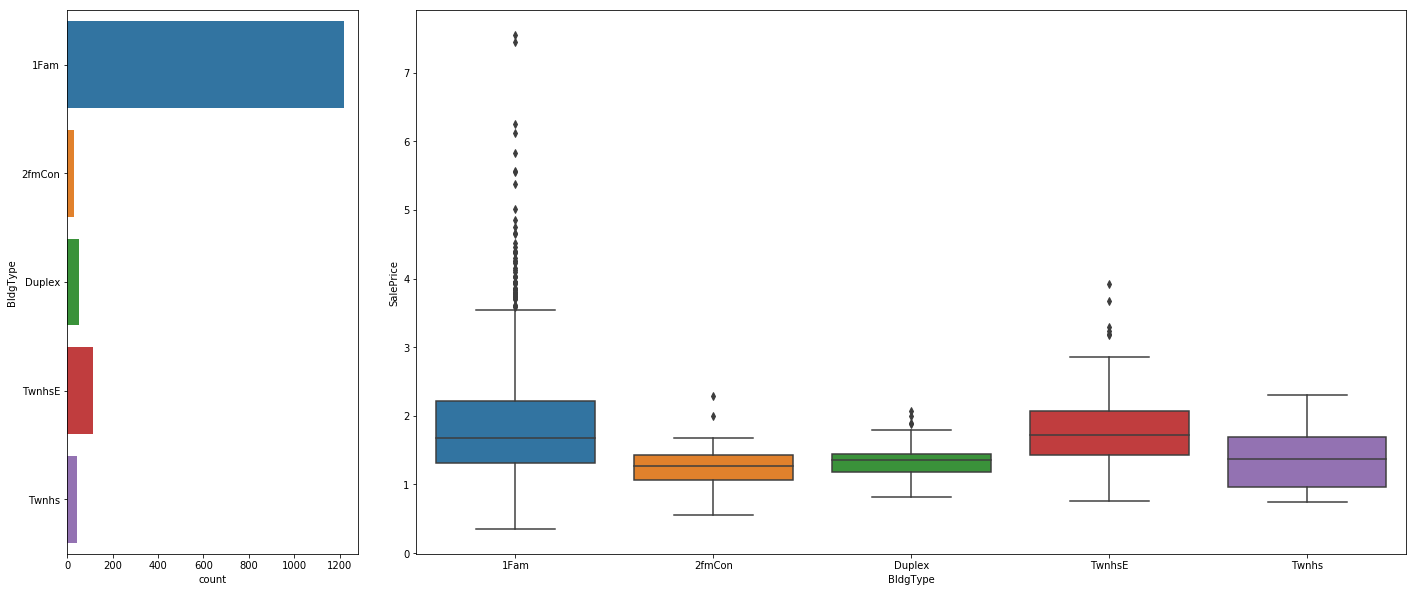

F_value: 13.0111; p_value: 0.0000


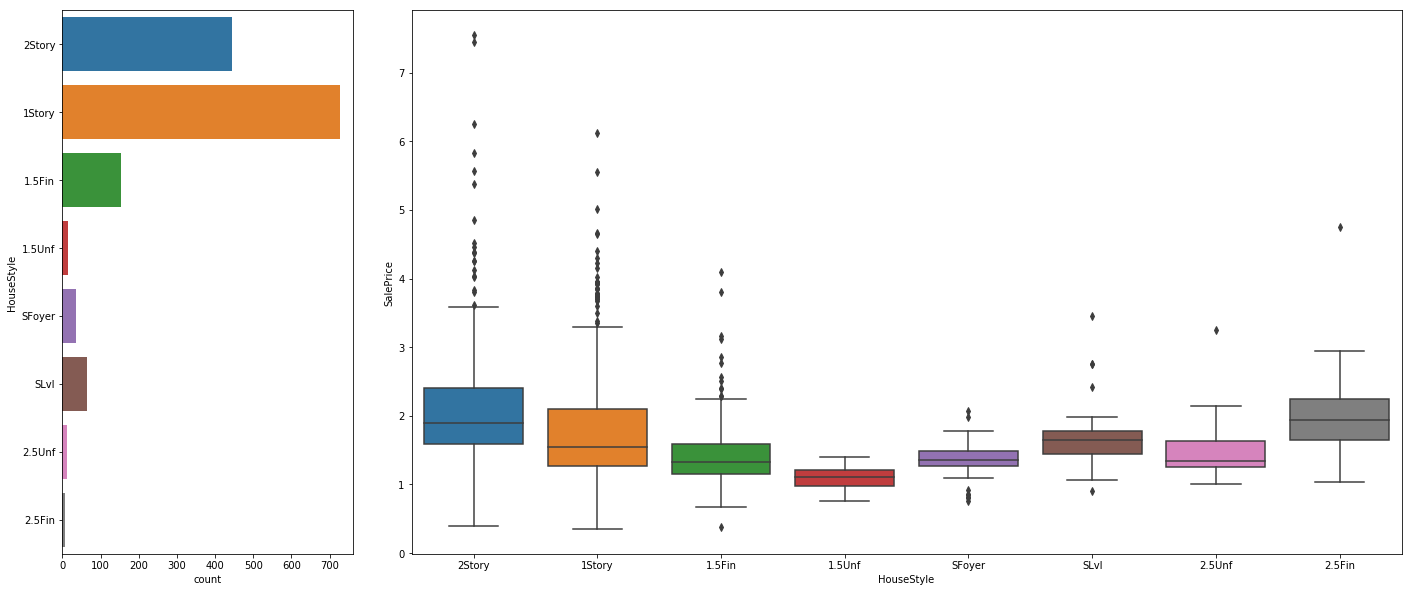

F_value: 19.5950; p_value: 0.0000


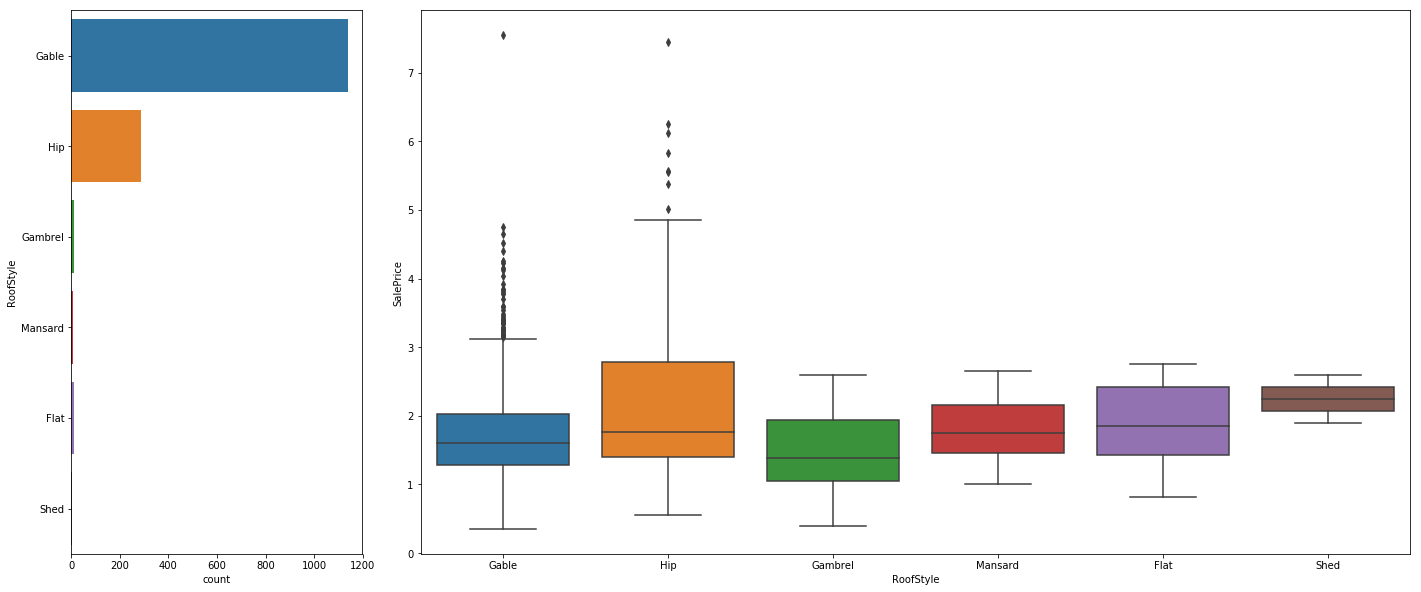

F_value: 17.8055; p_value: 0.0000


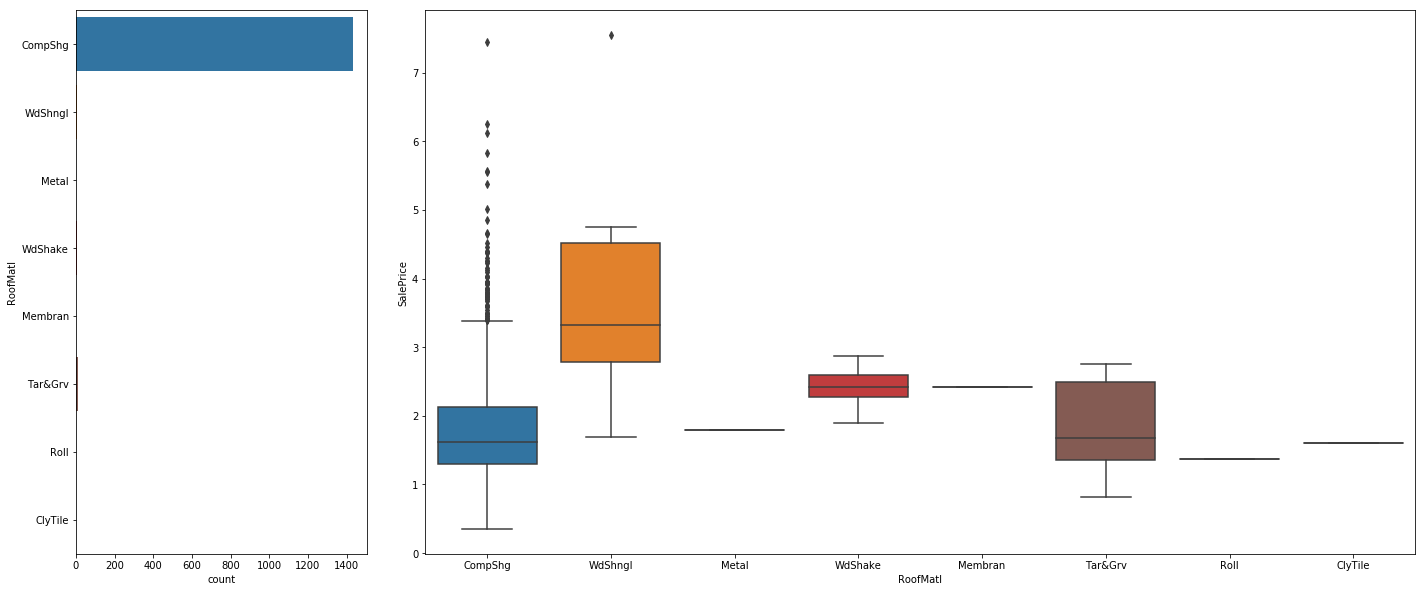

F_value: 6.7273; p_value: 0.0000


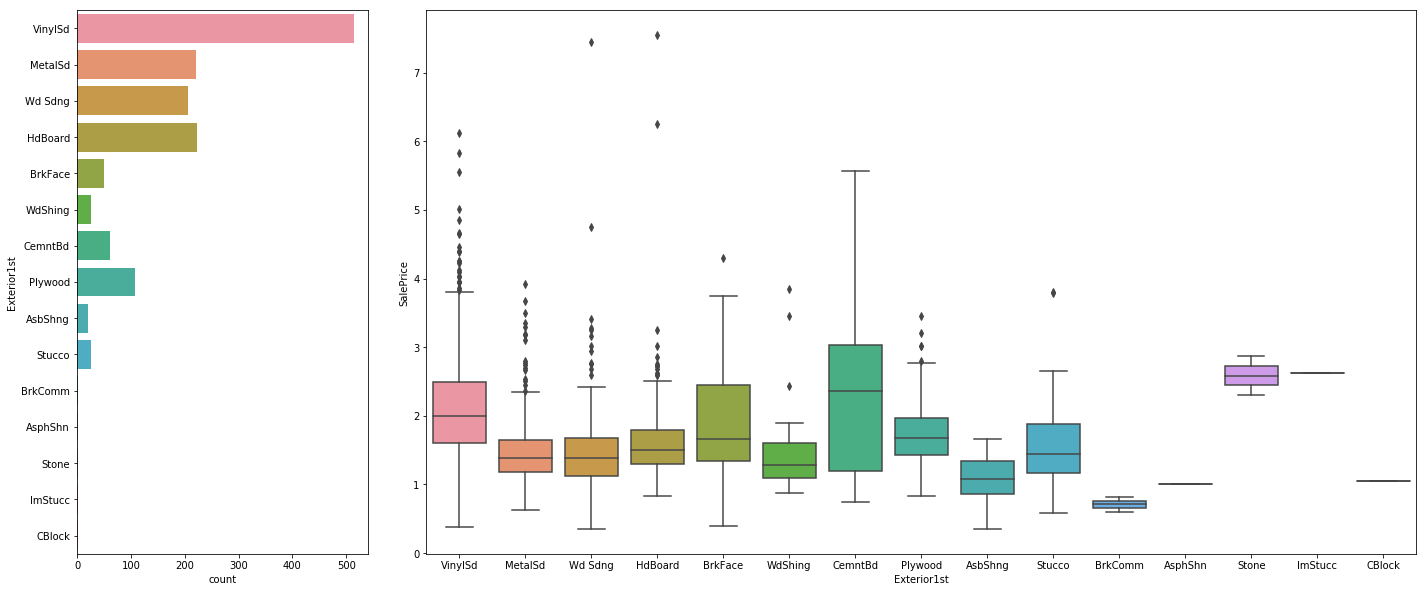

F_value: 18.6117; p_value: 0.0000


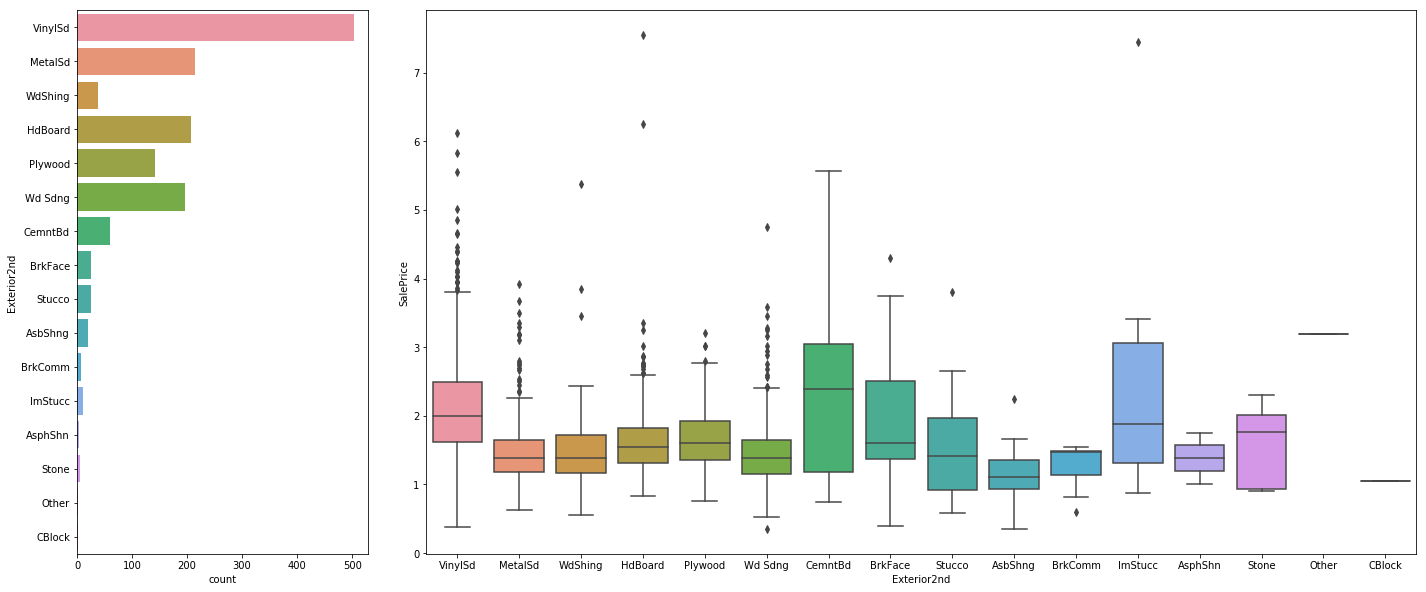

F_value: 17.5008; p_value: 0.0000


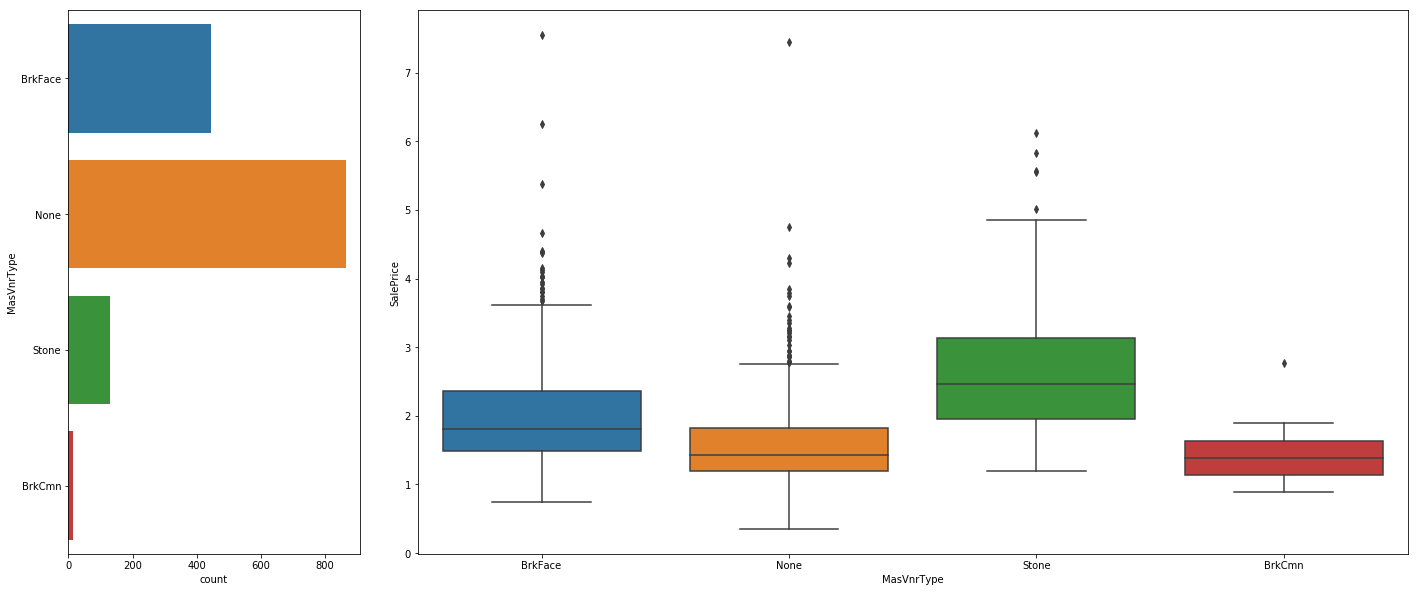

F_value: 111.6724; p_value: 0.0000


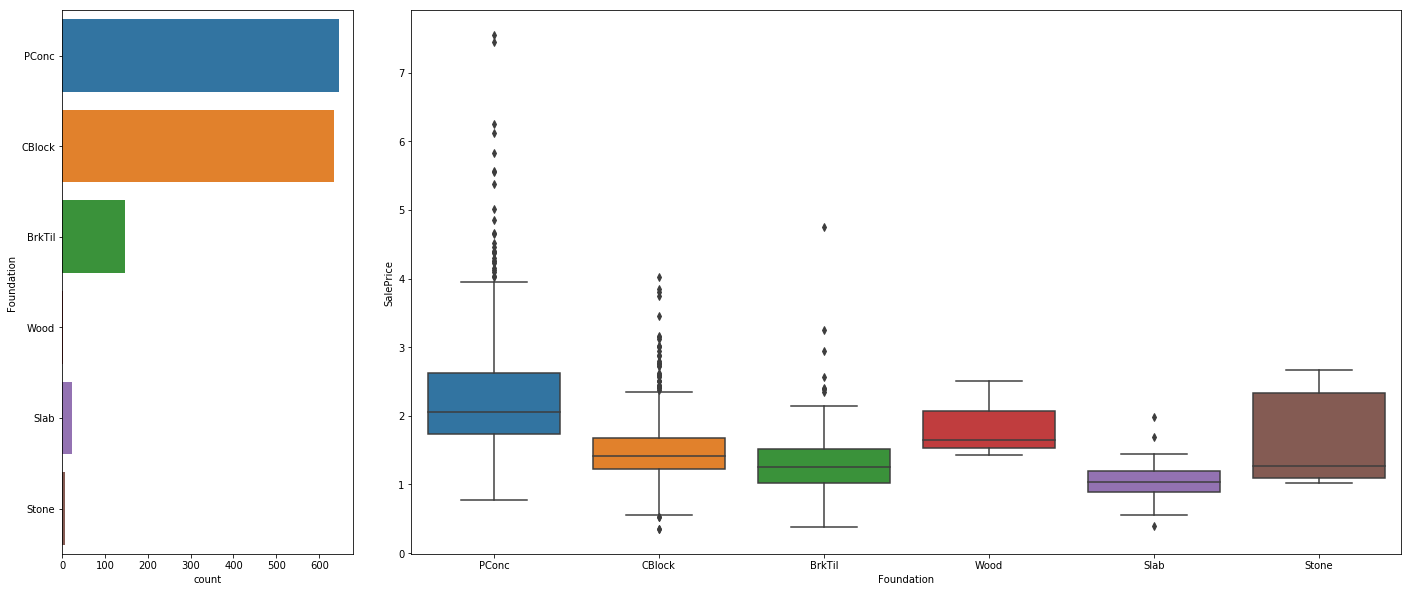

F_value: 100.2539; p_value: 0.0000


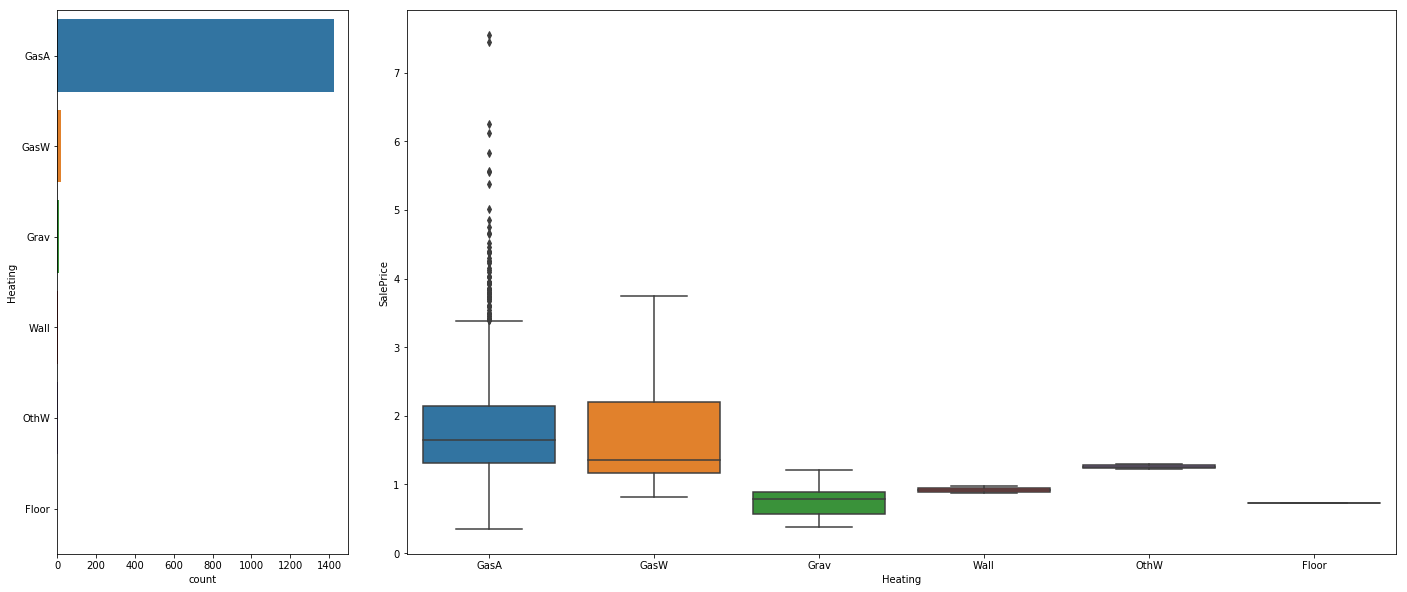

F_value: 4.2598; p_value: 0.0008


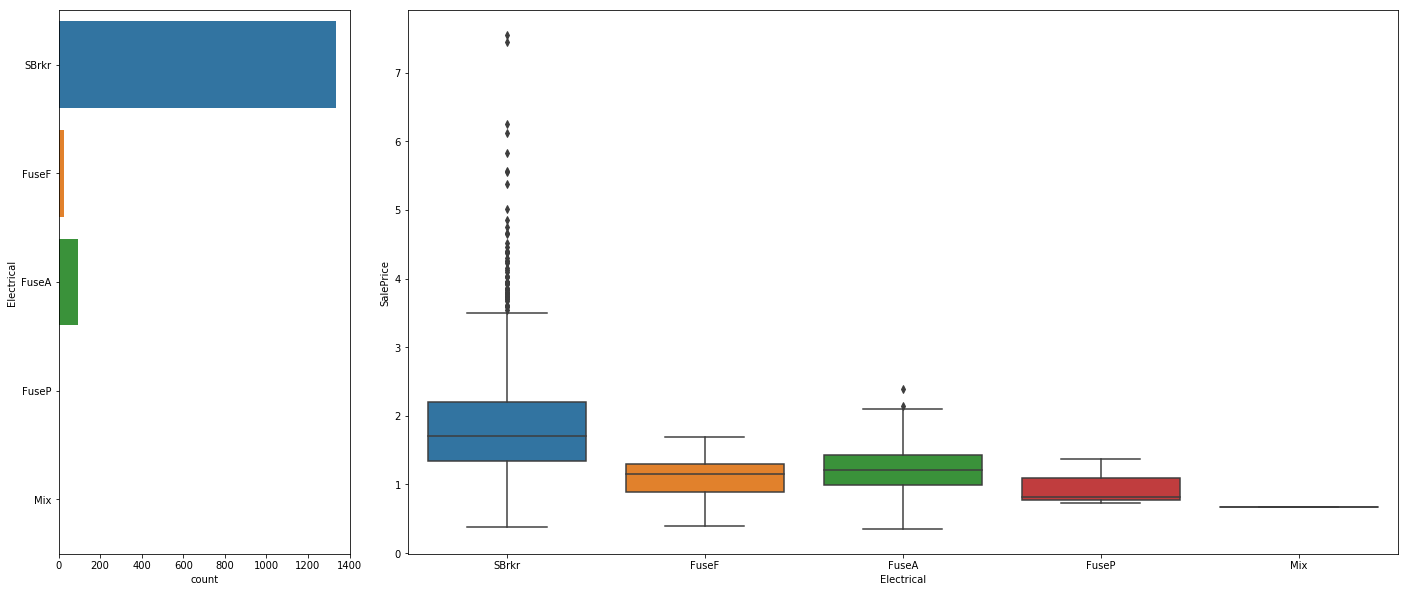

F_value: 23.0677; p_value: 0.0000


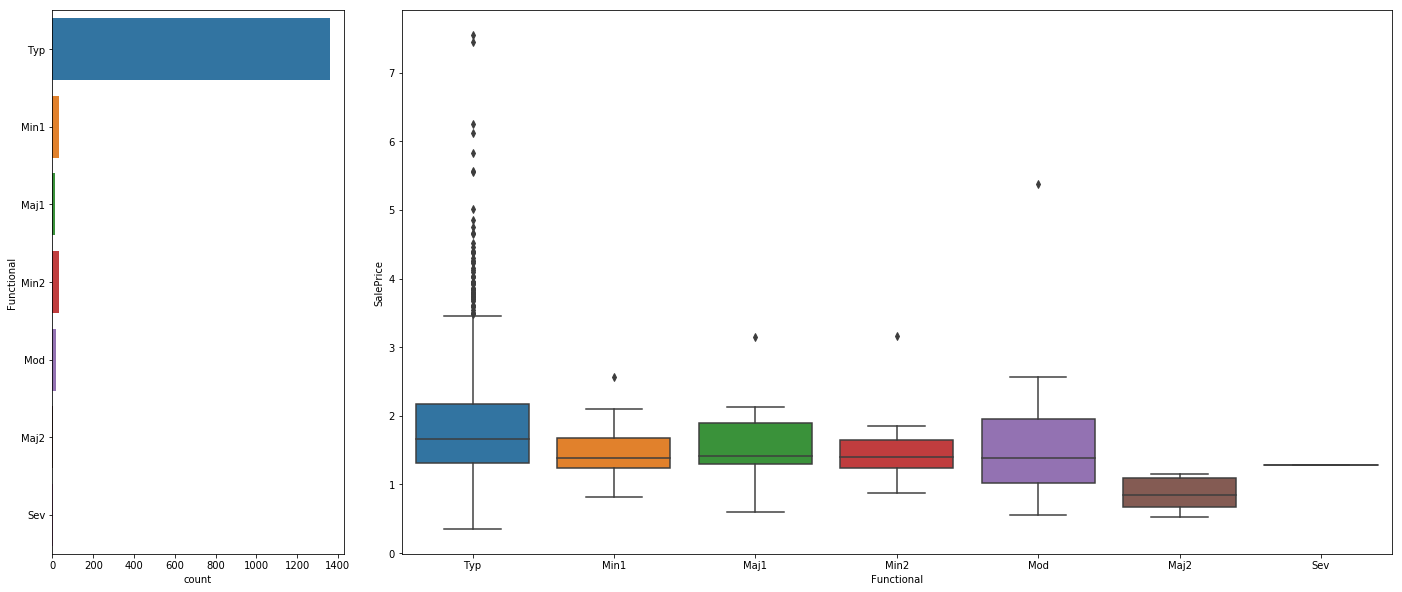

F_value: 4.0579; p_value: 0.0005


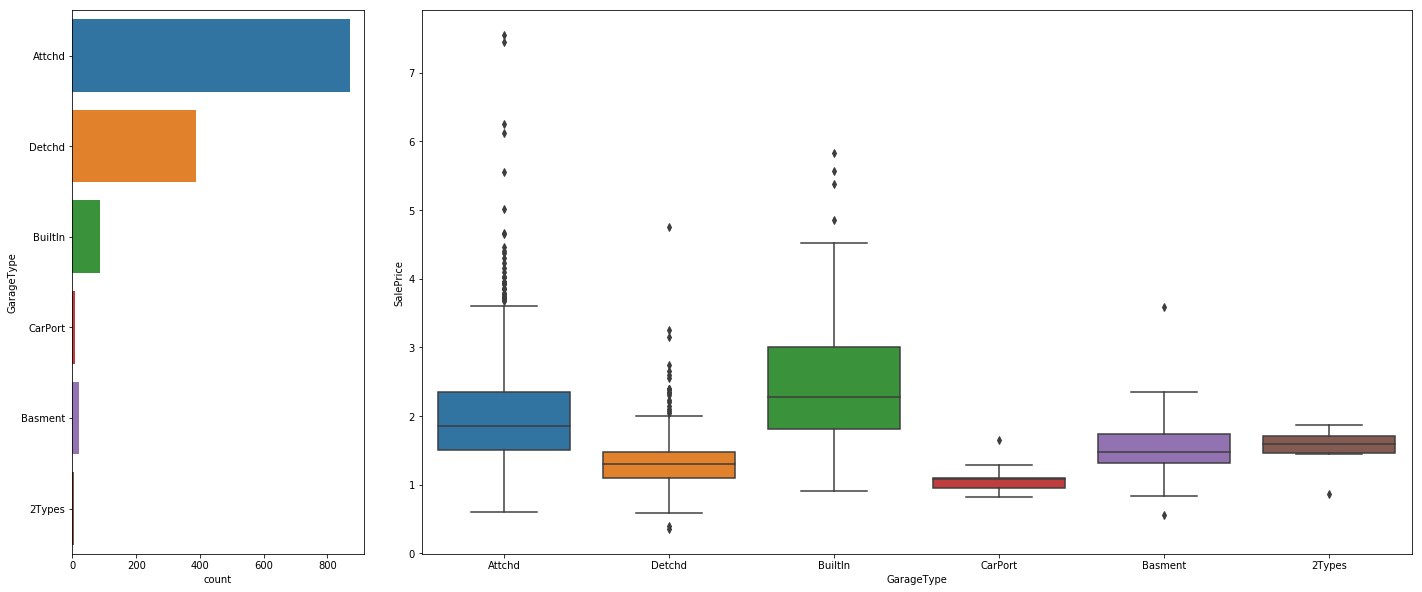

F_value: 71.5221; p_value: 0.0000


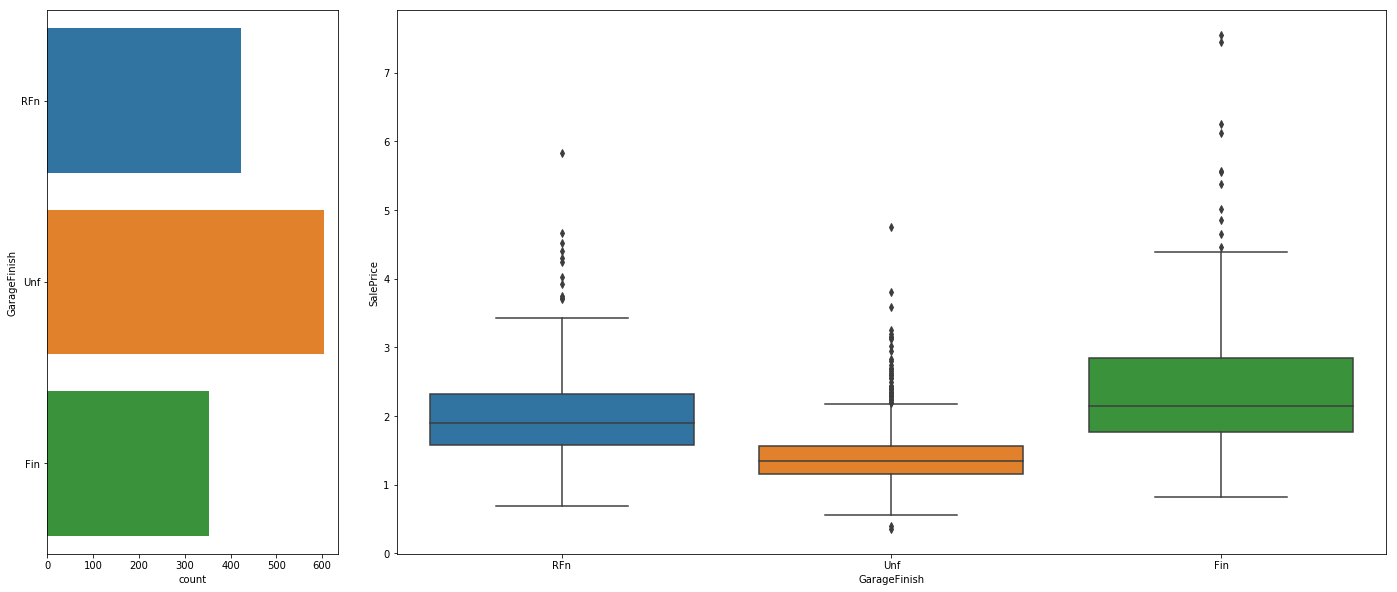

F_value: 250.9625; p_value: 0.0000


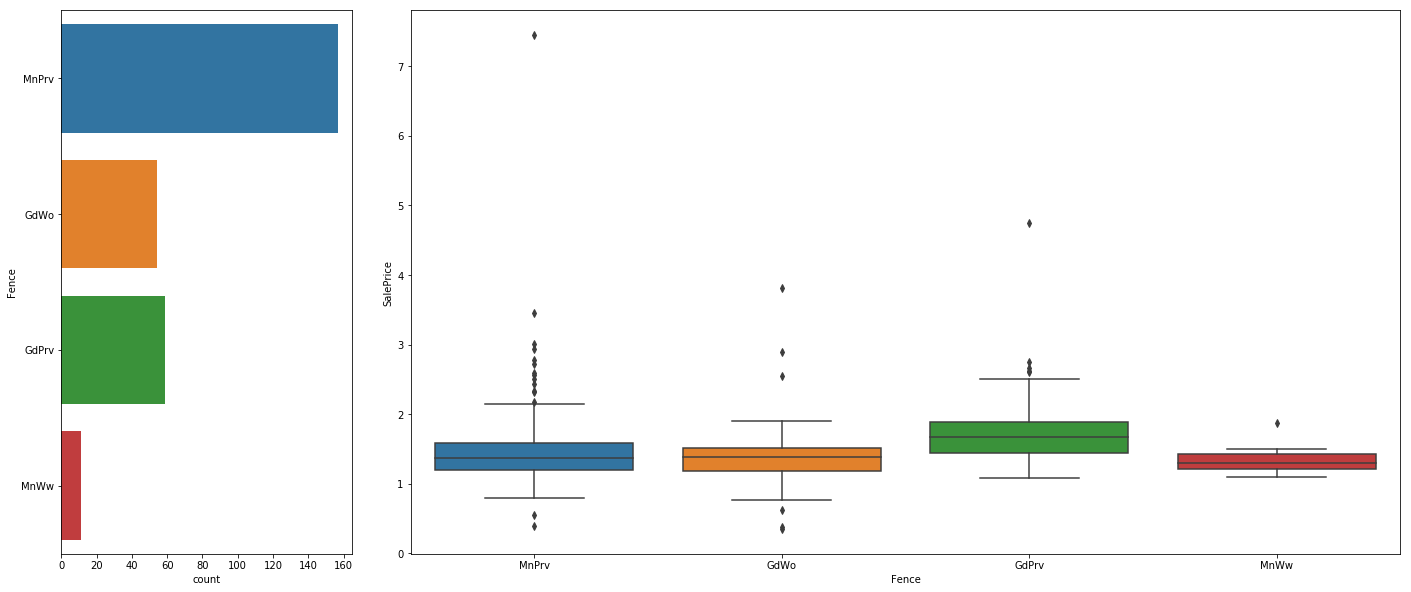

F_value: 4.9482; p_value: 0.0023


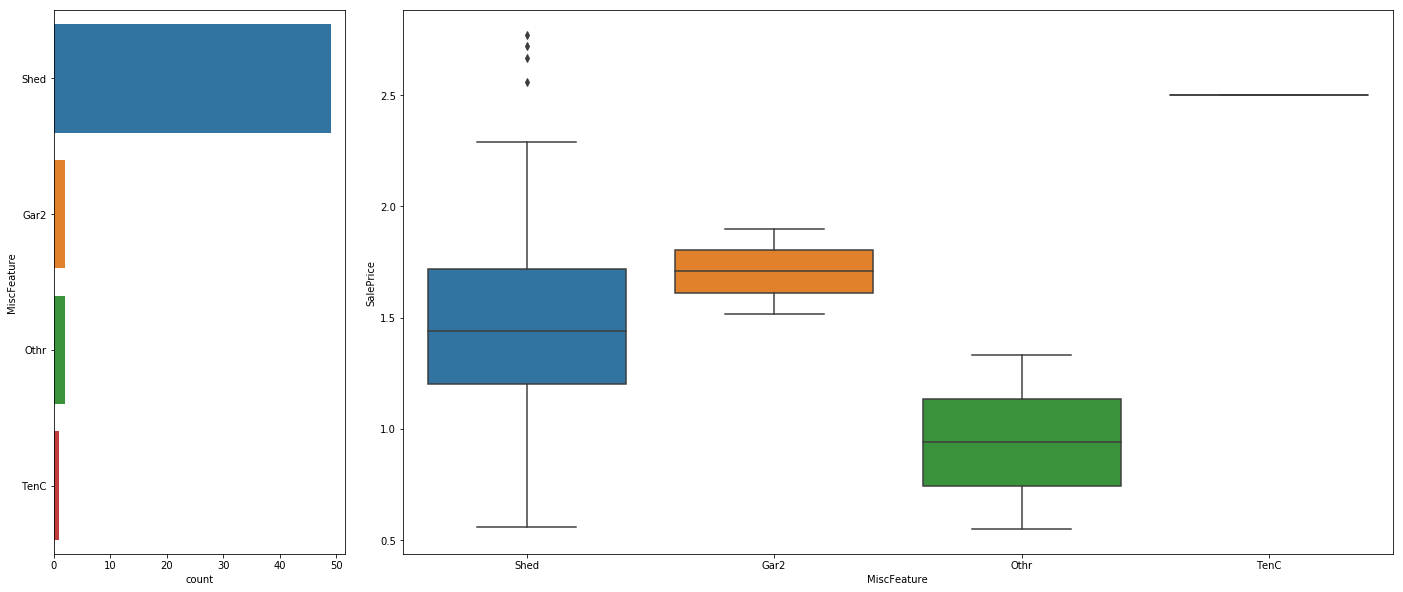

F_value: 2.1573; p_value: 0.1047


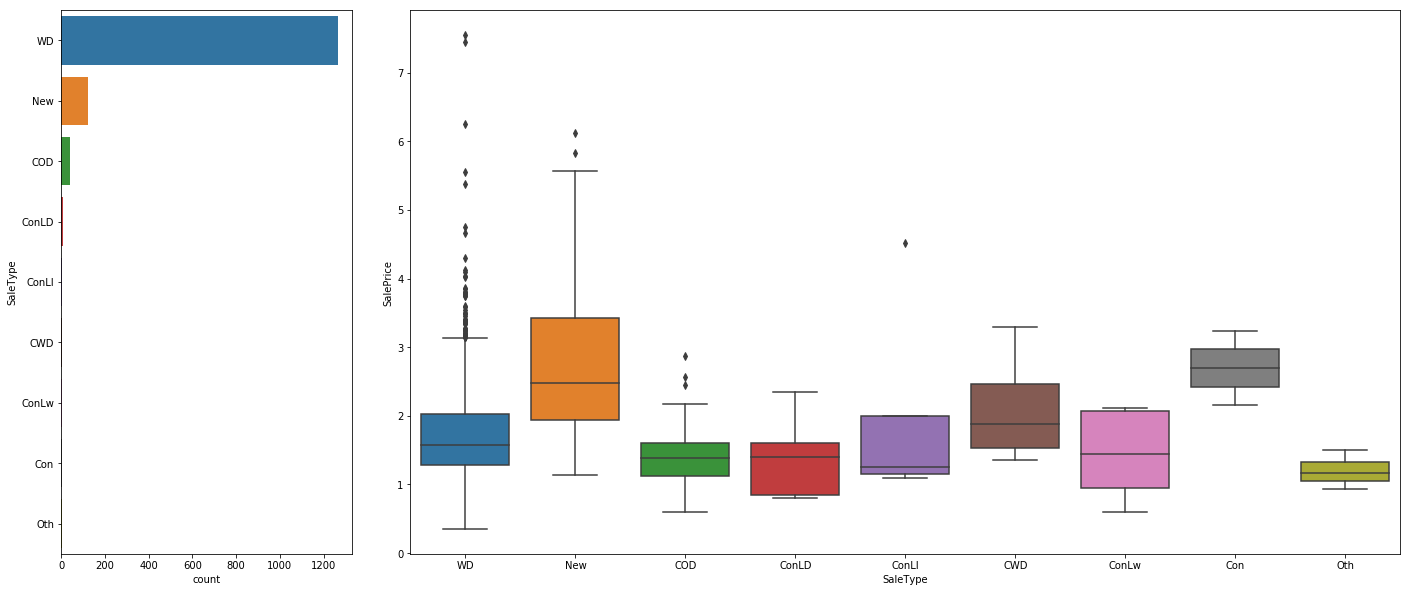

F_value: 28.8631; p_value: 0.0000


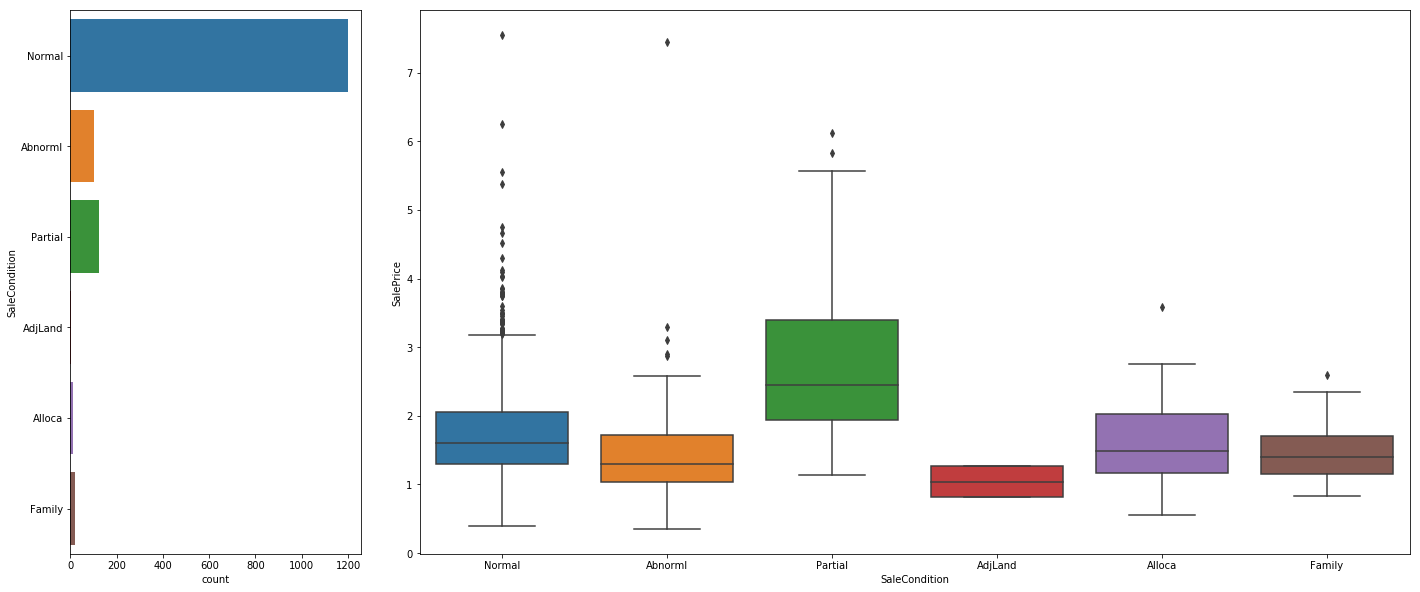

F_value: 45.5784; p_value: 0.0000


In [60]:
for feature in categoricalFeatures:
    fig = plt.subplots(figsize=(24, 10))
    grid = plt.GridSpec(1, 4, wspace=0.2)
    
    datatmp = pd.concat([X.iloc[:1460][feature], Y], axis=1)
    
    plt.subplot(grid[0, 0])
    sn.countplot(y=feature, data=datatmp)
    
    plt.subplot(grid[0, 1:])
    sn.boxplot(x=feature, y='SalePrice', data=datatmp)
    
    plt.show()
    groupedValues = [values for groups, values in data_trn.groupby(feature)['SalePrice']]
    F_val, p_val = stats.f_oneway(*groupedValues)
    print('F_value: %.4f; p_value: %.4f' % (F_val, p_val))
    # H0 = subsamples are from one single distribution; Ha = subsamples are from different distributions
    # alpha = 5%
    # reject H0 and favor Ha if p_val < alpha, i.e., the feature having p_val > 0.05 is more likely to be noise
    if p_val > 0.05:    
        suspiciousCatFeatures.append(feature)
    

In [61]:
suspiciousCatFeatures

['Street', 'Utilities', 'LandSlope', 'MiscFeature']

In [62]:
ordinalCatFeatures = []

In [63]:
# replace type of alley by +/-1
# indeed -1 < 1, but since here there are only two types, +/-1 is only a numerical representation of the type, the 
# contribution of the type to the final house price will be learnt by the training process
'''
     1   Pave
     0   NA
     -1  Grvl
'''
typeDict = {'Pave' : 1, 'NA' : 0, 'Grvl' : -1}

X['Alley'].replace(to_replace=list(typeDict.keys()), 
                   value=list(typeDict.values()),
                   inplace=True)
X['Alley'].fillna(0, inplace=True)

ordinalCatFeatures.append('Alley')

In [64]:
X['LotShape'].replace(to_replace=['Reg', 'IR1', 'IR2', 'IR3'],
                      value=[1, -1, -2, -3],
                      inplace=True)

ordinalCatFeatures.append('LotShape')

In [65]:
X['GarageFinish'].replace(to_replace=['Fin','RFn','Unf','NA'],
                          value=[2, 1, 0.5, -1],
                          inplace=True)

X['GarageFinish'].fillna(0, inplace=True)

ordinalCatFeatures.append('GarageFinish')

In [66]:
X['Fence'].replace(to_replace=['GdPrv','MnPrv','GdWo', 'MnWw','NA'],
                   value=[2, 1, 2, 1, -1],
                   inplace=True)

X['Fence'].fillna(0, inplace=True)

ordinalCatFeatures.append('Fence')

In [67]:
X['Electrical'].replace(to_replace=['SBrkr', 'FuseF','FuseA', 'FuseP', 'Mix'],
                        value=[2, 1, 1, 1, 0.5],
                        inplace=True)

X['Electrical'].fillna(0, inplace=True)

ordinalCatFeatures.append('Electrical')

In [68]:
X['Cond1vsCond2'] = (X['Condition1'] != X['Condition2']) * 1

In [69]:
nominalCatFeatures = list(set(categoricalFeatures) - set(suspiciousCatFeatures) - set(ordinalCatFeatures))

In [70]:
for feature in nominalCatFeatures:
    X = pd.get_dummies(X, prefix=feature, columns=[feature])

In [71]:
X.drop(labels=suspiciousCatFeatures, axis=1, inplace=True)

In [72]:
X.shape

(2919, 203)

In [73]:
null_columns = X.columns[X.isnull().any()]
X[null_columns].isnull().sum()

TotalBsmtSF           1
squaredBsmtUnfSF      1
squaredTotalBsmtSF    1
squaredGarageArea     1
Baths                 2
dtype: int64

In [74]:
X.fillna(0, inplace=True)

In [75]:
X.describe()

LotFrontage      LotArea        Alley     LotShape  OverallQual  \
count  2919.000000  2919.000000  2919.000000  2919.000000  2919.000000   
mean      0.922791     0.207252    -0.014388     0.236725     2.827262   
std       0.534850     0.184323     0.260092     1.032611     0.783304   
min       0.000000     0.000000    -1.000000    -3.000000     0.000000   
25%       0.686901     0.144383     0.000000    -1.000000     2.222222   
50%       1.006390     0.190540     0.000000     1.000000     2.777778   
75%       1.246006     0.240015     0.000000     1.000000     3.333333   
max       5.000000     5.000000     1.000000     1.000000     5.000000   

        MasVnrArea    ExterQual   BsmtFinSF1  TotalBsmtSF    HeatingQC  \
count  2919.000000  2919.000000  2919.000000  2919.000000  2919.000000   
mean      0.316863     2.327852     0.390921     0.860407     3.788969   
std       0.558921     0.967156     0.403620     0.360982     1.366277   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     1.666667     0.000000     0.648936     2.142857   
50%       0.000000     1.666667     0.326010     0.809329     5.000000   
75%       0.510938     3.333333     0.649362     1.065466     5.000000   
max       5.000000     5.000000     5.000000     5.000000     5.000000   

        CentralAir   Electrical     1stFlrSF    GrLivArea     FullBath  \
count  2919.000000  2919.000000  2919.000000  2919.000000  2919.000000   
mean      4.664269     1.914526     0.867026     1.099058     1.960003   
std       1.251590     0.281314     0.412058     0.476687     0.691212   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       5.000000     2.000000     0.569208     0.746044     1.250000   
50%       5.000000     2.000000     0.785549     1.045592     2.500000   
75%       5.000000     2.000000     1.106385     1.327713     2.500000   
max       5.000000     2.000000     5.000000     5.000000     5.000000   

       KitchenQual  TotRmsAbvGrd  FireplaceQu  GarageFinish   GarageArea  \
count  2919.000000   2919.000000  2919.000000   2919.000000  2919.000000   
mean      3.344372      1.712125     1.687983      0.981158     1.588416   
std       0.738259      0.603607     1.740541      0.637116     0.724246   
min       0.000000      0.000000     0.000000      0.000000     0.000000   
25%       2.777778      1.153846     0.000000      0.500000     1.075269   
50%       2.777778      1.538462     1.111111      1.000000     1.612903   
75%       3.888889      1.923077     3.888889      1.000000     1.935484   
max       5.000000      5.000000     5.000000      2.000000     5.000000   

        PavedDrive   WoodDeckSF  ScreenPorch        Fence  squaredOverallQual  \
count  2919.000000  2919.000000  2919.000000  2919.000000         2919.000000   
mean      4.576910     0.329037     0.139430     0.274409            1.922427   
std       1.343247     0.444265     0.487712     0.597343            0.898422   
min       0.000000     0.000000     0.000000     0.000000            0.000000   
25%       5.000000     0.000000     0.000000     0.000000            1.212121   
50%       5.000000     0.000000     0.000000     0.000000            1.767677   
75%       5.000000     0.589888     0.000000     0.000000            2.424242   
max       5.000000     5.000000     5.000000     2.000000            5.000000   

       squaredOverallCond  squaredBsmtUnfSF  squaredTotalBsmtSF  \
count         2919.000000       2919.000000         2919.000000   
mean             1.950197          0.464938            0.174113   
std              0.829876          0.652810            0.174543   
min              0.000000          0.000000            0.000000   
25%              1.500000          0.044348            0.084224   
50%              1.500000          0.199829            0.131003   
75%              2.187500          0.593768            0.227044   
max              5.000000          5.000000            

In [76]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVR

### feature selection

In [77]:
X_trn = X.iloc[:1460]
X_tst = X.iloc[1460:]

In [78]:
xgb = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.005, max_depth=6)
xgb.fit(X_trn, Y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.005, loss='ls', max_depth=6,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [79]:
adab = AdaBoostRegressor(n_estimators=800, learning_rate=0.01,loss='square')
adab.fit(X_trn, Y)

AdaBoostRegressor(base_estimator=None, learning_rate=0.01, loss='square',
         n_estimators=800, random_state=None)

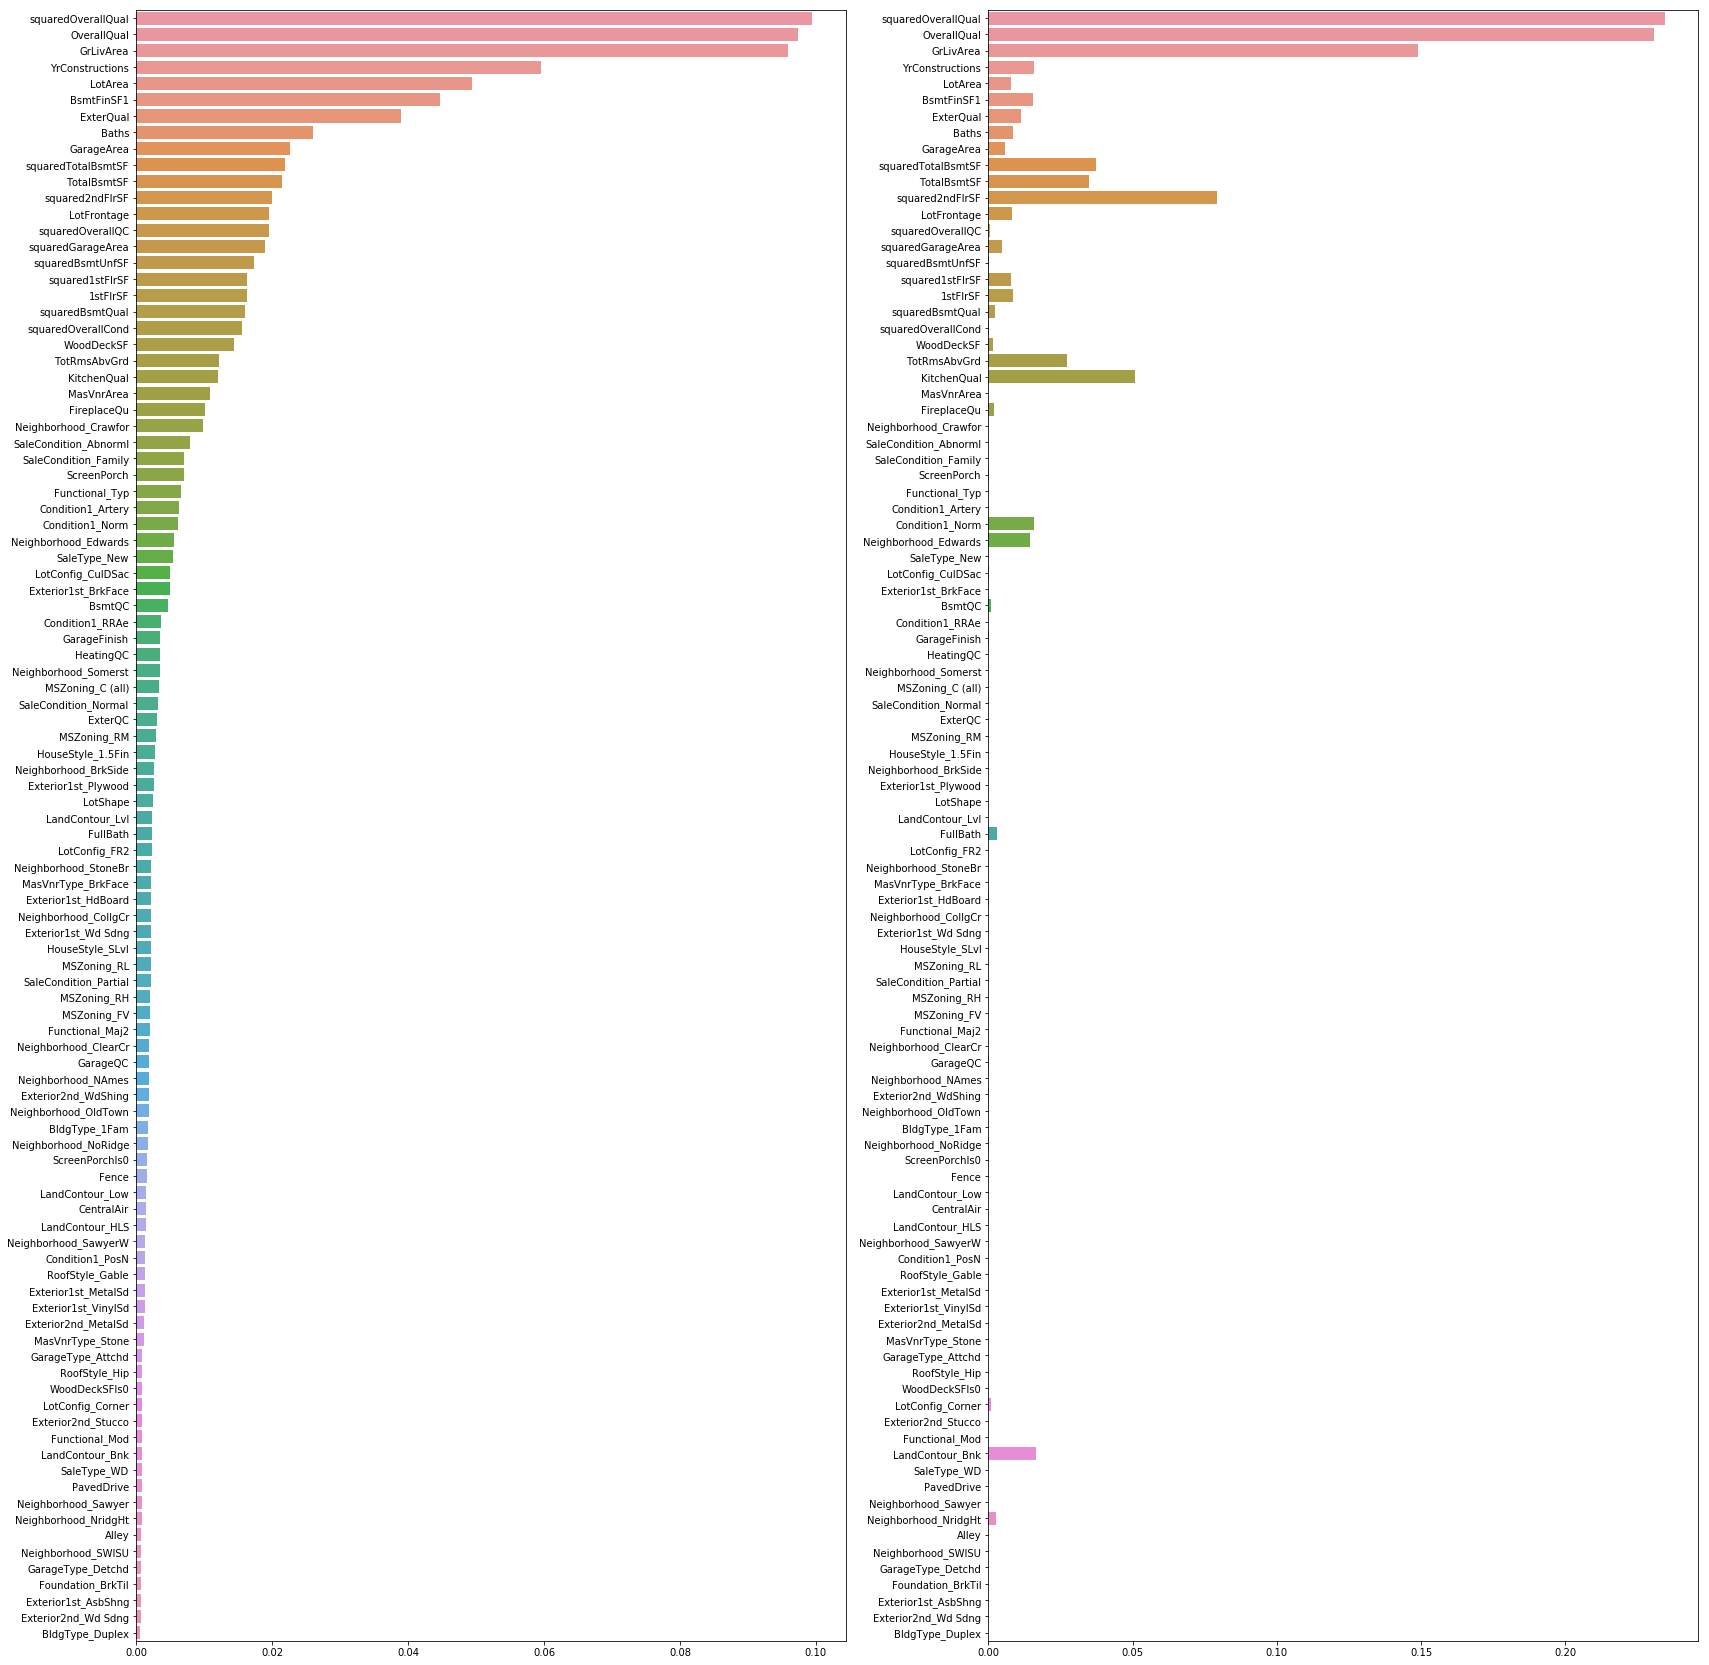

In [80]:
fig, axes = plt.subplots(figsize=(28, 30))
grid = plt.GridSpec(1, 2, wspace=0.2)

indices = np.argsort(xgb.feature_importances_)[::-1][:100]

plt.subplot(grid[0, 0])
sn.barplot(y=X.columns[indices], x=xgb.feature_importances_[indices])

plt.subplot(grid[0, 1])
sn.barplot(y=X.columns[indices], x=adab.feature_importances_[indices])

plt.show()

### stacking models

In [81]:
Xreduced = X_trn.loc[:, X.columns[indices[:100]]]

XTrain, XTest, YTrain, YTest = train_test_split(Xreduced, Y, test_size = 0.1)
featureSize = len(Xreduced.columns.values) + 1

In [82]:
Xreduced.shape

(1460, 100)

In [83]:
n_splits = 10
n_iter_tuning = 100

paramAdaBst = {'n_estim_ada': list(np.arange(10,150)), 
               'learning_rate_ada': [0.001, 0.005,0.01,0.03,0.05,0.1,0.15,0.2,0.25,0.3], 
               'max_depth_dt': list(np.arange(3,20,2)), 
               'max_feat_dt': list(np.arange(int(featureSize/2),featureSize))}

paramXGBst = {'n_estim_xg': list(np.arange(10,1000,10)), 
              'learning_rate_xg': [0.001, 0.005,0.01,0.03,0.05,0.1,0.15,0.2,0.25,0.3], 
              'max_depth_xg': list(np.arange(3,20,2)), 
              'max_feat_xg': list(np.arange(int(featureSize/2),featureSize))}

paramRF = {'n_estim_rf': list(np.arange(10,50)), 
           'max_depth_rf': list(np.arange(3,20,2)), 
           'max_feat_rf': list(np.arange(int(featureSize/2),featureSize))}

paramSV = {'C': list(np.arange(0.5,1.5, 0.1)),
           'epsilon': list(np.arange(0.1,0.8, 0.1))}

paramElaNet = {'alpha': list(np.arange(0.1,5, 0.1)), 
               'l1_ratio': list(np.arange(0.01,1, 0.01)),
               'tol': list(np.arange(0.001,0.1, 0.001))}

In [84]:
def training(regressor, XTrain, YTrain):                                                                                        
    CV = KFold(n_splits = n_splits)
    rmse = 0
    for train, cv in CV.split(XTrain):
        X_train, X_cv = XTrain.iloc[train], XTrain.iloc[cv]
        Y_train, Y_cv = YTrain.iloc[train], YTrain.iloc[cv]
        
        regressor.fit(X_train, Y_train)
        Y_pred = regressor.predict(X_cv)

        rmse += np.sqrt(np.mean((Y_pred - Y_cv) ** 2)) 
    rmseAvg = rmse/n_splits

    return rmseAvg

def testing(regressor, XTest, YTest):
    Yhat = regressor.predict(XTest)
    rmseTest = np.sqrt(np.mean((Yhat - YTest) ** 2))

    return rmseTest


# params = {'n_estim_ada':[], 'learning_rate_ada':[], 'max_depth_dt':[], 'max_feat_dt':[]}
def adaBoost_Tuning(params):
    hyperparamSet = [random.choice(params['n_estim_ada']), random.choice(params['learning_rate_ada']),
                     random.choice(params['max_depth_dt']), random.choice(params['max_feat_dt'])]
    treeRegressor = DecisionTreeRegressor(max_depth = hyperparamSet[2], max_features = hyperparamSet[3])
    regressor = AdaBoostRegressor(n_estimators = hyperparamSet[0],
                                  learning_rate = hyperparamSet[1], 
                                  base_estimator = treeRegressor)
    return regressor, hyperparamSet

# params = {'n_estim_xg':[], 'learning_rate_xg':[], 'max_depth_xg':[], 'max_feat_xg':[]}
def XGBoost_Tuning(params):
    hyperparamSet = [random.choice(params['n_estim_xg']), random.choice(params['learning_rate_xg']),
                     random.choice(params['max_depth_xg']), random.choice(params['max_feat_xg'])]
    
    regressor = GradientBoostingRegressor(n_estimators = hyperparamSet[0],
                                          learning_rate = hyperparamSet[1], 
                                          max_depth = hyperparamSet[2], 
                                          max_features = hyperparamSet[3])
    return regressor, hyperparamSet

# params = {'n_estim_rf':[], 'max_depth_rf':[], 'max_feat_rf':[]}
def RF_Tuning(params):
    hyperparamSet = [random.choice(params['n_estim_rf']),
                     random.choice(params['max_depth_rf']), 
                     random.choice(params['max_feat_rf'])]
    regressor = RandomForestRegressor(n_estimators = hyperparamSet[0], 
                                      max_depth = hyperparamSet[1], 
                                      max_features = hyperparamSet[2])
    return regressor, hyperparamSet

# params = {'C':[], 'epsilon':[]}
def SV_Tuning(params):
    hyperparamSet = [random.choice(params['C']),
                     random.choice(params['epsilon'])]
    regressor = SVR(C = hyperparamSet[0], 
                    epsilon = hyperparamSet[1])
    return regressor, hyperparamSet

# params = {'alpha':[], 'l1_ratio':[], 'tol':[]}
def ElaNet_Tuning(params):
    hyperparamSet = [random.choice(params['alpha']),
                     random.choice(params['l1_ratio']),
                     random.choice(params['tol'])]
    regressor = ElasticNet(alpha = hyperparamSet[0], 
                           l1_ratio = hyperparamSet[1],
                           tol = hyperparamSet[2])
    return regressor, hyperparamSet


''' putting all pieces together '''

def optimalHyperparams(model, X, Y, n_iter_tuning):
    
    BestRmse = 100000
    BestHPSet = []
    PredicitonTrain = np.zeros_like(YTrain)
    PredicitonTest = np.zeros_like(YTest)
    
    if model == 'AdaBoost':
        for i in range(n_iter_tuning):
            print("tuning round: ", i+1)
            regressor, hyperparamSet = adaBoost_Tuning(paramAdaBst)
            print(hyperparamSet)
            RmseCv = training(regressor, XTrain, YTrain)
            RmseTest = testing(regressor, XTest, YTest)
            RmseMean = (RmseTest + RmseCv)/2
            if RmseMean < BestRmse:
                BestRmse = RmseMean
                BestHPSet = hyperparamSet
                PredicitonTrain = regressor.predict(XTrain)
                PredicitonTest = regressor.predict(XTest)
    
    elif model == 'XGBoost':
        for i in range(n_iter_tuning):
            print("tuning round: ", i+1)
            regressor, hyperparamSet = XGBoost_Tuning(paramXGBst)
            print(hyperparamSet)
            RmseCv = training(regressor, XTrain, YTrain)
            RmseTest = testing(regressor, XTest, YTest)
            RmseMean = (RmseTest + RmseCv)/2
            if RmseMean < BestRmse:
                BestRmse = RmseMean
                BestHPSet = hyperparamSet
                PredicitonTrain = regressor.predict(XTrain)
                PredicitonTest = regressor.predict(XTest)
    
    elif model == 'RF':
        for i in range(n_iter_tuning):
            print("tuning round: ", i+1)
            regressor, hyperparamSet = RF_Tuning(paramRF)
            print(hyperparamSet)
            RmseCv = training(regressor, XTrain, YTrain)
            RmseTest = testing(regressor, XTest, YTest)
            RmseMean = (RmseTest + RmseCv)/2
            if RmseMean < BestRmse:
                BestRmse = RmseMean
                BestHPSet = hyperparamSet
                PredicitonTrain = regressor.predict(XTrain)
                PredicitonTest = regressor.predict(XTest)

    elif model == 'SV':
        for i in range(n_iter_tuning):
            print("tuning round: ", i+1)
            regressor, hyperparamSet = SV_Tuning(paramSV)
            print(hyperparamSet)
            RmseCv = training(regressor, XTrain, YTrain)
            RmseTest = testing(regressor, XTest, YTest)
            RmseMean = (RmseTest + RmseCv)/2
            if RmseMean < BestRmse:
                BestRmse = RmseMean
                BestHPSet = hyperparamSet
                PredicitonTrain = regressor.predict(XTrain)
                PredicitonTest = regressor.predict(XTest)
                
    elif model == 'ElaNet':
        for i in range(n_iter_tuning):
            print("tuning round: ", i+1)
            regressor, hyperparamSet = ElaNet_Tuning(paramElaNet)
            print(hyperparamSet)
            RmseCv = training(regressor, XTrain, YTrain)
            RmseTest = testing(regressor, XTest, YTest)
            RmseMean = (RmseTest + RmseCv)/2
            if RmseMean < BestRmse:
                BestRmse = RmseMean
                BestHPSet = hyperparamSet
                PredicitonTrain = regressor.predict(XTrain)
                PredicitonTest = regressor.predict(XTest)
                
    else:
        print('model can be in {AdaBoost, XGBoost, RF, SV, ElaNet}.')
        return

    return BestRmse, BestHPSet, PredicitonTrain, PredicitonTest

In [85]:
print('AdaBoost tuning...')
rmseAda, HpSetAda, predAda, yhatAda = optimalHyperparams('AdaBoost', X, Y, n_iter_tuning)
print('RMSE: ', rmseAda)

print('XGBoost tuning')
rmseXG, HpSetXG, predXG, yhatXG = optimalHyperparams('XGBoost', X, Y, n_iter_tuning)
print('RMSE: ', rmseXG)

print('RF tuning...')
rmseRF, HpSetRF, predRF, yhatRF = optimalHyperparams('RF', X, Y, n_iter_tuning)  
print('RMSE: ', rmseRF)

print('SV tuning')
rmseSV, HpSetSV, predSV, yhatSV = optimalHyperparams('SV', X, Y, n_iter_tuning)
print('RMSE: ', rmseSV)

print('ElasticNet tuning')
rmseEla, HpSetEla, predEla, yhatEla = optimalHyperparams('ElaNet', X, Y, n_iter_tuning)
print('RMSE: ', rmseEla)

AdaBoost tuning...
tuning round:  1
[146, 0.01, 3, 75]
tuning round:  2
[139, 0.05, 5, 77]
tuning round:  3
[146, 0.25, 9, 65]
tuning round:  4
[18, 0.001, 5, 77]
tuning round:  5
[145, 0.001, 17, 99]
tuning round:  6
[15, 0.005, 7, 64]
tuning round:  7
[61, 0.15, 13, 89]
tuning round:  8
[59, 0.2, 13, 78]
tuning round:  9
[85, 0.05, 3, 87]
tuning round:  10
[112, 0.01, 9, 73]
tuning round:  11
[91, 0.3, 17, 71]
tuning round:  12
[77, 0.005, 11, 91]
tuning round:  13
[58, 0.005, 5, 59]
tuning round:  14
[140, 0.25, 9, 50]
tuning round:  15
[100, 0.01, 3, 98]
tuning round:  16
[20, 0.03, 13, 74]
tuning round:  17
[101, 0.005, 15, 71]
tuning round:  18
[126, 0.3, 9, 65]
tuning round:  19
[74, 0.001, 3, 55]
tuning round:  20
[66, 0.05, 19, 92]
tuning round:  21
[102, 0.005, 11, 67]
tuning round:  22
[55, 0.25, 7, 66]
tuning round:  23
[40, 0.03, 9, 91]
tuning round:  24
[104, 0.03, 13, 52]
tuning round:  25
[108, 0.005, 3, 100]
tuning round:  26
[115, 0.1, 7, 75]
tuning round:  27
[131, 0

tuning round:  24
[13, 15, 81]
tuning round:  25
[13, 15, 70]
tuning round:  26
[35, 13, 86]
tuning round:  27
[31, 17, 79]
tuning round:  28
[30, 19, 60]
tuning round:  29
[15, 19, 66]
tuning round:  30
[30, 3, 51]
tuning round:  31
[15, 9, 52]
tuning round:  32
[21, 9, 76]
tuning round:  33
[38, 15, 93]
tuning round:  34
[26, 5, 91]
tuning round:  35
[14, 3, 60]
tuning round:  36
[34, 15, 69]
tuning round:  37
[31, 11, 73]
tuning round:  38
[32, 15, 98]
tuning round:  39
[13, 17, 50]
tuning round:  40
[40, 15, 97]
tuning round:  41
[35, 13, 89]
tuning round:  42
[41, 7, 80]
tuning round:  43
[29, 11, 53]
tuning round:  44
[47, 11, 50]
tuning round:  45
[17, 9, 61]
tuning round:  46
[48, 9, 57]
tuning round:  47
[21, 17, 58]
tuning round:  48
[41, 7, 53]
tuning round:  49
[33, 9, 99]
tuning round:  50
[14, 17, 62]
tuning round:  51
[32, 7, 56]
tuning round:  52
[48, 5, 91]
tuning round:  53
[16, 17, 70]
tuning round:  54
[31, 5, 63]
tuning round:  55
[47, 9, 93]
tuning round:  56
[17,

tuning round:  4
[4.9000000000000004, 0.42000000000000004, 0.034000000000000002]
tuning round:  5
[0.5, 0.56000000000000005, 0.041000000000000002]
tuning round:  6
[4.7999999999999998, 0.71000000000000008, 0.037000000000000005]
tuning round:  7
[4.5999999999999996, 0.91000000000000003, 0.085000000000000006]
tuning round:  8
[0.5, 0.38, 0.027000000000000003]
tuning round:  9
[2.2000000000000002, 0.19, 0.059000000000000004]
tuning round:  10
[4.0, 0.71000000000000008, 0.043000000000000003]
tuning round:  11
[4.2000000000000002, 0.65000000000000002, 0.086000000000000007]
tuning round:  12
[0.70000000000000007, 0.44, 0.049000000000000002]
tuning round:  13
[2.1000000000000001, 0.73999999999999999, 0.016]
tuning round:  14
[0.5, 0.080000000000000002, 0.083000000000000004]
tuning round:  15
[1.0, 0.71000000000000008, 0.073999999999999996]
tuning round:  16
[3.0000000000000004, 0.14000000000000001, 0.068000000000000005]
tuning round:  17
[3.2000000000000002, 0.13, 0.027000000000000003]
tuning

In [86]:
print("AdaBoost's hyperparameters chosen: ", HpSetAda, rmseAda)
print("XGBoost's hyperparameters chosen: ", HpSetXG, rmseXG)
print("RF's hyperparameters chosen: ", HpSetRF, rmseRF)
print("SV's hyperparameters chosen: ", HpSetSV, rmseSV)
print("ElasticNet's hyperparameters chosen: ", HpSetEla, rmseEla)

AdaBoost's hyperparameters chosen:  [57, 0.05, 13, 57] 0.31267193721
XGBoost's hyperparameters chosen:  [500, 0.03, 7, 93] 0.282821620347
RF's hyperparameters chosen:  [35, 17, 96] 0.300669621773
SV's hyperparameters chosen:  [0.5, 0.20000000000000001] 0.300368962297
ElasticNet's hyperparameters chosen:  [0.10000000000000001, 0.029999999999999999, 0.02] 0.338068568401


In [87]:
'''
Adaboost Regressor       \
XGBoost Regressor         \
Random Forest Regressor   -} => Linear Regression
Support Vector Regressor  /
Elastic Net Regressor    /

'''

partialPredictionsTrain = np.concatenate((predAda.reshape(-1,1), predXG.reshape(-1,1),
                                          predRF.reshape(-1,1), 
                                          predSV.reshape(-1,1), predEla.reshape(-1,1)), 
                                         axis=1)
partialPredictionsTest = np.concatenate((yhatAda.reshape(-1,1), yhatXG.reshape(-1,1),
                                         yhatRF.reshape(-1,1), 
                                         yhatSV.reshape(-1,1), yhatEla.reshape(-1,1)), 
                                        axis=1)
metaReg = LinearRegression()
metaReg.fit(partialPredictionsTrain, YTrain)
Yhat = metaReg.predict(partialPredictionsTest)
finalRmse = np.sqrt(np.mean((Yhat - YTest) ** 2))

In [88]:
finalRmse

0.30201060993708051

### testing

In [89]:
TstReduced = X_tst.loc[:, X.columns[indices[:100]]]

In [90]:
ada = AdaBoostRegressor(n_estimators=HpSetAda[0], 
                        learning_rate=HpSetAda[1], 
                        base_estimator=DecisionTreeRegressor(max_depth=HpSetAda[2], max_features=HpSetAda[3]))
ada.fit(Xreduced, Y)
Y_ada = ada.predict(TstReduced)
Y_ada = Y_ada.reshape(-1,1)

xg = GradientBoostingRegressor(n_estimators=HpSetXG[0], 
                               learning_rate=HpSetXG[1],
                               max_depth=HpSetXG[2], 
                               max_features=HpSetXG[3])
xg.fit(Xreduced, Y)
Y_xg = xg.predict(TstReduced)
Y_xg = Y_xg.reshape(-1,1)

rf = RandomForestRegressor(n_estimators=HpSetRF[0], 
                           max_depth=HpSetRF[1],
                           max_features=HpSetRF[2])
rf.fit(Xreduced, Y)
Y_rf = rf.predict(TstReduced)
Y_rf = Y_rf.reshape(-1,1)

sv = SVR(C=HpSetSV[0], 
         epsilon=HpSetSV[1])
sv.fit(Xreduced, Y)
Y_sv = sv.predict(TstReduced)
Y_sv = Y_sv.reshape(-1,1)

en = ElasticNet(alpha=HpSetEla[0],
                l1_ratio=HpSetEla[1],
                tol=HpSetEla[2])
en.fit(Xreduced, Y)
Y_en = en.predict(TstReduced)
Y_en = Y_en.reshape(-1,1)

partialPred = np.concatenate((Y_ada, Y_xg, Y_rf, Y_sv, Y_en), axis=1)
Y_pred = metaReg.predict(partialPred) * 100000

In [91]:
len(Y_pred)

1459

In [92]:
submission = pd.DataFrame()
submission['Id'] = np.arange(1461,2920)
submission['SalePrice'] = Y_pred

In [93]:
submission.shape

(1459, 2)

In [94]:
submission.head()

Id      SalePrice
0  1461  125466.023017
1  1462  157130.587324
2  1463  184393.484872
3  1464  183015.753983
4  1465  196303.787859

In [95]:
submission.to_csv('submission.csv', index=False)